## Machine Learning Nanodegree - Capstone Project
### Who is in the photo?
The proposal of this project is to build a model that allow to recognize persons in the image using Deep Learning. To have a comparison model, I will use a base line model. This model will be the best of two options:

* EigenFaces with PCA and SVM
* OpenCV pre trained Classifiers 


### First, Load and Clean up the dataset 

In [46]:
%matplotlib inline

from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

def load_face_dataset(path):
    data = load_files(path)
    general_targets = data['target']
    face_files = np.array(data['filenames'])
    face_targets = np_utils.to_categorical(np.array(data['target']), 83)
    return face_files, face_targets

train_files, train_targets = load_face_dataset('../faces/train')
valid_files, valid_targets = load_face_dataset('../faces/valid')
test_files, test_targets = load_face_dataset('../faces/test')

person_names = [item[12:-1] for item in sorted(glob("../faces/train/*/"))]

print(str(len(train_files)))
print('There are %d total person names.' % len(person_names))
print('There are %s total face images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training face images.' % len(train_files))
print('There are %d validation face images.' % len(valid_files))
print('There are %d test face images.'% len(test_files))

11071
There are 83 total person names.
There are 13823 total face images.

There are 11071 training face images.
There are 1364 validation face images.
There are 1388 test face images.


#### Convert image data to array

In [47]:
import cv2
from scipy.misc import imread
from scipy.misc import imresize
from tqdm import tqdm

def load_image_from(img_path):
    img = cv2.imread(img_path)
#    img = cv2.resize(img,(100,100))
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def load_images_from(img_paths):
    images = [load_image_from(path) for path in tqdm(img_paths)]
    return np.array(images)

#### Load data to train, test and validation

In [48]:
base_train_images = load_images_from(train_files).astype('float32')/255
base_test_images = load_images_from(test_files).astype('float32')/255
base_valid_images = load_images_from(valid_files).astype('float32')/255

100%|██████████| 1364/1364 [00:00<00:00, 5142.14it/s]


### Explore and normalize the dataset

#### A set of functions to help visualize and normalize the dataset

In [49]:
import matplotlib.pyplot as plt                        

def show_images(dataset,height,width,cols=10,scale=1, rows_count=None):
    """ display a grid of images
        cols: number of columns = number of images in each row
        scale: 1 to fill screen
    """
    n = np.shape(dataset)[0]
    if rows_count:
        n = rows_count 
    rows = int(math.ceil((n+0.0)/cols))
    fig = plt.figure(1,figsize=[scale*20.0/height*width,scale*20.0/cols*rows],dpi=300)
    for i in range(n):
        plt.subplot(rows,cols,i+1)
        fig=plt.imshow(np.reshape(dataset[i,:],[height,width]), cmap = plt.get_cmap("gray"))
        plt.axis('off')

In [50]:
from PIL import Image       
import glob
import math

def image_to_vector(image_paths, H,W):
    image_count = len(image_paths)
    # and columns as pixels
    arr = np.zeros([image_count,H*W])
    for i in range(image_count):
        im = Image.open(image_paths[i]).convert("L")
        arr[i,:] = np.reshape(np.asarray(im),[1,H*W])
    return arr

In [51]:
def extract_mean(images):
    return np.mean(images, axis=0)


In [52]:
def centralize(images, mean_image, H,W):
    im_number = len(images)
    
    arr_norm = np.zeros([im_number, H*W])
    arr_norm = images - mean_image
    return arr_norm

#### Load the train files into a vector and show some images examples

('shape: ', (100, 100))


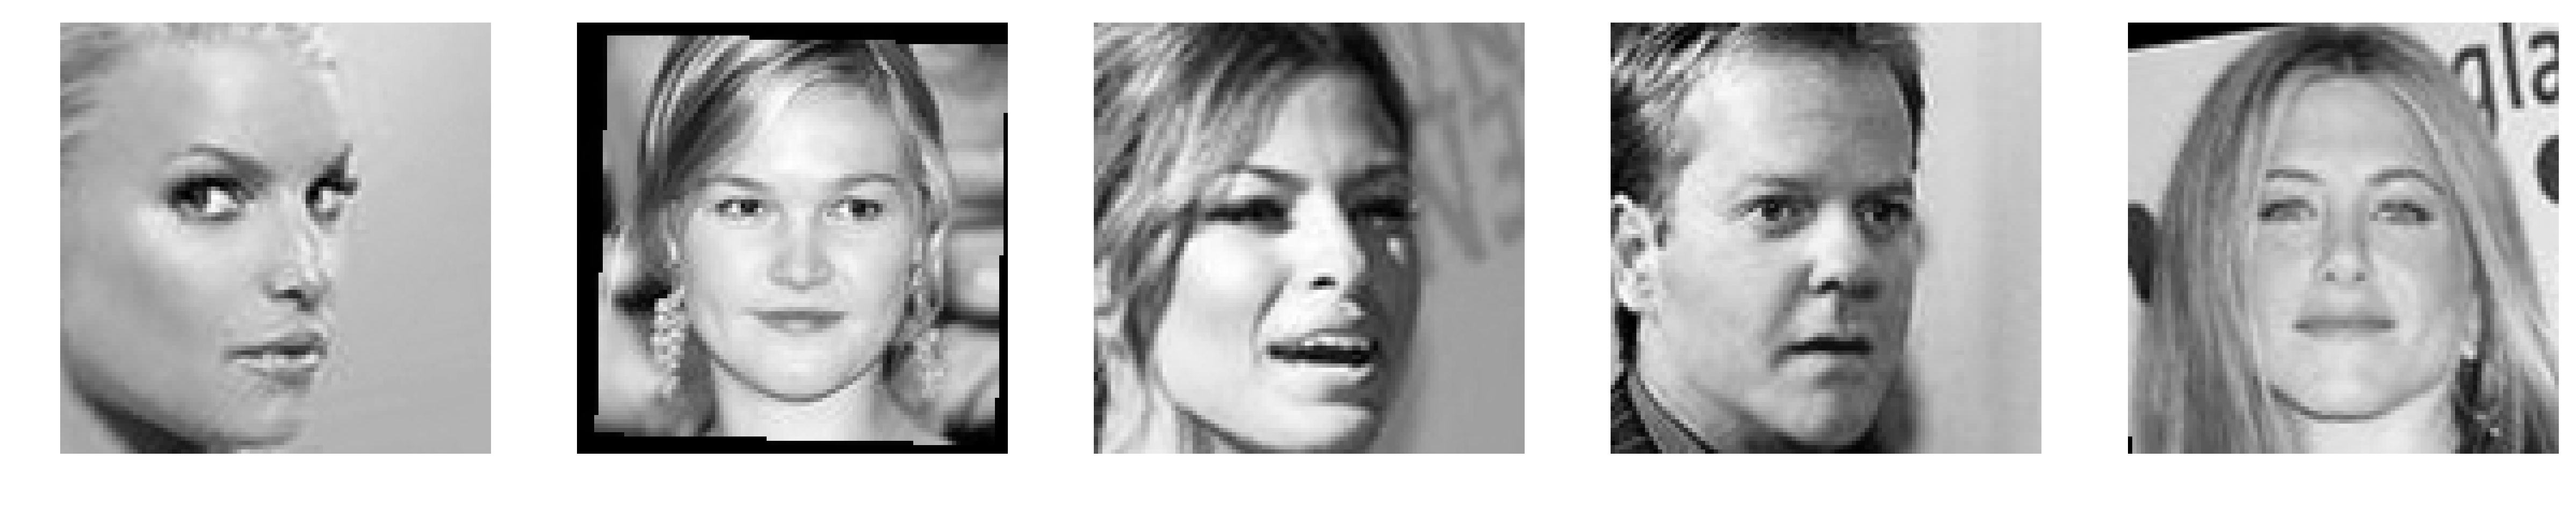

In [53]:
file_list = train_files
im = Image.open(file_list[4]).convert("L")
H,W = np.shape(im)
print('shape: ', (H,W))

dataset = image_to_vector(train_files, H,W)
show_images(dataset,H,W,cols=5,rows_count=5)


### Normalize the dataset

The process of normalizing the dataset consists of two basic activities: Extract an array with the average representation of all images and center the images in the dataset.

#### Extract and visualize the mean

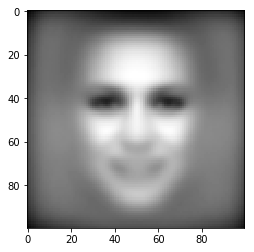

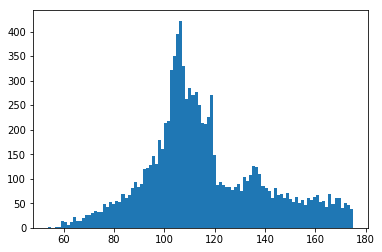

In [54]:
mean_image = extract_mean(dataset)

plt.imshow(np.reshape(mean_image,[H,W]), cmap = plt.get_cmap("gray"))
plt.figure()
plt.hist(mean_image,bins=100);

#### Centralize the dataset

In [55]:
dataset_normalized = centralize(dataset, mean_image, H,W)

#### Examples of image from the normalized dataset

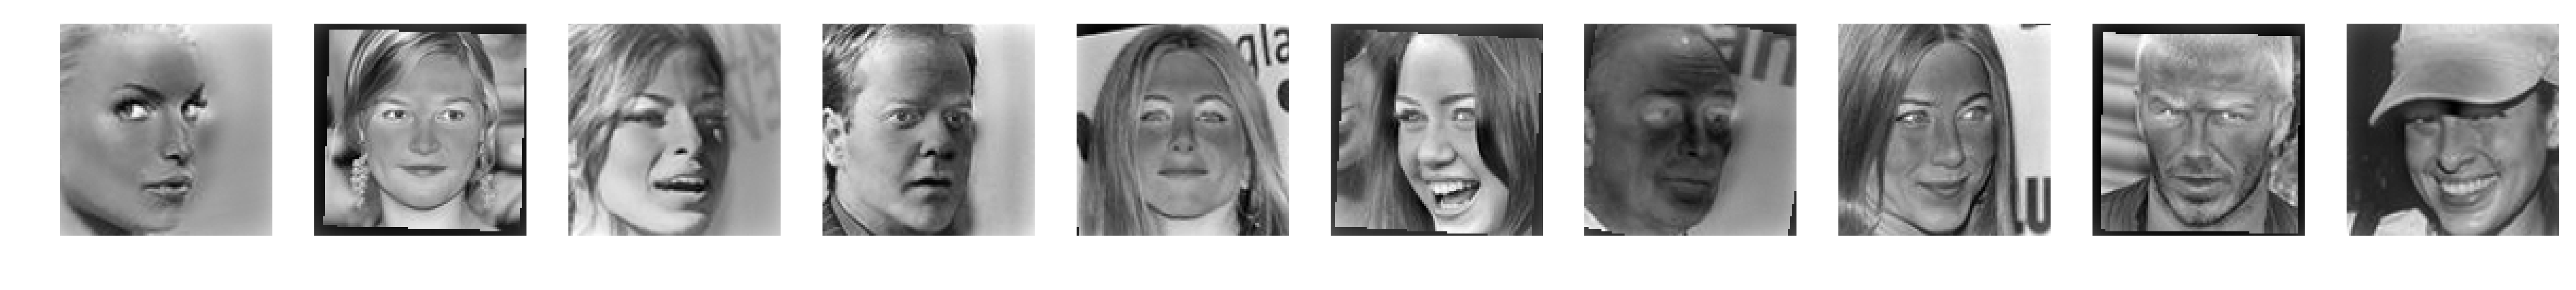

In [56]:
show_images(dataset_normalized[:10,:],H,W)

### 1 - Train a PCA + Eingenfaces + SVM model

#### Load libraries

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from time import time


#### Lookup table
This auxiliary function, returns a list with the array index of the targets tha represents the correct image.

In [58]:
def create_lookup_table(targets):
    lookup = []
    for target in targets:
        index = np.where(target==1)[0]
        lookup.append(index[0])
    return np.array(lookup)

In [59]:
base_train_targets = create_lookup_table(train_targets)
base_test_targets = create_lookup_table(test_targets)
base_valid_targets = create_lookup_table(valid_targets)

####  Creating a function to execute the PCA

In [60]:
def execute_pca(train, test, n_components):
    print("Extracting the top %d eigenfaces from %d faces"
        % (n_components, train.shape[0]))
    t0 = time()
    pca = PCA(n_components=n_components, svd_solver='randomized',
            whiten=True).fit(train)

    print("done in %0.3fs" % (time() - t0))
    # eigenfaces = pca.components_.reshape((n_components, h, w))
    print("Projecting the input data on the eigenfaces orthonormal basis")
    t0 = time()
    X_train_pca = pca.transform(train)
    X_test_pca = pca.transform(test)
    print("done in %0.3fs" % (time() - t0))
    return X_train_pca, X_test_pca, pca


#### Creating a function to train the model with SVM
This funcition use GridSearchCV to find the best param combination to the data.

In [61]:
def apply_svm(X_train, y_train):
    # Train a SVM classification model
    print("Fitting the classifier to the training set")
#     param_grid = {
#     'C': [1, 5, 10, 50, 100],
#     'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
#     }
    param_grid = {
        'C': [1e3, 5e3, 1e4, 5e4, 1e5],
        'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
    }
    
#     param_grid = [
#         {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10,30, 50,100, 1000]},
#         {'kernel': ['poly'],'degree':[1,2],  'C': [1, 10, 100, 1000]}
#     ]

    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
    clf = clf.fit(X_train, y_train)
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)
    return clf


#### Training the model
After some feature engineering, now we can train the model and check the results  .

In [62]:
X_train = base_train_images
y_train = base_train_targets

X_test  = base_test_images
y_test  = base_test_targets

In [63]:
im = Image.open(test_files[0]).convert("L")
H,W = np.shape(im)
print('shape: ', (H,W))

X_test = image_to_vector(test_files,H,W)
mean_test = extract_mean(X_test)
X_test = centralize(X_test, mean_test, H,W)
print(dataset_normalized.shape)
print(X_test.shape)

X_train_pca, X_test_pca, pca= execute_pca(dataset_normalized, X_test, n_components=160)

('shape: ', (100, 100))
(11071, 10000)
(1388, 10000)
Extracting the top 160 eigenfaces from 11071 faces
done in 41.425s
Projecting the input data on the eigenfaces orthonormal basis
done in 4.001s


#### Plot Scree Plot of PCA

The scree plot is useful to visualize the proportion of the variations explained by pca components.

Text(0.5,0,u'Principal Component Number')

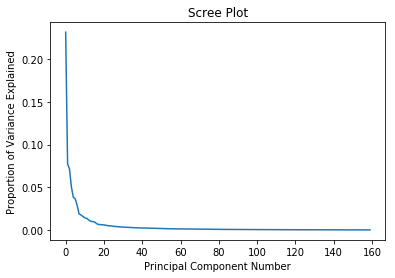

In [34]:
# Let's make a scree plot
pve = pca.explained_variance_ratio_
pve.shape
plt.plot(range(len(pve)), pve)
plt.title("Scree Plot")
plt.ylabel("Proportion of Variance Explained")
plt.xlabel("Principal Component Number")


In this case, the first 20 components account for most of the total variability in the data. The remaining components account for a very small proportion of variability.

#### Eigenfaces
The eigenvectors of the variance-covariance matrix of our "face" data represent the so-called "eigenfaces". They represent the direction of greatest variability in our "face space". We plot the first 9 eigenfaces here.

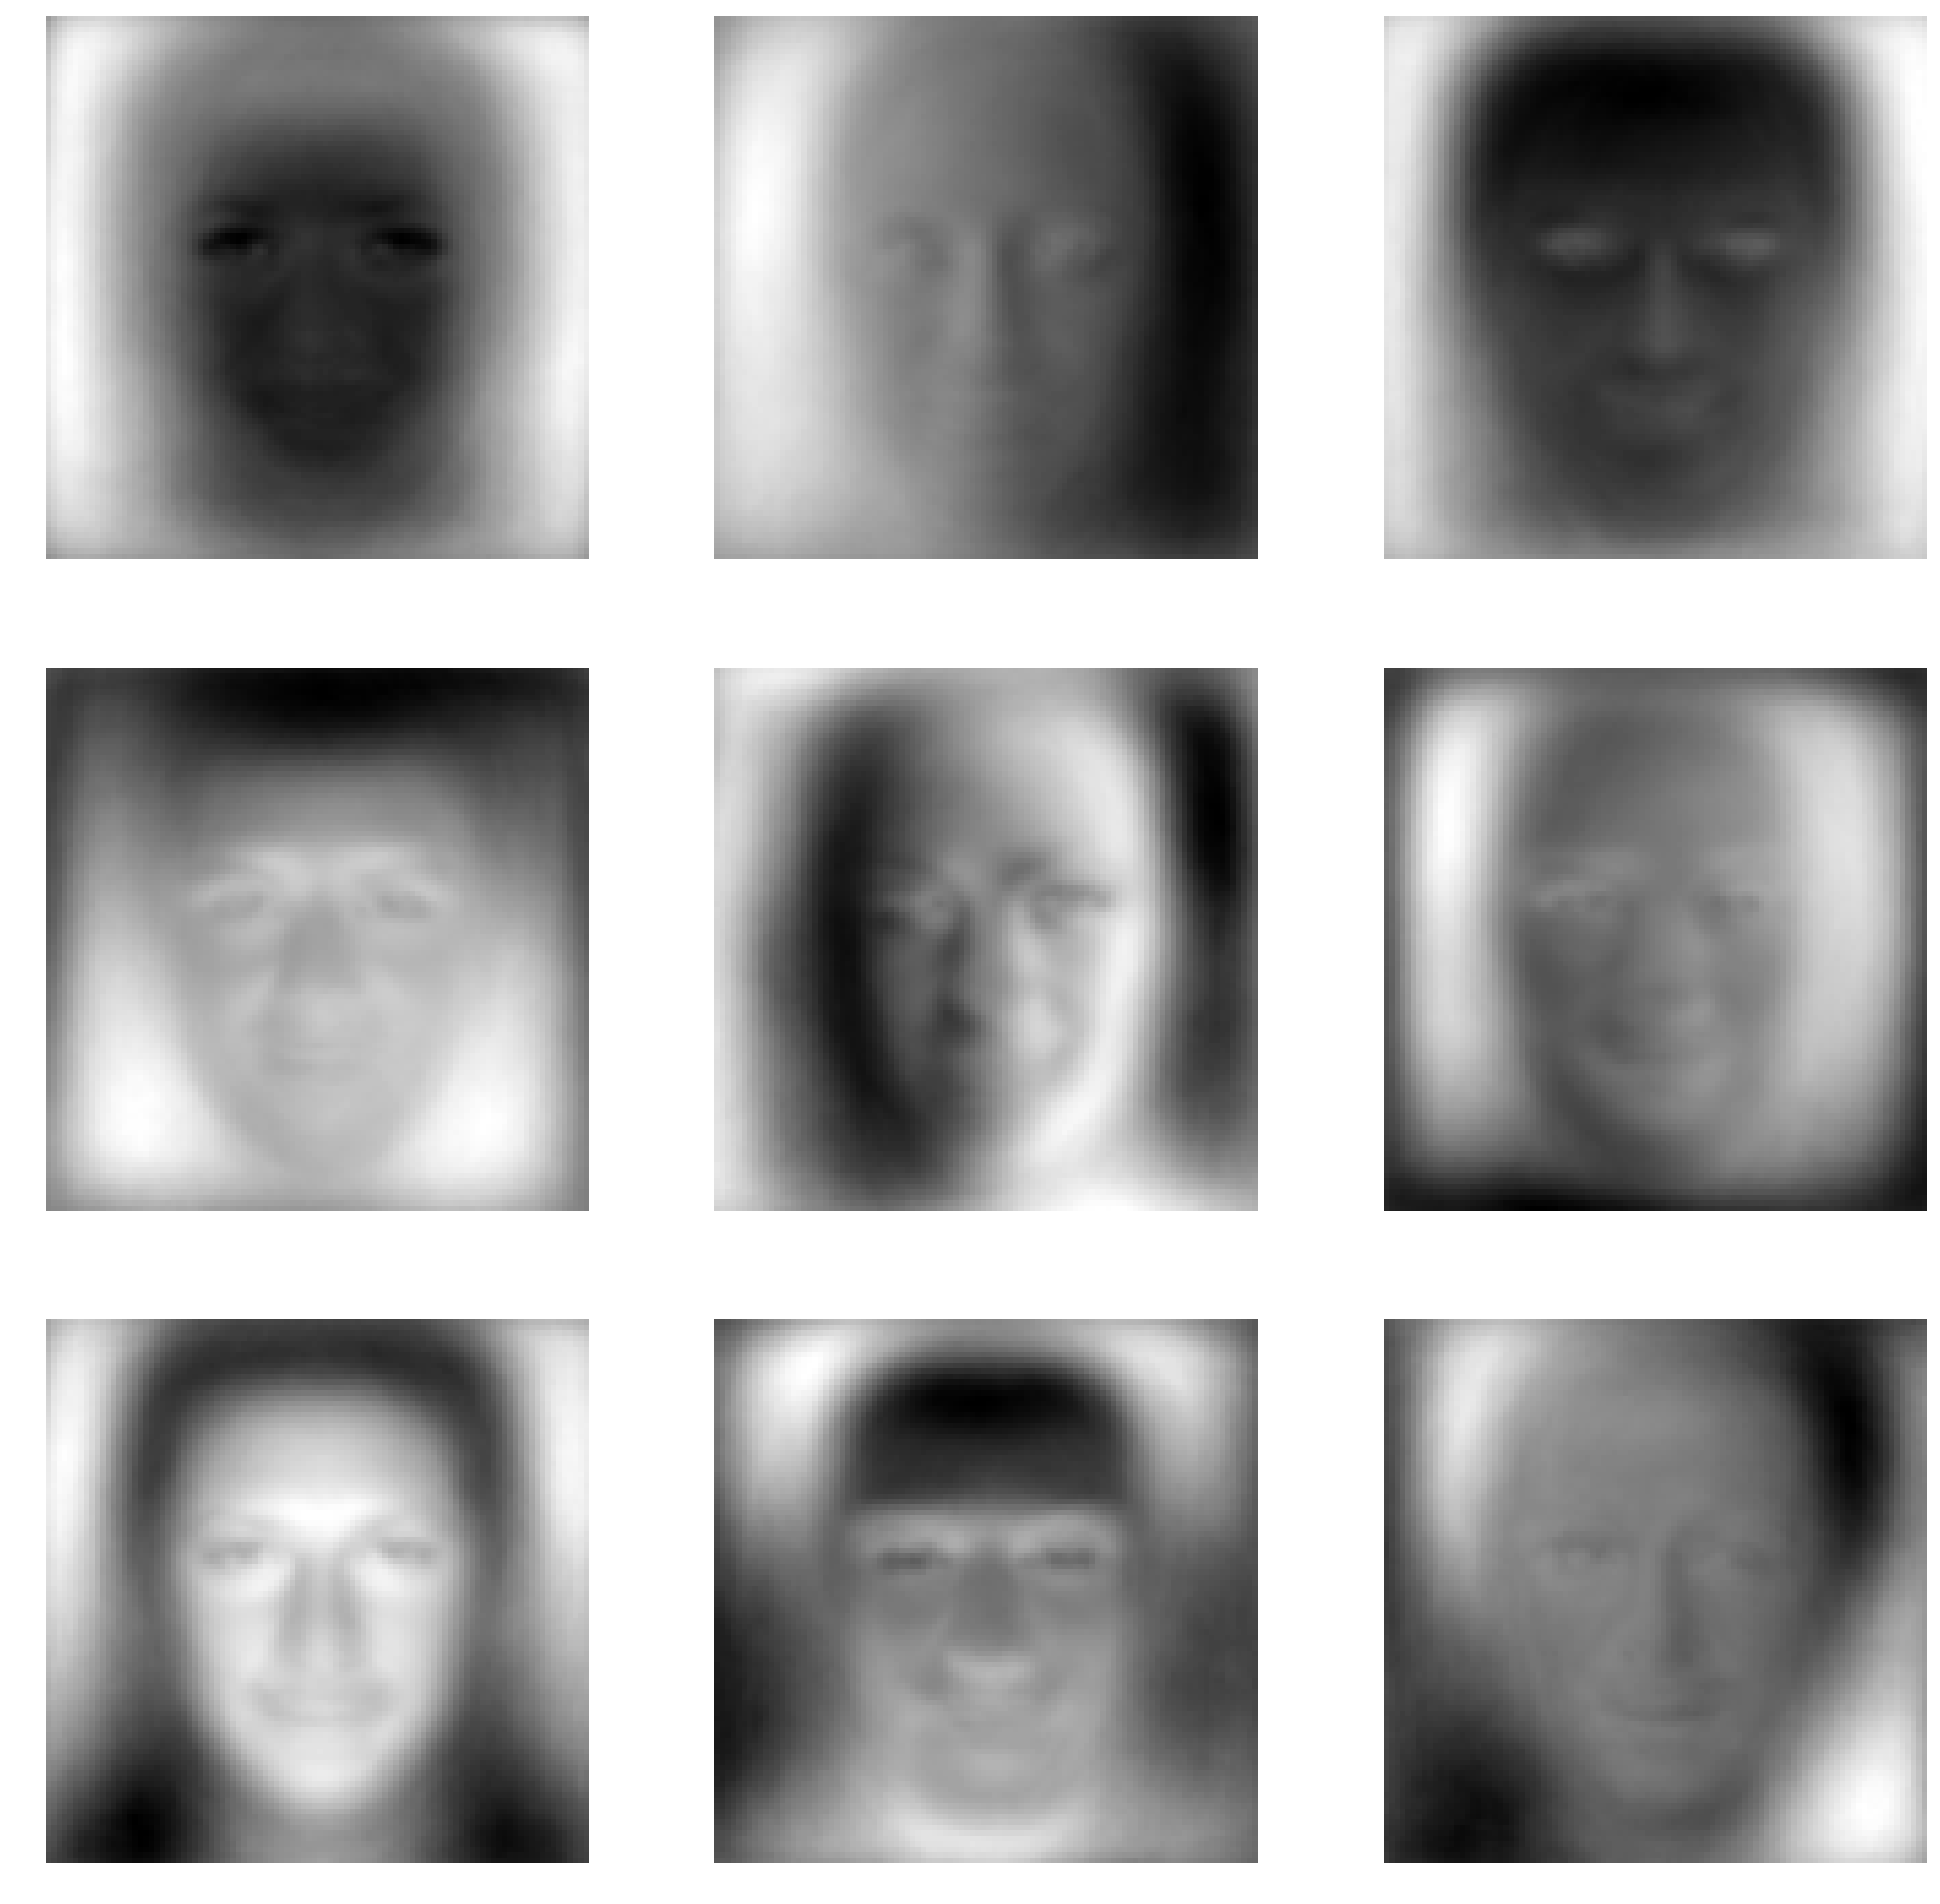

In [35]:
eigenfaces = pca.components_
show_images(eigenfaces[:9,:], H, W, cols=3)

#### Train a SVM with PCA data

In [40]:
clf = apply_svm(X_train_pca, y_train)

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


#### Check accuracy of the model

In [41]:
y_pred = clf.predict(X_test_pca)
print(classification_report(y_test, y_pred, target_names=person_names))

print(confusion_matrix(y_test, y_pred, labels=range(len(person_names))))


                         precision    recall  f1-score   support

        in/Adam Sandler       0.27      0.64      0.38        11
        in/Alec Baldwin       0.16      0.30      0.21        10
      in/Angelina Jolie       0.08      0.10      0.09        21
     in/Anna Kournikova       0.35      0.41      0.38        17
      in/Ashton Kutcher       0.23      0.60      0.33        10
       in/Avril Lavigne       0.24      0.13      0.17        30
        in/Barack Obama       0.44      0.41      0.42        27
         in/Ben Affleck       0.07      0.25      0.12        12
     in/Beyonce Knowles       0.17      0.23      0.19        13
           in/Brad Pitt       0.08      0.03      0.05        30
        in/Cameron Diaz       0.33      0.24      0.28        25
      in/Cate Blanchett       0.04      0.06      0.05        16
     in/Charlize Theron       0.20      0.20      0.20        20
     in/Christina Ricci       0.27      0.43      0.33        14
    in/Claudia Schiffer 

In [42]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.27953890489913547

### Conclusion

This model achieved 30% of accuracy. A very small accuracy. 

### 1 - Train an OpenCV classifier with Haar Cascade features

#### Trainning the classifier

In [64]:
haar_cascade_path = '/usr/share/opencv/haarcascades/haarcascade_frontalface_default.xml'

In [67]:
import cv2
import face_recognition

def get_label(path):
    values = path.split('/')
    if not values:
        return ''
    return values[3]


def trainning_dataset(paths, detect_faces=False):
    recognizer = cv2.face.LBPHFaceRecognizer_create()
    detector= cv2.CascadeClassifier(haar_cascade_path);
    images = []
    labels = []
    description_labels = {}
    id = 0
    paths.sort()
    current_label = get_label(paths[0])
    for image_path in tqdm(paths):
        if current_label != get_label(image_path):
            description_labels[id] = current_label
            current_label = get_label(image_path)
            id += 1
        image_pil = Image.open(image_path).convert('L')
        image = np.array(image_pil, 'uint8')
        image = cv2.equalizeHist(image)
        if detect_faces:
            faces = detector.detectMultiScale(image)
            #If a face is there then append that in the list as well as Id of it
            for (x,y,w,h) in faces:
                images.append(image[y:y+h,x:x+w])
                labels.append(id)
        else:
            images.append(image)
            labels.append(id)
                
    recognizer.train(images, np.array(labels))
    recognizer.save('trainning/trainner.yml')
    return recognizer, description_labels 

   
def preprocessing(paths):
    file_list = paths
    im = Image.open(file_list[0]).convert("L")
    H,W = np.shape(im)
    arr = image_to_vector(file_list, H,W)
    mean_image = extract_mean(arr)
    arr_norm = centralize(arr, mean_image, H,W)
    return arr_norm

def trainning_with_preprocessing(paths, detect_faces=False):
    recognizer = cv2.face.LBPHFaceRecognizer_create()
    detector= cv2.CascadeClassifier(haar_cascade_path);
    images = []
    labels = []
    description_labels = {}
    id = 0
    paths.sort()
    current_label = get_label(paths[0])
    load_images = preprocessing(paths)
    
    for i,image in enumerate(tqdm(load_images)):
        if current_label != get_label(paths[i]):
            description_labels[id] = current_label
            current_label = get_label(paths[i])
            id += 1
        image = np.reshape(image,[100,100])
        image = np.array(image, 'uint8')
        if detect_faces:
            faces = detector.detectMultiScale(image)
            #If a face is there then append that in the list as well as Id of it
            for (x,y,w,h) in faces:
                images.append(image[y:y+h,x:x+w])
                labels.append(id)
        else:
            images.append(image)
            labels.append(id)

    image_pil = Image.open(paths[0]).convert('L') 
    image_pil = np.array(image, 'uint8')

        
    recognizer.train(images, np.array(labels))
    recognizer.save('trainning/trainner.yml')
    return recognizer, description_labels 

100%|██████████| 11071/11071 [01:16<00:00, 144.27it/s]


{0: 'Adam Sandler', 1: 'Alec Baldwin', 2: 'Angelina Jolie', 3: 'Anna Kournikova', 4: 'Ashton Kutcher', 5: 'Avril Lavigne', 6: 'Barack Obama', 7: 'Ben Affleck', 8: 'Beyonce Knowles', 9: 'Brad Pitt', 10: 'Cameron Diaz', 11: 'Cate Blanchett', 12: 'Charlize Theron', 13: 'Christina Ricci', 14: 'Claudia Schiffer', 15: 'Clive Owen', 16: 'Colin Farrell', 17: 'Colin Powell', 18: 'Cristiano Ronaldo', 19: 'Daniel Craig', 20: 'Daniel Radcliffe', 21: 'David Beckham', 22: 'David Duchovny', 23: 'Denise Richards', 24: 'Drew Barrymore', 25: 'Dustin Hoffman', 26: 'Ehud Olmert', 27: 'Eva Mendes', 28: 'Faith Hill', 29: 'George Clooney', 30: 'Gordon Brown', 31: 'Gwyneth Paltrow', 32: 'Halle Berry', 33: 'Harrison Ford', 34: 'Hugh Jackman', 35: 'Hugh Laurie', 36: 'Jack Nicholson', 37: 'Jennifer Aniston', 38: 'Jennifer Lopez', 39: 'Jennifer Love Hewitt', 40: 'Jessica Alba', 41: 'Jessica Simpson', 42: 'Joaquin Phoenix', 43: 'John Travolta', 44: 'Julia Roberts', 45: 'Julia Stiles', 46: 'Kate Moss', 47: 'Kate Wi

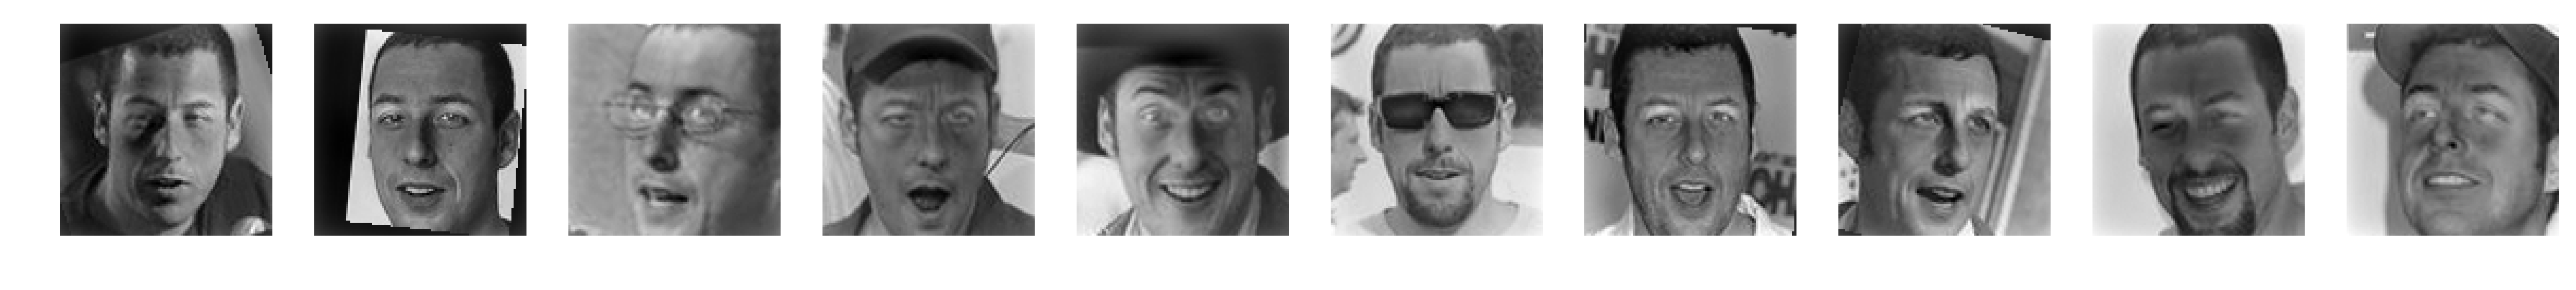

In [77]:
image_pil = preprocessing(train_files)
show_images(image_pil[:10,:],H,W)


recognizer, labels = trainning_dataset(train_files, True)
print labels

#### Checking the accuracy of the model

In [78]:
def check_accuracy(image_paths,labels,recognizer, detect_faces=False):
    detector= cv2.CascadeClassifier(haar_cascade_path);
    image_paths.sort()
    accuracy_list = []
    for image_path in tqdm(image_paths):
#         predict_image_pil  = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        predict_image_pil = Image.open(image_path).convert('L')
        predict_image = np.array(predict_image_pil, np.uint8)
        predict_image = cv2.equalizeHist(predict_image)
#        print image_path
        if detect_faces:
            faces = detector.detectMultiScale(predict_image)
            for (x, y, w, h) in faces:
                nbr_predicted, conf = recognizer.predict(predict_image[y: y + h, x: x + w])
                if nbr_predicted not in labels.keys():
                    accuracy_list.append(0)
                    continue
                predicted = labels[nbr_predicted]
                atual = get_label(image_path)
                if atual == predicted:
                    accuracy_list.append(1)
                    print "{} is Correctly Recognized with confidence {}".format(atual, conf)
                else:
                    accuracy_list.append(0)
                    print "{} is Incorrectly Recognized as {}".format(atual, predicted)
        else:
            nbr_predicted, conf = recognizer.predict(predict_image)
            atual = get_label(image_path)
            if nbr_predicted not in labels.keys():
                accuracy_list.append(0)
                continue
                
            predicted = labels[nbr_predicted]
            if atual == predicted:
                accuracy_list.append(1)
                print "{} is Correctly Recognized with confidence {}".format(atual, conf)
            else:
                accuracy_list.append(0)
                print "{} is Incorrectly Recognized as {}".format(atual, predicted)
    
    print "Total: {}".format(len(accuracy_list))
    accuracy_list = np.array(accuracy_list)
    found = np.where(accuracy_list == 1)
    print found
    print "Found: {}".format(len(found[0]))

    accuracy = float(len(found[0])) / len(accuracy_list)
    print "Accuracy is {}".format(accuracy)


In [71]:
def check_accuracy_preprocessing(image_paths,labels,recognizer, detect_faces=False):
    detector= cv2.CascadeClassifier(haar_cascade_path);
    image_paths.sort()
    accuracy_list = []
    images = preprocessing(image_paths)
    for i,image in enumerate(tqdm(images)):
#         priedict_image_pil  = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#         predict_image_pil = Image.open(image_path).convert('L')
#         predict_image = np.array(predict_image_pil, np.uint8)
#         predict_image = cv2.equalizeHist(predict_image)
#        print image_path
        image_path = image_paths[i]
        image = np.reshape(image,[100,100])
        image = np.array(image, 'uint8')
        predict_image = image
        if detect_faces:
            faces = detector.detectMultiScale(predict_image)
            for (x, y, w, h) in faces:
                nbr_predicted, conf = recognizer.predict(predict_image[y: y + h, x: x + w])
                if nbr_predicted not in labels.keys():
                    accuracy_list.append(0)
                    continue
                predicted = labels[nbr_predicted]
                atual = get_label(image_path)
                if atual == predicted:
                    accuracy_list.append(1)
                    print "{} is Correctly Recognized with confidence {}".format(atual, conf)
                else:
                    accuracy_list.append(0)
                    print "{} is Incorrectly Recognized as {}".format(atual, predicted)
        else:
            nbr_predicted, conf = recognizer.predict(predict_image)
            atual = get_label(image_path)
            if nbr_predicted not in labels.keys():
                accuracy_list.append(0)
                continue
                
            predicted = labels[nbr_predicted]
            if atual == predicted:
                accuracy_list.append(1)
                print "{} is Correctly Recognized with confidence {}".format(atual, conf)
            else:
                accuracy_list.append(0)
                print "{} is Incorrectly Recognized as {}".format(atual, predicted)
    
    print "Total: {}".format(len(accuracy_list))
    accuracy_list = np.array(accuracy_list)
    found = np.where(accuracy_list == 1)
    print found
    print "Found: {}".format(len(found[0]))

    accuracy = float(len(found[0])) / len(accuracy_list)
    print "Accuracy is {}".format(accuracy)


In [79]:
check_accuracy(test_files,labels,recognizer, detect_faces=True)

  0%|          | 1/1388 [00:00<13:29,  1.71it/s]

Adam Sandler is Incorrectly Recognized as Hugh Laurie


  0%|          | 2/1388 [00:01<13:14,  1.74it/s]

Adam Sandler is Incorrectly Recognized as David Duchovny


  0%|          | 3/1388 [00:01<13:13,  1.75it/s]

Adam Sandler is Incorrectly Recognized as Colin Farrell


  0%|          | 4/1388 [00:02<13:08,  1.76it/s]

Adam Sandler is Correctly Recognized with confidence 90.8368069765


  0%|          | 5/1388 [00:02<13:10,  1.75it/s]

Adam Sandler is Correctly Recognized with confidence 90.318389026


  0%|          | 6/1388 [00:03<13:18,  1.73it/s]

Adam Sandler is Incorrectly Recognized as David Duchovny


  1%|          | 7/1388 [00:04<13:21,  1.72it/s]

Adam Sandler is Incorrectly Recognized as Silvio Berlusconi


  1%|          | 8/1388 [00:04<13:25,  1.71it/s]

Adam Sandler is Correctly Recognized with confidence 99.6399284944


  1%|          | 9/1388 [00:05<13:23,  1.72it/s]

Adam Sandler is Correctly Recognized with confidence 96.8302654409


  1%|          | 10/1388 [00:05<13:25,  1.71it/s]

Adam Sandler is Correctly Recognized with confidence 105.177851566


  1%|          | 11/1388 [00:06<13:26,  1.71it/s]

Adam Sandler is Correctly Recognized with confidence 87.0662630457


  1%|          | 12/1388 [00:07<13:25,  1.71it/s]

Alec Baldwin is Correctly Recognized with confidence 99.5649885956


  1%|          | 13/1388 [00:07<13:25,  1.71it/s]

Alec Baldwin is Correctly Recognized with confidence 105.30047517


  1%|          | 14/1388 [00:08<13:23,  1.71it/s]

Alec Baldwin is Incorrectly Recognized as Tom Cruise


  1%|          | 15/1388 [00:08<13:22,  1.71it/s]

Alec Baldwin is Correctly Recognized with confidence 99.7511634894


  1%|          | 16/1388 [00:09<13:24,  1.71it/s]

Alec Baldwin is Incorrectly Recognized as Cristiano Ronaldo


  1%|          | 17/1388 [00:09<13:24,  1.70it/s]

Alec Baldwin is Correctly Recognized with confidence 111.474120351


  1%|▏         | 18/1388 [00:10<13:23,  1.70it/s]

Alec Baldwin is Incorrectly Recognized as Clive Owen


  1%|▏         | 19/1388 [00:11<13:25,  1.70it/s]

Alec Baldwin is Incorrectly Recognized as Orlando Bloom


  1%|▏         | 20/1388 [00:11<13:24,  1.70it/s]

Alec Baldwin is Incorrectly Recognized as Steve Carell


  2%|▏         | 21/1388 [00:12<13:26,  1.69it/s]

Alec Baldwin is Correctly Recognized with confidence 112.175046666


  2%|▏         | 22/1388 [00:12<13:23,  1.70it/s]

Angelina Jolie is Incorrectly Recognized as Leonardo DiCaprio


  2%|▏         | 23/1388 [00:13<13:22,  1.70it/s]

Angelina Jolie is Incorrectly Recognized as Daniel Radcliffe


  2%|▏         | 24/1388 [00:14<13:21,  1.70it/s]

Angelina Jolie is Correctly Recognized with confidence 99.0113527688


  2%|▏         | 25/1388 [00:14<13:19,  1.71it/s]

Angelina Jolie is Incorrectly Recognized as Miley Cyrus


  2%|▏         | 27/1388 [00:15<12:49,  1.77it/s]

Angelina Jolie is Correctly Recognized with confidence 113.132387649


  2%|▏         | 28/1388 [00:15<12:49,  1.77it/s]

Angelina Jolie is Incorrectly Recognized as Clive Owen


  2%|▏         | 29/1388 [00:16<12:49,  1.77it/s]

Angelina Jolie is Incorrectly Recognized as Brad Pitt


  2%|▏         | 30/1388 [00:17<12:51,  1.76it/s]

Angelina Jolie is Correctly Recognized with confidence 106.651396244


  2%|▏         | 31/1388 [00:17<12:52,  1.76it/s]

Angelina Jolie is Correctly Recognized with confidence 99.8470614931


  2%|▏         | 32/1388 [00:18<12:54,  1.75it/s]

Angelina Jolie is Correctly Recognized with confidence 113.053203733


  2%|▏         | 33/1388 [00:18<12:55,  1.75it/s]

Angelina Jolie is Incorrectly Recognized as George Clooney


  2%|▏         | 34/1388 [00:19<12:55,  1.75it/s]

Angelina Jolie is Correctly Recognized with confidence 107.651182411


  3%|▎         | 35/1388 [00:20<12:54,  1.75it/s]

Angelina Jolie is Correctly Recognized with confidence 97.6024697385


  3%|▎         | 36/1388 [00:20<12:53,  1.75it/s]

Angelina Jolie is Incorrectly Recognized as Keira Knightley


  3%|▎         | 37/1388 [00:21<12:53,  1.75it/s]

Angelina Jolie is Correctly Recognized with confidence 111.556299172


  3%|▎         | 40/1388 [00:21<12:14,  1.83it/s]

Angelina Jolie is Incorrectly Recognized as Miley Cyrus


  3%|▎         | 41/1388 [00:22<12:16,  1.83it/s]

Angelina Jolie is Incorrectly Recognized as Gwyneth Paltrow


  3%|▎         | 42/1388 [00:22<12:16,  1.83it/s]

Angelina Jolie is Incorrectly Recognized as Sharon Stone


  3%|▎         | 43/1388 [00:23<12:16,  1.83it/s]

Anna Kournikova is Correctly Recognized with confidence 137.8172218


  3%|▎         | 44/1388 [00:24<12:17,  1.82it/s]

Anna Kournikova is Incorrectly Recognized as Ehud Olmert


  3%|▎         | 45/1388 [00:24<12:19,  1.82it/s]

Anna Kournikova is Correctly Recognized with confidence 105.61838086


  3%|▎         | 46/1388 [00:25<12:20,  1.81it/s]

Anna Kournikova is Correctly Recognized with confidence 109.899256188


  3%|▎         | 47/1388 [00:26<12:22,  1.81it/s]

Anna Kournikova is Correctly Recognized with confidence 108.749652024


  4%|▎         | 49/1388 [00:26<12:09,  1.84it/s]

Anna Kournikova is Correctly Recognized with confidence 106.265857405


  4%|▎         | 50/1388 [00:27<12:09,  1.83it/s]

Anna Kournikova is Correctly Recognized with confidence 110.391687228


  4%|▎         | 51/1388 [00:27<12:11,  1.83it/s]

Anna Kournikova is Correctly Recognized with confidence 94.145754197


  4%|▎         | 52/1388 [00:28<12:11,  1.83it/s]

Anna Kournikova is Incorrectly Recognized as Lindsay Lohan


  4%|▍         | 53/1388 [00:29<12:12,  1.82it/s]

Anna Kournikova is Incorrectly Recognized as Eva Mendes


  4%|▍         | 54/1388 [00:29<12:12,  1.82it/s]

Anna Kournikova is Incorrectly Recognized as Katherine Heigl


  4%|▍         | 55/1388 [00:30<12:12,  1.82it/s]

Anna Kournikova is Correctly Recognized with confidence 102.494660407


  4%|▍         | 56/1388 [00:30<12:12,  1.82it/s]

Anna Kournikova is Incorrectly Recognized as Nicole Richie


  4%|▍         | 57/1388 [00:31<12:13,  1.82it/s]

Anna Kournikova is Correctly Recognized with confidence 96.961951803


  4%|▍         | 58/1388 [00:32<12:14,  1.81it/s]

Anna Kournikova is Incorrectly Recognized as Drew Barrymore


  4%|▍         | 59/1388 [00:32<12:14,  1.81it/s]

Anna Kournikova is Incorrectly Recognized as Sharon Stone


  4%|▍         | 60/1388 [00:33<12:14,  1.81it/s]

Ashton Kutcher is Incorrectly Recognized as Christina Ricci


  4%|▍         | 61/1388 [00:33<12:14,  1.81it/s]

Ashton Kutcher is Incorrectly Recognized as Meg Ryan


  4%|▍         | 62/1388 [00:34<12:14,  1.80it/s]

Ashton Kutcher is Incorrectly Recognized as George Clooney


  5%|▍         | 63/1388 [00:34<12:14,  1.80it/s]

Ashton Kutcher is Incorrectly Recognized as Jessica Simpson


  5%|▍         | 64/1388 [00:35<12:14,  1.80it/s]

Ashton Kutcher is Incorrectly Recognized as Daniel Radcliffe


  5%|▍         | 65/1388 [00:36<12:15,  1.80it/s]

Ashton Kutcher is Incorrectly Recognized as Leonardo DiCaprio


  5%|▍         | 66/1388 [00:36<12:16,  1.80it/s]

Ashton Kutcher is Incorrectly Recognized as Halle Berry


  5%|▍         | 67/1388 [00:37<12:16,  1.79it/s]

Ashton Kutcher is Incorrectly Recognized as Daniel Radcliffe


  5%|▍         | 68/1388 [00:37<12:17,  1.79it/s]

Ashton Kutcher is Incorrectly Recognized as Leonardo DiCaprio


  5%|▍         | 69/1388 [00:38<12:17,  1.79it/s]

Ashton Kutcher is Incorrectly Recognized as Daniel Radcliffe


  5%|▌         | 70/1388 [00:39<12:17,  1.79it/s]

Avril Lavigne is Incorrectly Recognized as Angelina Jolie


  5%|▌         | 71/1388 [00:39<12:17,  1.79it/s]

Avril Lavigne is Correctly Recognized with confidence 99.9889510597


  5%|▌         | 72/1388 [00:40<12:17,  1.78it/s]

Avril Lavigne is Correctly Recognized with confidence 97.2348183552


  5%|▌         | 73/1388 [00:40<12:17,  1.78it/s]

Avril Lavigne is Incorrectly Recognized as Denise Richards


  5%|▌         | 74/1388 [00:41<12:17,  1.78it/s]

Avril Lavigne is Correctly Recognized with confidence 86.6277189941


  5%|▌         | 75/1388 [00:42<12:16,  1.78it/s]

Avril Lavigne is Correctly Recognized with confidence 89.1686922381


  5%|▌         | 76/1388 [00:42<12:17,  1.78it/s]

Avril Lavigne is Correctly Recognized with confidence 105.691095475


  6%|▌         | 77/1388 [00:43<12:18,  1.78it/s]

Avril Lavigne is Incorrectly Recognized as Scarlett Johansson


  6%|▌         | 78/1388 [00:44<12:22,  1.77it/s]

Avril Lavigne is Incorrectly Recognized as Miley Cyrus


  6%|▌         | 79/1388 [00:45<12:27,  1.75it/s]

Avril Lavigne is Correctly Recognized with confidence 92.6573629501


  6%|▌         | 80/1388 [00:46<12:32,  1.74it/s]

Avril Lavigne is Correctly Recognized with confidence 106.993610119


  6%|▌         | 81/1388 [00:47<12:38,  1.72it/s]

Avril Lavigne is Correctly Recognized with confidence 98.5467588939


  6%|▌         | 82/1388 [00:47<12:39,  1.72it/s]

Avril Lavigne is Incorrectly Recognized as Faith Hill


  6%|▌         | 83/1388 [00:48<12:39,  1.72it/s]

Avril Lavigne is Incorrectly Recognized as Julia Stiles


  6%|▌         | 84/1388 [00:48<12:39,  1.72it/s]

Avril Lavigne is Incorrectly Recognized as Jessica Simpson


  6%|▌         | 85/1388 [00:49<12:39,  1.72it/s]

Avril Lavigne is Incorrectly Recognized as Claudia Schiffer


  6%|▌         | 86/1388 [00:50<12:39,  1.72it/s]

Avril Lavigne is Correctly Recognized with confidence 73.6633092482


  6%|▋         | 87/1388 [00:50<12:38,  1.71it/s]

Avril Lavigne is Correctly Recognized with confidence 93.6836969732


  6%|▋         | 88/1388 [00:51<12:38,  1.71it/s]

Avril Lavigne is Incorrectly Recognized as Sharon Stone


  6%|▋         | 89/1388 [00:51<12:38,  1.71it/s]

Avril Lavigne is Correctly Recognized with confidence 95.9560556478


  6%|▋         | 90/1388 [00:52<12:38,  1.71it/s]

Avril Lavigne is Correctly Recognized with confidence 113.082550112


  7%|▋         | 91/1388 [00:53<12:37,  1.71it/s]

Avril Lavigne is Correctly Recognized with confidence 95.2344141139


  7%|▋         | 92/1388 [00:53<12:38,  1.71it/s]

Avril Lavigne is Correctly Recognized with confidence 113.016839873


  7%|▋         | 93/1388 [00:54<12:37,  1.71it/s]

Avril Lavigne is Correctly Recognized with confidence 109.021137556


  7%|▋         | 94/1388 [00:55<12:37,  1.71it/s]

Avril Lavigne is Correctly Recognized with confidence 103.487892029


  7%|▋         | 96/1388 [00:55<12:28,  1.73it/s]

Avril Lavigne is Correctly Recognized with confidence 93.8365991692


  7%|▋         | 97/1388 [00:56<12:28,  1.72it/s]

Avril Lavigne is Incorrectly Recognized as Jennifer Love Hewitt


  7%|▋         | 98/1388 [00:56<12:27,  1.73it/s]

Avril Lavigne is Correctly Recognized with confidence 109.736573046


  7%|▋         | 99/1388 [00:57<12:27,  1.72it/s]

Avril Lavigne is Incorrectly Recognized as Angelina Jolie


  7%|▋         | 100/1388 [00:58<12:27,  1.72it/s]

Barack Obama is Correctly Recognized with confidence 110.643372549


  7%|▋         | 101/1388 [00:58<12:27,  1.72it/s]

Barack Obama is Correctly Recognized with confidence 96.3672921248


  7%|▋         | 102/1388 [00:59<12:27,  1.72it/s]

Barack Obama is Correctly Recognized with confidence 107.449245987


  7%|▋         | 103/1388 [00:59<12:27,  1.72it/s]

Barack Obama is Correctly Recognized with confidence 109.775977581


  7%|▋         | 104/1388 [01:00<12:26,  1.72it/s]

Barack Obama is Correctly Recognized with confidence 109.33084943


  8%|▊         | 105/1388 [01:01<12:26,  1.72it/s]

Barack Obama is Correctly Recognized with confidence 104.637391557


  8%|▊         | 106/1388 [01:01<12:26,  1.72it/s]

Barack Obama is Correctly Recognized with confidence 105.456684477


  8%|▊         | 107/1388 [01:02<12:26,  1.72it/s]

Barack Obama is Correctly Recognized with confidence 111.155245627


  8%|▊         | 108/1388 [01:02<12:26,  1.72it/s]

Barack Obama is Correctly Recognized with confidence 109.44528982


  8%|▊         | 109/1388 [01:03<12:26,  1.71it/s]

Barack Obama is Correctly Recognized with confidence 117.634742739


  8%|▊         | 110/1388 [01:04<12:25,  1.71it/s]

Barack Obama is Incorrectly Recognized as David Duchovny


  8%|▊         | 111/1388 [01:04<12:25,  1.71it/s]

Barack Obama is Incorrectly Recognized as Daniel Craig


  8%|▊         | 112/1388 [01:05<12:25,  1.71it/s]

Barack Obama is Correctly Recognized with confidence 108.348195842


  8%|▊         | 113/1388 [01:06<12:24,  1.71it/s]

Barack Obama is Incorrectly Recognized as Clive Owen


  8%|▊         | 114/1388 [01:06<12:25,  1.71it/s]

Barack Obama is Correctly Recognized with confidence 103.112767325


  8%|▊         | 115/1388 [01:07<12:24,  1.71it/s]

Barack Obama is Correctly Recognized with confidence 103.91929149


  8%|▊         | 116/1388 [01:07<12:24,  1.71it/s]

Barack Obama is Incorrectly Recognized as Jessica Alba


  8%|▊         | 117/1388 [01:08<12:24,  1.71it/s]

Barack Obama is Correctly Recognized with confidence 105.356758695


  9%|▊         | 118/1388 [01:09<12:23,  1.71it/s]

Barack Obama is Correctly Recognized with confidence 103.119044344


  9%|▊         | 119/1388 [01:09<12:23,  1.71it/s]

Barack Obama is Incorrectly Recognized as Gordon Brown


  9%|▊         | 120/1388 [01:10<12:23,  1.71it/s]

Barack Obama is Incorrectly Recognized as Joaquin Phoenix


  9%|▊         | 121/1388 [01:10<12:23,  1.71it/s]

Barack Obama is Correctly Recognized with confidence 104.219612041


  9%|▉         | 122/1388 [01:11<12:22,  1.70it/s]

Barack Obama is Correctly Recognized with confidence 116.421122659


  9%|▉         | 123/1388 [01:12<12:23,  1.70it/s]

Barack Obama is Correctly Recognized with confidence 117.496746435


  9%|▉         | 124/1388 [01:12<12:22,  1.70it/s]

Barack Obama is Correctly Recognized with confidence 101.805346733


  9%|▉         | 125/1388 [01:13<12:22,  1.70it/s]

Barack Obama is Correctly Recognized with confidence 101.3564174


  9%|▉         | 126/1388 [01:14<12:22,  1.70it/s]

Barack Obama is Correctly Recognized with confidence 107.344394976


  9%|▉         | 127/1388 [01:14<12:22,  1.70it/s]

Ben Affleck is Incorrectly Recognized as Hugh Laurie


  9%|▉         | 128/1388 [01:15<12:21,  1.70it/s]

Ben Affleck is Correctly Recognized with confidence 105.493507373


  9%|▉         | 129/1388 [01:15<12:21,  1.70it/s]

Ben Affleck is Incorrectly Recognized as George Clooney


  9%|▉         | 130/1388 [01:16<12:21,  1.70it/s]

Ben Affleck is Correctly Recognized with confidence 92.0944206696


  9%|▉         | 131/1388 [01:17<12:20,  1.70it/s]

Ben Affleck is Incorrectly Recognized as Ehud Olmert


 10%|▉         | 132/1388 [01:17<12:20,  1.70it/s]

Ben Affleck is Correctly Recognized with confidence 110.400436361


 10%|▉         | 133/1388 [01:18<12:20,  1.70it/s]

Ben Affleck is Correctly Recognized with confidence 97.8641224837


 10%|▉         | 134/1388 [01:18<12:19,  1.70it/s]

Ben Affleck is Incorrectly Recognized as Alec Baldwin


 10%|▉         | 135/1388 [01:19<12:18,  1.70it/s]

Ben Affleck is Correctly Recognized with confidence 96.6542580191


 10%|▉         | 136/1388 [01:20<12:18,  1.70it/s]

Ben Affleck is Incorrectly Recognized as Hugh Laurie


 10%|▉         | 137/1388 [01:20<12:18,  1.69it/s]

Ben Affleck is Incorrectly Recognized as Daniel Craig


 10%|▉         | 138/1388 [01:21<12:17,  1.69it/s]

Ben Affleck is Correctly Recognized with confidence 93.648417818


 10%|█         | 139/1388 [01:22<12:16,  1.69it/s]

Beyonce Knowles is Correctly Recognized with confidence 111.456168478


 10%|█         | 140/1388 [01:22<12:16,  1.69it/s]

Beyonce Knowles is Incorrectly Recognized as Jessica Alba


 10%|█         | 141/1388 [01:23<12:16,  1.69it/s]

Beyonce Knowles is Incorrectly Recognized as Avril Lavigne


 10%|█         | 142/1388 [01:23<12:15,  1.69it/s]

Beyonce Knowles is Incorrectly Recognized as Scarlett Johansson


 10%|█         | 143/1388 [01:24<12:15,  1.69it/s]

Beyonce Knowles is Incorrectly Recognized as Mariah Carey


 10%|█         | 144/1388 [01:25<12:14,  1.69it/s]

Beyonce Knowles is Incorrectly Recognized as Nicole Richie


 10%|█         | 145/1388 [01:25<12:14,  1.69it/s]

Beyonce Knowles is Correctly Recognized with confidence 106.175849722


 11%|█         | 146/1388 [01:26<12:14,  1.69it/s]

Beyonce Knowles is Incorrectly Recognized as Lindsay Lohan


 11%|█         | 147/1388 [01:26<12:13,  1.69it/s]

Beyonce Knowles is Incorrectly Recognized as Lindsay Lohan


 11%|█         | 148/1388 [01:27<12:13,  1.69it/s]

Beyonce Knowles is Incorrectly Recognized as Avril Lavigne


 11%|█         | 149/1388 [01:28<12:13,  1.69it/s]

Beyonce Knowles is Incorrectly Recognized as Denise Richards


 11%|█         | 150/1388 [01:28<12:12,  1.69it/s]

Beyonce Knowles is Incorrectly Recognized as Charlize Theron


 11%|█         | 151/1388 [01:29<12:12,  1.69it/s]

Beyonce Knowles is Incorrectly Recognized as Shakira


 11%|█         | 152/1388 [01:30<12:11,  1.69it/s]

Brad Pitt is Incorrectly Recognized as Jessica Alba


 11%|█         | 153/1388 [01:30<12:11,  1.69it/s]

Brad Pitt is Incorrectly Recognized as Julia Stiles


 11%|█         | 154/1388 [01:31<12:11,  1.69it/s]

Brad Pitt is Incorrectly Recognized as Meryl Streep


 11%|█         | 155/1388 [01:31<12:10,  1.69it/s]

Brad Pitt is Correctly Recognized with confidence 109.664047378


 11%|█         | 156/1388 [01:32<12:10,  1.69it/s]

Brad Pitt is Correctly Recognized with confidence 77.3132174347


 11%|█▏        | 157/1388 [01:33<12:10,  1.69it/s]

Brad Pitt is Incorrectly Recognized as Daniel Craig


 11%|█▏        | 158/1388 [01:33<12:10,  1.68it/s]

Brad Pitt is Correctly Recognized with confidence 109.667399901


 11%|█▏        | 159/1388 [01:34<12:10,  1.68it/s]

Brad Pitt is Correctly Recognized with confidence 107.964172648


 12%|█▏        | 160/1388 [01:35<12:10,  1.68it/s]

Brad Pitt is Incorrectly Recognized as George Clooney


 12%|█▏        | 161/1388 [01:35<12:10,  1.68it/s]

Brad Pitt is Correctly Recognized with confidence 111.870100234


 12%|█▏        | 162/1388 [01:36<12:09,  1.68it/s]

Brad Pitt is Correctly Recognized with confidence 112.259005974


 12%|█▏        | 163/1388 [01:37<12:09,  1.68it/s]

Brad Pitt is Incorrectly Recognized as Steve Carell


 12%|█▏        | 164/1388 [01:37<12:09,  1.68it/s]

Brad Pitt is Incorrectly Recognized as Adam Sandler


 12%|█▏        | 165/1388 [01:38<12:09,  1.68it/s]

Brad Pitt is Correctly Recognized with confidence 104.579658748


 12%|█▏        | 166/1388 [01:39<12:08,  1.68it/s]

Brad Pitt is Correctly Recognized with confidence 114.085798528


 12%|█▏        | 167/1388 [01:39<12:08,  1.68it/s]

Brad Pitt is Correctly Recognized with confidence 100.326919858


 12%|█▏        | 169/1388 [01:40<12:03,  1.69it/s]

Brad Pitt is Correctly Recognized with confidence 121.97478025


 12%|█▏        | 171/1388 [01:40<11:57,  1.70it/s]

Brad Pitt is Correctly Recognized with confidence 98.3173754929


 12%|█▏        | 172/1388 [01:41<11:57,  1.70it/s]

Brad Pitt is Correctly Recognized with confidence 101.54012591


 12%|█▏        | 173/1388 [01:42<11:57,  1.69it/s]

Brad Pitt is Correctly Recognized with confidence 108.221825931


 13%|█▎        | 174/1388 [01:42<11:56,  1.69it/s]

Brad Pitt is Incorrectly Recognized as Cristiano Ronaldo


 13%|█▎        | 175/1388 [01:43<11:56,  1.69it/s]

Brad Pitt is Correctly Recognized with confidence 113.621937911


 13%|█▎        | 176/1388 [01:43<11:55,  1.69it/s]

Brad Pitt is Correctly Recognized with confidence 95.0609891487


 13%|█▎        | 177/1388 [01:44<11:55,  1.69it/s]

Brad Pitt is Incorrectly Recognized as Angelina Jolie


 13%|█▎        | 178/1388 [01:45<11:55,  1.69it/s]

Brad Pitt is Incorrectly Recognized as Barack Obama


 13%|█▎        | 179/1388 [01:45<11:54,  1.69it/s]

Brad Pitt is Correctly Recognized with confidence 103.314588197


 13%|█▎        | 180/1388 [01:46<11:54,  1.69it/s]

Brad Pitt is Correctly Recognized with confidence 118.902179695


 13%|█▎        | 181/1388 [01:47<11:53,  1.69it/s]

Brad Pitt is Correctly Recognized with confidence 125.457241136


 13%|█▎        | 182/1388 [01:47<11:53,  1.69it/s]

Cameron Diaz is Incorrectly Recognized as Steve Carell


 13%|█▎        | 183/1388 [01:48<11:53,  1.69it/s]

Cameron Diaz is Correctly Recognized with confidence 115.42562256


 13%|█▎        | 184/1388 [01:48<11:53,  1.69it/s]

Cameron Diaz is Incorrectly Recognized as David Duchovny


 13%|█▎        | 185/1388 [01:49<11:52,  1.69it/s]

Cameron Diaz is Incorrectly Recognized as Meg Ryan


 13%|█▎        | 186/1388 [01:50<11:52,  1.69it/s]

Cameron Diaz is Correctly Recognized with confidence 104.777097715


 13%|█▎        | 187/1388 [01:50<11:52,  1.69it/s]

Cameron Diaz is Correctly Recognized with confidence 101.365212837


 14%|█▎        | 188/1388 [01:51<11:51,  1.69it/s]

Cameron Diaz is Correctly Recognized with confidence 100.217852659


 14%|█▎        | 189/1388 [01:52<11:51,  1.69it/s]

Cameron Diaz is Correctly Recognized with confidence 106.518880835


 14%|█▎        | 190/1388 [01:52<11:50,  1.69it/s]

Cameron Diaz is Correctly Recognized with confidence 109.981010387


 14%|█▍        | 191/1388 [01:53<11:50,  1.68it/s]

Cameron Diaz is Correctly Recognized with confidence 94.3898173897


 14%|█▍        | 192/1388 [01:53<11:49,  1.69it/s]

Cameron Diaz is Incorrectly Recognized as Sharon Stone


 14%|█▍        | 193/1388 [01:54<11:49,  1.68it/s]

Cameron Diaz is Correctly Recognized with confidence 96.8547591012


 14%|█▍        | 194/1388 [01:55<11:49,  1.68it/s]

Cameron Diaz is Incorrectly Recognized as Anna Kournikova


 14%|█▍        | 195/1388 [01:55<11:48,  1.68it/s]

Cameron Diaz is Correctly Recognized with confidence 94.4076017416


 14%|█▍        | 196/1388 [01:56<11:48,  1.68it/s]

Cameron Diaz is Incorrectly Recognized as Halle Berry


 14%|█▍        | 197/1388 [01:57<11:48,  1.68it/s]

Cameron Diaz is Incorrectly Recognized as Drew Barrymore


 14%|█▍        | 198/1388 [01:57<11:48,  1.68it/s]

Cameron Diaz is Incorrectly Recognized as Lindsay Lohan


 14%|█▍        | 199/1388 [01:58<11:47,  1.68it/s]

Cameron Diaz is Correctly Recognized with confidence 107.053208059


 14%|█▍        | 200/1388 [01:59<11:47,  1.68it/s]

Cameron Diaz is Incorrectly Recognized as Reese Witherspoon


 14%|█▍        | 201/1388 [01:59<11:46,  1.68it/s]

Cameron Diaz is Incorrectly Recognized as Denise Richards


 15%|█▍        | 202/1388 [02:00<11:46,  1.68it/s]

Cameron Diaz is Incorrectly Recognized as Barack Obama


 15%|█▍        | 203/1388 [02:00<11:45,  1.68it/s]

Cameron Diaz is Incorrectly Recognized as Alec Baldwin


 15%|█▍        | 204/1388 [02:01<11:45,  1.68it/s]

Cameron Diaz is Correctly Recognized with confidence 110.846102154


 15%|█▍        | 205/1388 [02:02<11:44,  1.68it/s]

Cameron Diaz is Incorrectly Recognized as Gwyneth Paltrow


 15%|█▍        | 206/1388 [02:02<11:44,  1.68it/s]

Cameron Diaz is Correctly Recognized with confidence 92.3121780652


 15%|█▍        | 207/1388 [02:03<11:44,  1.68it/s]

Cate Blanchett is Incorrectly Recognized as Anna Kournikova


 15%|█▍        | 208/1388 [02:04<11:43,  1.68it/s]

Cate Blanchett is Incorrectly Recognized as Clive Owen


 15%|█▌        | 209/1388 [02:04<11:43,  1.68it/s]

Cate Blanchett is Correctly Recognized with confidence 92.2508963316


 15%|█▌        | 210/1388 [02:05<11:42,  1.68it/s]

Cate Blanchett is Incorrectly Recognized as Brad Pitt


 15%|█▌        | 211/1388 [02:05<11:42,  1.68it/s]

Cate Blanchett is Correctly Recognized with confidence 96.9528715152


 15%|█▌        | 212/1388 [02:06<11:41,  1.68it/s]

Cate Blanchett is Incorrectly Recognized as Faith Hill


 15%|█▌        | 213/1388 [02:07<11:41,  1.67it/s]

Cate Blanchett is Incorrectly Recognized as Cameron Diaz


 15%|█▌        | 214/1388 [02:07<11:41,  1.67it/s]

Cate Blanchett is Incorrectly Recognized as Jessica Simpson


 15%|█▌        | 215/1388 [02:08<11:40,  1.67it/s]

Cate Blanchett is Incorrectly Recognized as Cameron Diaz


 16%|█▌        | 216/1388 [02:09<11:40,  1.67it/s]

Cate Blanchett is Incorrectly Recognized as Avril Lavigne


 16%|█▌        | 217/1388 [02:09<11:39,  1.67it/s]

Cate Blanchett is Correctly Recognized with confidence 98.0607755018
Cate Blanchett is Incorrectly Recognized as Avril Lavigne


 16%|█▌        | 218/1388 [02:10<11:42,  1.67it/s]

Cate Blanchett is Correctly Recognized with confidence 93.7706792047


 16%|█▌        | 219/1388 [02:11<11:41,  1.67it/s]

Cate Blanchett is Incorrectly Recognized as Jessica Alba


 16%|█▌        | 220/1388 [02:12<11:40,  1.67it/s]

Cate Blanchett is Incorrectly Recognized as Victoria Beckham


 16%|█▌        | 221/1388 [02:12<11:40,  1.67it/s]

Cate Blanchett is Incorrectly Recognized as Charlize Theron


 16%|█▌        | 222/1388 [02:13<11:39,  1.67it/s]

Cate Blanchett is Incorrectly Recognized as Renee Zellweger


 16%|█▌        | 223/1388 [02:13<11:38,  1.67it/s]

Charlize Theron is Correctly Recognized with confidence 96.4146824859


 16%|█▌        | 224/1388 [02:14<11:38,  1.67it/s]

Charlize Theron is Incorrectly Recognized as Victoria Beckham


 16%|█▌        | 225/1388 [02:14<11:37,  1.67it/s]

Charlize Theron is Correctly Recognized with confidence 97.6881639605


 16%|█▋        | 226/1388 [02:15<11:37,  1.67it/s]

Charlize Theron is Correctly Recognized with confidence 99.4867091505


 16%|█▋        | 227/1388 [02:16<11:36,  1.67it/s]

Charlize Theron is Incorrectly Recognized as Jennifer Aniston


 16%|█▋        | 228/1388 [02:16<11:36,  1.67it/s]

Charlize Theron is Incorrectly Recognized as Sharon Stone


 17%|█▋        | 230/1388 [02:17<11:32,  1.67it/s]

Charlize Theron is Incorrectly Recognized as Avril Lavigne


 17%|█▋        | 231/1388 [02:18<11:31,  1.67it/s]

Charlize Theron is Incorrectly Recognized as Viggo Mortensen


 17%|█▋        | 232/1388 [02:18<11:31,  1.67it/s]

Charlize Theron is Incorrectly Recognized as Miley Cyrus


 17%|█▋        | 233/1388 [02:19<11:30,  1.67it/s]

Charlize Theron is Incorrectly Recognized as Jessica Simpson


 17%|█▋        | 234/1388 [02:19<11:30,  1.67it/s]

Charlize Theron is Correctly Recognized with confidence 118.510123706


 17%|█▋        | 235/1388 [02:20<11:29,  1.67it/s]

Charlize Theron is Incorrectly Recognized as Kate Moss


 17%|█▋        | 236/1388 [02:21<11:29,  1.67it/s]

Charlize Theron is Correctly Recognized with confidence 99.2365374406


 17%|█▋        | 237/1388 [02:21<11:28,  1.67it/s]

Charlize Theron is Incorrectly Recognized as Jennifer Aniston


 17%|█▋        | 238/1388 [02:22<11:28,  1.67it/s]

Charlize Theron is Correctly Recognized with confidence 101.217760404


 17%|█▋        | 239/1388 [02:22<11:27,  1.67it/s]

Charlize Theron is Incorrectly Recognized as Keira Knightley


 17%|█▋        | 240/1388 [02:23<11:27,  1.67it/s]

Charlize Theron is Incorrectly Recognized as Avril Lavigne


 17%|█▋        | 241/1388 [02:24<11:26,  1.67it/s]

Charlize Theron is Incorrectly Recognized as Gwyneth Paltrow


 17%|█▋        | 242/1388 [02:24<11:26,  1.67it/s]

Charlize Theron is Incorrectly Recognized as Denise Richards


 18%|█▊        | 243/1388 [02:25<11:25,  1.67it/s]

Christina Ricci is Correctly Recognized with confidence 109.529716896


 18%|█▊        | 244/1388 [02:26<11:25,  1.67it/s]

Christina Ricci is Correctly Recognized with confidence 98.9970535669


 18%|█▊        | 245/1388 [02:26<11:24,  1.67it/s]

Christina Ricci is Incorrectly Recognized as Katherine Heigl


 18%|█▊        | 247/1388 [02:27<11:21,  1.68it/s]

Christina Ricci is Correctly Recognized with confidence 104.734941896


 18%|█▊        | 248/1388 [02:28<11:20,  1.67it/s]

Christina Ricci is Incorrectly Recognized as Jessica Alba


 18%|█▊        | 249/1388 [02:28<11:20,  1.67it/s]

Christina Ricci is Incorrectly Recognized as Orlando Bloom


 18%|█▊        | 250/1388 [02:29<11:19,  1.67it/s]

Christina Ricci is Incorrectly Recognized as Leonardo DiCaprio


 18%|█▊        | 251/1388 [02:29<11:19,  1.67it/s]

Christina Ricci is Correctly Recognized with confidence 105.289758962


 18%|█▊        | 252/1388 [02:30<11:18,  1.67it/s]

Christina Ricci is Incorrectly Recognized as Julia Stiles


 18%|█▊        | 253/1388 [02:31<11:18,  1.67it/s]

Christina Ricci is Correctly Recognized with confidence 105.124744178


 18%|█▊        | 254/1388 [02:31<11:17,  1.67it/s]

Christina Ricci is Incorrectly Recognized as Sharon Stone


 18%|█▊        | 255/1388 [02:32<11:17,  1.67it/s]

Christina Ricci is Correctly Recognized with confidence 110.147453059


 18%|█▊        | 256/1388 [02:33<11:17,  1.67it/s]

Christina Ricci is Incorrectly Recognized as Denise Richards


 19%|█▊        | 257/1388 [02:33<11:16,  1.67it/s]

Claudia Schiffer is Correctly Recognized with confidence 107.184093575


 19%|█▊        | 258/1388 [02:34<11:15,  1.67it/s]

Claudia Schiffer is Incorrectly Recognized as Martha Stewart


 19%|█▊        | 259/1388 [02:34<11:15,  1.67it/s]

Claudia Schiffer is Correctly Recognized with confidence 116.108976596


 19%|█▊        | 260/1388 [02:35<11:14,  1.67it/s]

Claudia Schiffer is Incorrectly Recognized as Avril Lavigne


 19%|█▉        | 261/1388 [02:36<11:14,  1.67it/s]

Claudia Schiffer is Incorrectly Recognized as Avril Lavigne


 19%|█▉        | 262/1388 [02:36<11:13,  1.67it/s]

Claudia Schiffer is Incorrectly Recognized as Gwyneth Paltrow


 19%|█▉        | 263/1388 [02:37<11:13,  1.67it/s]

Claudia Schiffer is Correctly Recognized with confidence 96.137949653


 19%|█▉        | 264/1388 [02:38<11:12,  1.67it/s]

Claudia Schiffer is Incorrectly Recognized as Keira Knightley


 19%|█▉        | 265/1388 [02:38<11:12,  1.67it/s]

Claudia Schiffer is Correctly Recognized with confidence 103.684818366


 19%|█▉        | 266/1388 [02:39<11:11,  1.67it/s]

Claudia Schiffer is Incorrectly Recognized as Jennifer Love Hewitt


 19%|█▉        | 267/1388 [02:39<11:11,  1.67it/s]

Claudia Schiffer is Incorrectly Recognized as Jessica Simpson


 19%|█▉        | 268/1388 [02:40<11:10,  1.67it/s]

Claudia Schiffer is Incorrectly Recognized as Colin Farrell


 19%|█▉        | 269/1388 [02:41<11:10,  1.67it/s]

Clive Owen is Correctly Recognized with confidence 110.755381727


 19%|█▉        | 270/1388 [02:41<11:09,  1.67it/s]

Clive Owen is Correctly Recognized with confidence 118.151824108


 20%|█▉        | 271/1388 [02:42<11:08,  1.67it/s]

Clive Owen is Correctly Recognized with confidence 91.9502568837


 20%|█▉        | 272/1388 [02:42<11:08,  1.67it/s]

Clive Owen is Incorrectly Recognized as David Duchovny


 20%|█▉        | 273/1388 [02:43<11:07,  1.67it/s]

Clive Owen is Correctly Recognized with confidence 88.17874792


 20%|█▉        | 274/1388 [02:44<11:07,  1.67it/s]

Clive Owen is Correctly Recognized with confidence 90.7981330633


 20%|█▉        | 275/1388 [02:44<11:07,  1.67it/s]

Clive Owen is Correctly Recognized with confidence 112.129541007


 20%|█▉        | 276/1388 [02:45<11:06,  1.67it/s]

Clive Owen is Correctly Recognized with confidence 105.471898237


 20%|█▉        | 277/1388 [02:46<11:05,  1.67it/s]

Clive Owen is Incorrectly Recognized as Steve Carell


 20%|██        | 278/1388 [02:46<11:05,  1.67it/s]

Clive Owen is Incorrectly Recognized as Colin Farrell


 20%|██        | 279/1388 [02:47<11:05,  1.67it/s]

Clive Owen is Correctly Recognized with confidence 99.48224384


 20%|██        | 280/1388 [02:47<11:04,  1.67it/s]

Clive Owen is Incorrectly Recognized as Leonardo DiCaprio


 20%|██        | 281/1388 [02:48<11:03,  1.67it/s]

Clive Owen is Correctly Recognized with confidence 91.2279674209


 20%|██        | 282/1388 [02:49<11:03,  1.67it/s]

Colin Farrell is Incorrectly Recognized as Tom Cruise


 20%|██        | 283/1388 [02:49<11:02,  1.67it/s]

Colin Farrell is Correctly Recognized with confidence 110.197053525


 20%|██        | 284/1388 [02:50<11:02,  1.67it/s]

Colin Farrell is Correctly Recognized with confidence 107.693988368


 21%|██        | 285/1388 [02:50<11:01,  1.67it/s]

Colin Farrell is Correctly Recognized with confidence 109.990305848


 21%|██        | 286/1388 [02:51<11:01,  1.67it/s]

Colin Farrell is Correctly Recognized with confidence 105.702700306


 21%|██        | 287/1388 [02:52<11:00,  1.67it/s]

Colin Farrell is Incorrectly Recognized as George Clooney


 21%|██        | 288/1388 [02:52<10:59,  1.67it/s]

Colin Farrell is Incorrectly Recognized as Brad Pitt


 21%|██        | 289/1388 [02:53<10:59,  1.67it/s]

Colin Farrell is Incorrectly Recognized as Brad Pitt


 21%|██        | 290/1388 [02:54<10:58,  1.67it/s]

Colin Farrell is Incorrectly Recognized as Orlando Bloom


 21%|██        | 291/1388 [02:54<10:58,  1.67it/s]

Colin Farrell is Correctly Recognized with confidence 108.833260935


 21%|██        | 292/1388 [02:55<10:58,  1.67it/s]

Colin Farrell is Correctly Recognized with confidence 107.538436956


 21%|██        | 293/1388 [02:55<10:57,  1.67it/s]

Colin Farrell is Incorrectly Recognized as Reese Witherspoon


 21%|██        | 294/1388 [02:56<10:56,  1.67it/s]

Colin Farrell is Correctly Recognized with confidence 106.127279083


 21%|██▏       | 295/1388 [02:57<10:56,  1.67it/s]

Colin Farrell is Correctly Recognized with confidence 112.446630373


 21%|██▏       | 296/1388 [02:57<10:55,  1.67it/s]

Colin Farrell is Incorrectly Recognized as David Duchovny


 21%|██▏       | 297/1388 [02:58<10:55,  1.66it/s]

Colin Powell is Correctly Recognized with confidence 107.989708606


 21%|██▏       | 298/1388 [02:59<10:54,  1.66it/s]

Colin Powell is Correctly Recognized with confidence 117.74452008


 22%|██▏       | 299/1388 [02:59<10:54,  1.66it/s]

Colin Powell is Incorrectly Recognized as David Beckham


 22%|██▏       | 300/1388 [03:00<10:53,  1.66it/s]

Colin Powell is Incorrectly Recognized as John Travolta


 22%|██▏       | 301/1388 [03:00<10:52,  1.67it/s]

Colin Powell is Incorrectly Recognized as Shakira


 22%|██▏       | 302/1388 [03:01<10:52,  1.66it/s]

Colin Powell is Incorrectly Recognized as David Beckham


 22%|██▏       | 303/1388 [03:02<10:51,  1.66it/s]

Colin Powell is Incorrectly Recognized as Leonardo DiCaprio


 22%|██▏       | 304/1388 [03:02<10:51,  1.66it/s]

Colin Powell is Correctly Recognized with confidence 105.412372931


 22%|██▏       | 305/1388 [03:03<10:50,  1.66it/s]

Colin Powell is Incorrectly Recognized as Kate Moss


 22%|██▏       | 306/1388 [03:03<10:50,  1.66it/s]

Colin Powell is Correctly Recognized with confidence 116.076964405


 22%|██▏       | 307/1388 [03:04<10:49,  1.66it/s]

Colin Powell is Incorrectly Recognized as Stephen Colbert


 22%|██▏       | 308/1388 [03:05<10:48,  1.66it/s]

Cristiano Ronaldo is Incorrectly Recognized as Leonardo DiCaprio


 22%|██▏       | 309/1388 [03:05<10:48,  1.66it/s]

Cristiano Ronaldo is Correctly Recognized with confidence 102.101946393


 22%|██▏       | 310/1388 [03:06<10:47,  1.66it/s]

Cristiano Ronaldo is Incorrectly Recognized as Barack Obama


 22%|██▏       | 311/1388 [03:06<10:47,  1.66it/s]

Cristiano Ronaldo is Correctly Recognized with confidence 98.774583223


 22%|██▏       | 312/1388 [03:07<10:46,  1.66it/s]

Cristiano Ronaldo is Incorrectly Recognized as David Beckham


 23%|██▎       | 313/1388 [03:08<10:46,  1.66it/s]

Cristiano Ronaldo is Correctly Recognized with confidence 95.9839676188


 23%|██▎       | 315/1388 [03:08<10:42,  1.67it/s]

Cristiano Ronaldo is Incorrectly Recognized as Hugh Jackman


 23%|██▎       | 316/1388 [03:09<10:42,  1.67it/s]

Cristiano Ronaldo is Correctly Recognized with confidence 112.199492059


 23%|██▎       | 317/1388 [03:09<10:41,  1.67it/s]

Cristiano Ronaldo is Correctly Recognized with confidence 110.045472454


 23%|██▎       | 318/1388 [03:10<10:41,  1.67it/s]

Cristiano Ronaldo is Incorrectly Recognized as Sharon Stone


 23%|██▎       | 319/1388 [03:11<10:40,  1.67it/s]

Cristiano Ronaldo is Incorrectly Recognized as Viggo Mortensen


 23%|██▎       | 320/1388 [03:11<10:40,  1.67it/s]

Cristiano Ronaldo is Correctly Recognized with confidence 105.713869618


 23%|██▎       | 321/1388 [03:12<10:39,  1.67it/s]

Cristiano Ronaldo is Incorrectly Recognized as Charlize Theron


 23%|██▎       | 322/1388 [03:13<10:39,  1.67it/s]

Cristiano Ronaldo is Correctly Recognized with confidence 101.580852814


 23%|██▎       | 323/1388 [03:13<10:39,  1.67it/s]

Cristiano Ronaldo is Correctly Recognized with confidence 110.930925177


 23%|██▎       | 324/1388 [03:14<10:38,  1.67it/s]

Cristiano Ronaldo is Incorrectly Recognized as Colin Farrell


 23%|██▎       | 325/1388 [03:15<10:38,  1.67it/s]

Daniel Craig is Correctly Recognized with confidence 101.09626513


 23%|██▎       | 326/1388 [03:15<10:37,  1.67it/s]

Daniel Craig is Correctly Recognized with confidence 102.37646875


 24%|██▎       | 327/1388 [03:16<10:37,  1.66it/s]

Daniel Craig is Correctly Recognized with confidence 106.074699546


 24%|██▎       | 328/1388 [03:17<10:36,  1.66it/s]

Daniel Craig is Incorrectly Recognized as Dustin Hoffman


 24%|██▎       | 329/1388 [03:17<10:36,  1.66it/s]

Daniel Craig is Correctly Recognized with confidence 102.941471125


 24%|██▍       | 330/1388 [03:18<10:35,  1.66it/s]

Daniel Craig is Incorrectly Recognized as Gordon Brown


 24%|██▍       | 331/1388 [03:18<10:35,  1.66it/s]

Daniel Craig is Incorrectly Recognized as George Clooney


 24%|██▍       | 332/1388 [03:19<10:34,  1.66it/s]

Daniel Craig is Correctly Recognized with confidence 99.8983525922


 24%|██▍       | 333/1388 [03:20<10:34,  1.66it/s]

Daniel Craig is Incorrectly Recognized as David Beckham


 24%|██▍       | 334/1388 [03:20<10:33,  1.66it/s]

Daniel Craig is Incorrectly Recognized as Harrison Ford
Daniel Craig is Incorrectly Recognized as David Duchovny


 24%|██▍       | 335/1388 [03:21<10:34,  1.66it/s]

Daniel Craig is Correctly Recognized with confidence 101.424634484


 24%|██▍       | 336/1388 [03:22<10:34,  1.66it/s]

Daniel Craig is Correctly Recognized with confidence 106.807210998


 24%|██▍       | 337/1388 [03:23<10:33,  1.66it/s]

Daniel Craig is Incorrectly Recognized as Barack Obama


 24%|██▍       | 338/1388 [03:23<10:33,  1.66it/s]

Daniel Craig is Correctly Recognized with confidence 108.447281678


 24%|██▍       | 339/1388 [03:24<10:32,  1.66it/s]

Daniel Craig is Incorrectly Recognized as Michael Bloomberg


 24%|██▍       | 340/1388 [03:25<10:31,  1.66it/s]

Daniel Craig is Correctly Recognized with confidence 102.180262408


 25%|██▍       | 341/1388 [03:25<10:31,  1.66it/s]

Daniel Craig is Correctly Recognized with confidence 102.861339378


 25%|██▍       | 342/1388 [03:26<10:30,  1.66it/s]

Daniel Radcliffe is Correctly Recognized with confidence 105.354802398


 25%|██▍       | 343/1388 [03:26<10:30,  1.66it/s]

Daniel Radcliffe is Correctly Recognized with confidence 108.021321773


 25%|██▍       | 344/1388 [03:27<10:29,  1.66it/s]

Daniel Radcliffe is Correctly Recognized with confidence 102.933442043


 25%|██▍       | 345/1388 [03:28<10:28,  1.66it/s]

Daniel Radcliffe is Correctly Recognized with confidence 107.324617733


 25%|██▍       | 346/1388 [03:28<10:28,  1.66it/s]

Daniel Radcliffe is Incorrectly Recognized as Kate Winslet


 25%|██▌       | 347/1388 [03:29<10:27,  1.66it/s]

Daniel Radcliffe is Correctly Recognized with confidence 110.386177288


 25%|██▌       | 348/1388 [03:29<10:26,  1.66it/s]

Daniel Radcliffe is Correctly Recognized with confidence 108.162597265


 25%|██▌       | 349/1388 [03:30<10:26,  1.66it/s]

Daniel Radcliffe is Incorrectly Recognized as Barack Obama


 25%|██▌       | 350/1388 [03:31<10:25,  1.66it/s]

Daniel Radcliffe is Correctly Recognized with confidence 103.166289726


 25%|██▌       | 351/1388 [03:31<10:25,  1.66it/s]

Daniel Radcliffe is Correctly Recognized with confidence 104.840069976


 25%|██▌       | 352/1388 [03:32<10:24,  1.66it/s]

Daniel Radcliffe is Correctly Recognized with confidence 97.0362103869


 25%|██▌       | 353/1388 [03:32<10:23,  1.66it/s]

Daniel Radcliffe is Correctly Recognized with confidence 105.569739336


 26%|██▌       | 354/1388 [03:33<10:23,  1.66it/s]

Daniel Radcliffe is Correctly Recognized with confidence 98.9373532123


 26%|██▌       | 355/1388 [03:34<10:22,  1.66it/s]

Daniel Radcliffe is Correctly Recognized with confidence 97.9508985278


 26%|██▌       | 356/1388 [03:34<10:22,  1.66it/s]

Daniel Radcliffe is Correctly Recognized with confidence 104.582980574


 26%|██▌       | 357/1388 [03:35<10:21,  1.66it/s]

Daniel Radcliffe is Incorrectly Recognized as George Clooney


 26%|██▌       | 359/1388 [03:35<10:19,  1.66it/s]

Daniel Radcliffe is Correctly Recognized with confidence 91.5611182868


 26%|██▌       | 360/1388 [03:36<10:18,  1.66it/s]

Daniel Radcliffe is Correctly Recognized with confidence 115.237026341


 26%|██▌       | 361/1388 [03:37<10:17,  1.66it/s]

Daniel Radcliffe is Incorrectly Recognized as Jennifer Love Hewitt


 26%|██▌       | 362/1388 [03:37<10:17,  1.66it/s]

Daniel Radcliffe is Correctly Recognized with confidence 104.311626752


 26%|██▌       | 363/1388 [03:38<10:16,  1.66it/s]

Daniel Radcliffe is Correctly Recognized with confidence 105.946675484


 26%|██▌       | 364/1388 [03:39<10:16,  1.66it/s]

Daniel Radcliffe is Correctly Recognized with confidence 110.128226449


 26%|██▋       | 365/1388 [03:39<10:15,  1.66it/s]

Daniel Radcliffe is Correctly Recognized with confidence 113.742718559


 26%|██▋       | 366/1388 [03:40<10:15,  1.66it/s]

Daniel Radcliffe is Correctly Recognized with confidence 100.003375078


 26%|██▋       | 367/1388 [03:40<10:14,  1.66it/s]

David Beckham is Incorrectly Recognized as Robert Gates


 27%|██▋       | 368/1388 [03:41<10:13,  1.66it/s]

David Beckham is Correctly Recognized with confidence 113.586839529


 27%|██▋       | 369/1388 [03:42<10:13,  1.66it/s]

David Beckham is Correctly Recognized with confidence 116.140425548


 27%|██▋       | 370/1388 [03:42<10:12,  1.66it/s]

David Beckham is Correctly Recognized with confidence 94.7336577871


 27%|██▋       | 371/1388 [03:43<10:11,  1.66it/s]

David Beckham is Incorrectly Recognized as George Clooney


 27%|██▋       | 372/1388 [03:43<10:11,  1.66it/s]

David Beckham is Correctly Recognized with confidence 103.195241339


 27%|██▋       | 373/1388 [03:44<10:10,  1.66it/s]

David Beckham is Incorrectly Recognized as Clive Owen


 27%|██▋       | 374/1388 [03:44<10:09,  1.66it/s]

David Beckham is Correctly Recognized with confidence 102.864141709


 27%|██▋       | 376/1388 [03:45<10:07,  1.67it/s]

David Beckham is Incorrectly Recognized as Denise Richards


 27%|██▋       | 377/1388 [03:46<10:06,  1.67it/s]

David Beckham is Correctly Recognized with confidence 114.584957426


 27%|██▋       | 378/1388 [03:46<10:05,  1.67it/s]

David Beckham is Incorrectly Recognized as Angelina Jolie


 27%|██▋       | 379/1388 [03:47<10:05,  1.67it/s]

David Beckham is Incorrectly Recognized as Kiefer Sutherland


 27%|██▋       | 380/1388 [03:47<10:04,  1.67it/s]

David Beckham is Correctly Recognized with confidence 95.1771096668


 27%|██▋       | 381/1388 [03:48<10:04,  1.67it/s]

David Beckham is Correctly Recognized with confidence 93.8244918626


 28%|██▊       | 382/1388 [03:49<10:03,  1.67it/s]

David Beckham is Correctly Recognized with confidence 102.925146091


 28%|██▊       | 383/1388 [03:49<10:03,  1.67it/s]

David Beckham is Incorrectly Recognized as Tom Cruise


 28%|██▊       | 384/1388 [03:50<10:02,  1.67it/s]

David Beckham is Incorrectly Recognized as Barack Obama


 28%|██▊       | 385/1388 [03:51<10:01,  1.67it/s]

David Beckham is Incorrectly Recognized as Hugh Jackman


 28%|██▊       | 386/1388 [03:51<10:01,  1.67it/s]

David Duchovny is Correctly Recognized with confidence 88.9013745503


 28%|██▊       | 387/1388 [03:52<10:00,  1.67it/s]

David Duchovny is Correctly Recognized with confidence 108.854043576


 28%|██▊       | 388/1388 [03:52<10:00,  1.67it/s]

David Duchovny is Correctly Recognized with confidence 106.560046574


 28%|██▊       | 389/1388 [03:53<09:59,  1.67it/s]

David Duchovny is Incorrectly Recognized as Hugh Laurie


 28%|██▊       | 390/1388 [03:54<09:59,  1.67it/s]

David Duchovny is Correctly Recognized with confidence 105.239835471


 28%|██▊       | 391/1388 [03:54<09:58,  1.67it/s]

David Duchovny is Correctly Recognized with confidence 101.744833805


 28%|██▊       | 392/1388 [03:55<09:57,  1.67it/s]

David Duchovny is Correctly Recognized with confidence 101.516032018


 28%|██▊       | 393/1388 [03:55<09:57,  1.67it/s]

David Duchovny is Incorrectly Recognized as Brad Pitt


 28%|██▊       | 394/1388 [03:56<09:56,  1.67it/s]

David Duchovny is Correctly Recognized with confidence 112.982181286


 28%|██▊       | 395/1388 [03:57<09:56,  1.67it/s]

David Duchovny is Correctly Recognized with confidence 90.4897198957


 29%|██▊       | 396/1388 [03:57<09:55,  1.67it/s]

David Duchovny is Correctly Recognized with confidence 116.044076014


 29%|██▊       | 397/1388 [03:58<09:54,  1.67it/s]

David Duchovny is Incorrectly Recognized as Brad Pitt


 29%|██▊       | 398/1388 [03:58<09:54,  1.67it/s]

David Duchovny is Incorrectly Recognized as Clive Owen


 29%|██▊       | 399/1388 [03:59<09:53,  1.67it/s]

David Duchovny is Incorrectly Recognized as Ehud Olmert


 29%|██▉       | 400/1388 [04:00<09:53,  1.67it/s]

David Duchovny is Incorrectly Recognized as Hugh Jackman


 29%|██▉       | 401/1388 [04:00<09:52,  1.67it/s]

Denise Richards is Correctly Recognized with confidence 93.1838663124


 29%|██▉       | 402/1388 [04:01<09:51,  1.67it/s]

Denise Richards is Correctly Recognized with confidence 116.981437825


 29%|██▉       | 403/1388 [04:01<09:51,  1.67it/s]

Denise Richards is Incorrectly Recognized as Jennifer Lopez


 29%|██▉       | 404/1388 [04:02<09:50,  1.67it/s]

Denise Richards is Correctly Recognized with confidence 98.0057929922


 29%|██▉       | 405/1388 [04:02<09:49,  1.67it/s]

Denise Richards is Correctly Recognized with confidence 108.533750344


 29%|██▉       | 406/1388 [04:03<09:48,  1.67it/s]

Denise Richards is Incorrectly Recognized as Jennifer Aniston


 29%|██▉       | 407/1388 [04:04<09:48,  1.67it/s]

Denise Richards is Incorrectly Recognized as Ben Affleck


 29%|██▉       | 408/1388 [04:04<09:47,  1.67it/s]

Denise Richards is Correctly Recognized with confidence 99.193830462


 29%|██▉       | 409/1388 [04:05<09:46,  1.67it/s]

Denise Richards is Incorrectly Recognized as Miley Cyrus


 30%|██▉       | 410/1388 [04:05<09:46,  1.67it/s]

Denise Richards is Correctly Recognized with confidence 85.3886240754


 30%|██▉       | 411/1388 [04:06<09:45,  1.67it/s]

Denise Richards is Correctly Recognized with confidence 91.6313325521


 30%|██▉       | 412/1388 [04:06<09:44,  1.67it/s]

Denise Richards is Incorrectly Recognized as Jennifer Lopez


 30%|██▉       | 413/1388 [04:07<09:44,  1.67it/s]

Denise Richards is Incorrectly Recognized as Jennifer Lopez


 30%|██▉       | 414/1388 [04:07<09:43,  1.67it/s]

Denise Richards is Incorrectly Recognized as Jessica Alba


 30%|██▉       | 415/1388 [04:08<09:42,  1.67it/s]

Denise Richards is Correctly Recognized with confidence 98.9650777272


 30%|██▉       | 416/1388 [04:09<09:42,  1.67it/s]

Denise Richards is Incorrectly Recognized as Sharon Stone


 30%|███       | 417/1388 [04:09<09:41,  1.67it/s]

Denise Richards is Incorrectly Recognized as Mariah Carey


 30%|███       | 418/1388 [04:10<09:40,  1.67it/s]

Denise Richards is Correctly Recognized with confidence 99.1883111745


 30%|███       | 419/1388 [04:10<09:40,  1.67it/s]

Denise Richards is Correctly Recognized with confidence 117.111767934


 30%|███       | 420/1388 [04:11<09:39,  1.67it/s]

Denise Richards is Incorrectly Recognized as Brad Pitt


 30%|███       | 421/1388 [04:12<09:39,  1.67it/s]

Drew Barrymore is Incorrectly Recognized as Renee Zellweger


 30%|███       | 422/1388 [04:12<09:38,  1.67it/s]

Drew Barrymore is Incorrectly Recognized as Julia Roberts


 30%|███       | 423/1388 [04:13<09:37,  1.67it/s]

Drew Barrymore is Incorrectly Recognized as Avril Lavigne


 31%|███       | 424/1388 [04:13<09:37,  1.67it/s]

Drew Barrymore is Incorrectly Recognized as Cameron Diaz


 31%|███       | 425/1388 [04:14<09:36,  1.67it/s]

Drew Barrymore is Incorrectly Recognized as Angelina Jolie


 31%|███       | 426/1388 [04:15<09:36,  1.67it/s]

Drew Barrymore is Incorrectly Recognized as Kate Winslet


 31%|███       | 427/1388 [04:15<09:35,  1.67it/s]

Drew Barrymore is Incorrectly Recognized as Anna Kournikova


 31%|███       | 428/1388 [04:16<09:34,  1.67it/s]

Drew Barrymore is Incorrectly Recognized as Nicole Kidman


 31%|███       | 429/1388 [04:16<09:34,  1.67it/s]

Drew Barrymore is Correctly Recognized with confidence 96.6986495254


 31%|███       | 430/1388 [04:17<09:33,  1.67it/s]

Drew Barrymore is Incorrectly Recognized as Kate Winslet


 31%|███       | 431/1388 [04:18<09:33,  1.67it/s]

Drew Barrymore is Incorrectly Recognized as Matt Damon


 31%|███       | 432/1388 [04:18<09:32,  1.67it/s]

Drew Barrymore is Incorrectly Recognized as Jennifer Lopez


 31%|███       | 433/1388 [04:19<09:31,  1.67it/s]

Drew Barrymore is Incorrectly Recognized as Leonardo DiCaprio


 31%|███▏      | 434/1388 [04:19<09:31,  1.67it/s]

Drew Barrymore is Correctly Recognized with confidence 101.80187197


 31%|███▏      | 435/1388 [04:20<09:30,  1.67it/s]

Drew Barrymore is Incorrectly Recognized as Jennifer Lopez


 31%|███▏      | 436/1388 [04:21<09:30,  1.67it/s]

Dustin Hoffman is Incorrectly Recognized as David Duchovny


 31%|███▏      | 437/1388 [04:21<09:29,  1.67it/s]

Dustin Hoffman is Incorrectly Recognized as Tom Cruise


 32%|███▏      | 438/1388 [04:22<09:29,  1.67it/s]

Dustin Hoffman is Incorrectly Recognized as Hugh Jackman


 32%|███▏      | 439/1388 [04:22<09:28,  1.67it/s]

Dustin Hoffman is Incorrectly Recognized as Barack Obama


 32%|███▏      | 440/1388 [04:23<09:27,  1.67it/s]

Dustin Hoffman is Incorrectly Recognized as Brad Pitt


 32%|███▏      | 441/1388 [04:24<09:27,  1.67it/s]

Dustin Hoffman is Correctly Recognized with confidence 101.931533498


 32%|███▏      | 442/1388 [04:24<09:26,  1.67it/s]

Dustin Hoffman is Correctly Recognized with confidence 131.593058984


 32%|███▏      | 443/1388 [04:25<09:26,  1.67it/s]

Dustin Hoffman is Correctly Recognized with confidence 99.5227396397


 32%|███▏      | 444/1388 [04:26<09:25,  1.67it/s]

Dustin Hoffman is Correctly Recognized with confidence 103.243127627


 32%|███▏      | 445/1388 [04:26<09:25,  1.67it/s]

Dustin Hoffman is Incorrectly Recognized as Steve Carell


 32%|███▏      | 446/1388 [04:27<09:24,  1.67it/s]

Ehud Olmert is Correctly Recognized with confidence 94.5174798686


 32%|███▏      | 447/1388 [04:28<09:24,  1.67it/s]

Ehud Olmert is Correctly Recognized with confidence 103.143578694


 32%|███▏      | 448/1388 [04:28<09:23,  1.67it/s]

Ehud Olmert is Correctly Recognized with confidence 109.426841003


 32%|███▏      | 449/1388 [04:29<09:23,  1.67it/s]

Ehud Olmert is Incorrectly Recognized as Robert Gates


 32%|███▏      | 450/1388 [04:30<09:22,  1.67it/s]

Ehud Olmert is Correctly Recognized with confidence 114.125330068


 32%|███▏      | 451/1388 [04:30<09:22,  1.67it/s]

Ehud Olmert is Correctly Recognized with confidence 97.8575481377


 33%|███▎      | 452/1388 [04:31<09:21,  1.67it/s]

Ehud Olmert is Correctly Recognized with confidence 99.9233236202


 33%|███▎      | 453/1388 [04:31<09:21,  1.67it/s]

Ehud Olmert is Correctly Recognized with confidence 115.303447815


 33%|███▎      | 454/1388 [04:32<09:20,  1.67it/s]

Ehud Olmert is Correctly Recognized with confidence 105.037736397


 33%|███▎      | 455/1388 [04:33<09:20,  1.67it/s]

Ehud Olmert is Incorrectly Recognized as Hugh Laurie


 33%|███▎      | 456/1388 [04:33<09:19,  1.66it/s]

Ehud Olmert is Incorrectly Recognized as Gordon Brown


 33%|███▎      | 457/1388 [04:34<09:19,  1.66it/s]

Ehud Olmert is Incorrectly Recognized as Barack Obama


 33%|███▎      | 458/1388 [04:35<09:18,  1.66it/s]

Ehud Olmert is Correctly Recognized with confidence 106.932692151


 33%|███▎      | 459/1388 [04:35<09:18,  1.66it/s]

Eva Mendes is Correctly Recognized with confidence 110.101997914


 33%|███▎      | 460/1388 [04:36<09:17,  1.66it/s]

Eva Mendes is Incorrectly Recognized as Mariah Carey


 33%|███▎      | 461/1388 [04:36<09:16,  1.66it/s]

Eva Mendes is Correctly Recognized with confidence 106.294446884


 33%|███▎      | 462/1388 [04:37<09:16,  1.66it/s]

Eva Mendes is Incorrectly Recognized as David Beckham


 33%|███▎      | 463/1388 [04:38<09:15,  1.66it/s]

Eva Mendes is Incorrectly Recognized as Charlize Theron


 33%|███▎      | 464/1388 [04:38<09:14,  1.66it/s]

Eva Mendes is Correctly Recognized with confidence 95.7196494249


 34%|███▎      | 465/1388 [04:39<09:14,  1.67it/s]

Eva Mendes is Incorrectly Recognized as Katherine Heigl


 34%|███▎      | 466/1388 [04:39<09:13,  1.67it/s]

Eva Mendes is Incorrectly Recognized as Brad Pitt


 34%|███▎      | 467/1388 [04:40<09:13,  1.66it/s]

Eva Mendes is Incorrectly Recognized as Denise Richards


 34%|███▎      | 468/1388 [04:41<09:12,  1.66it/s]

Eva Mendes is Correctly Recognized with confidence 104.773940515


 34%|███▍      | 469/1388 [04:41<09:12,  1.66it/s]

Eva Mendes is Incorrectly Recognized as Colin Farrell


 34%|███▍      | 470/1388 [04:42<09:11,  1.66it/s]

Eva Mendes is Incorrectly Recognized as Kate Winslet


 34%|███▍      | 471/1388 [04:43<09:11,  1.66it/s]

Eva Mendes is Incorrectly Recognized as Julia Stiles


 34%|███▍      | 472/1388 [04:43<09:10,  1.66it/s]

Eva Mendes is Correctly Recognized with confidence 71.884590733


 34%|███▍      | 473/1388 [04:44<09:09,  1.66it/s]

Faith Hill is Correctly Recognized with confidence 100.401312679


 34%|███▍      | 474/1388 [04:44<09:09,  1.66it/s]

Faith Hill is Correctly Recognized with confidence 94.7543771408


 34%|███▍      | 475/1388 [04:45<09:08,  1.66it/s]

Faith Hill is Incorrectly Recognized as Drew Barrymore


 34%|███▍      | 476/1388 [04:46<09:08,  1.66it/s]

Faith Hill is Incorrectly Recognized as Sharon Stone


 34%|███▍      | 477/1388 [04:46<09:07,  1.66it/s]

Faith Hill is Incorrectly Recognized as Denise Richards


 34%|███▍      | 478/1388 [04:47<09:06,  1.66it/s]

Faith Hill is Correctly Recognized with confidence 98.9986739468


 35%|███▍      | 479/1388 [04:47<09:06,  1.66it/s]

Faith Hill is Correctly Recognized with confidence 98.9773192054


 35%|███▍      | 480/1388 [04:48<09:05,  1.66it/s]

Faith Hill is Incorrectly Recognized as Charlize Theron


 35%|███▍      | 481/1388 [04:49<09:05,  1.66it/s]

Faith Hill is Incorrectly Recognized as Drew Barrymore


 35%|███▍      | 482/1388 [04:49<09:04,  1.66it/s]

Faith Hill is Correctly Recognized with confidence 90.3417551015


 35%|███▍      | 483/1388 [04:50<09:04,  1.66it/s]

Faith Hill is Incorrectly Recognized as Mariah Carey


 35%|███▍      | 484/1388 [04:50<09:03,  1.66it/s]

Faith Hill is Correctly Recognized with confidence 95.3792779862


 35%|███▍      | 485/1388 [04:51<09:03,  1.66it/s]

George Clooney is Correctly Recognized with confidence 111.247732336


 35%|███▌      | 486/1388 [04:52<09:02,  1.66it/s]

George Clooney is Correctly Recognized with confidence 101.034478336


 35%|███▌      | 487/1388 [04:52<09:01,  1.66it/s]

George Clooney is Incorrectly Recognized as Hugh Laurie


 35%|███▌      | 488/1388 [04:53<09:01,  1.66it/s]

George Clooney is Incorrectly Recognized as Hugh Laurie


 35%|███▌      | 489/1388 [04:54<09:00,  1.66it/s]

George Clooney is Correctly Recognized with confidence 110.596923317


 35%|███▌      | 490/1388 [04:54<09:00,  1.66it/s]

George Clooney is Correctly Recognized with confidence 108.12953008


 35%|███▌      | 491/1388 [04:55<08:59,  1.66it/s]

George Clooney is Correctly Recognized with confidence 90.6191692616


 35%|███▌      | 492/1388 [04:55<08:59,  1.66it/s]

George Clooney is Correctly Recognized with confidence 93.0748153354


 36%|███▌      | 493/1388 [04:56<08:58,  1.66it/s]

George Clooney is Correctly Recognized with confidence 105.666595056


 36%|███▌      | 494/1388 [04:57<08:57,  1.66it/s]

George Clooney is Correctly Recognized with confidence 112.012169885


 36%|███▌      | 495/1388 [04:57<08:57,  1.66it/s]

George Clooney is Correctly Recognized with confidence 107.082664515


 36%|███▌      | 496/1388 [04:58<08:56,  1.66it/s]

George Clooney is Correctly Recognized with confidence 96.4445141789


 36%|███▌      | 497/1388 [04:58<08:55,  1.66it/s]

George Clooney is Correctly Recognized with confidence 106.022852966


 36%|███▌      | 498/1388 [04:59<08:55,  1.66it/s]

George Clooney is Correctly Recognized with confidence 107.03208825


 36%|███▌      | 500/1388 [05:00<08:53,  1.67it/s]

George Clooney is Incorrectly Recognized as Stephen Colbert


 36%|███▌      | 501/1388 [05:00<08:52,  1.67it/s]

George Clooney is Incorrectly Recognized as Clive Owen


 36%|███▌      | 502/1388 [05:01<08:51,  1.67it/s]

George Clooney is Correctly Recognized with confidence 102.255453627


 36%|███▌      | 503/1388 [05:01<08:51,  1.67it/s]

George Clooney is Correctly Recognized with confidence 96.1266096394


 36%|███▋      | 504/1388 [05:02<08:50,  1.67it/s]

George Clooney is Incorrectly Recognized as Michael Bloomberg


 36%|███▋      | 505/1388 [05:03<08:50,  1.66it/s]

George Clooney is Incorrectly Recognized as Alec Baldwin


 36%|███▋      | 506/1388 [05:03<08:49,  1.66it/s]

George Clooney is Correctly Recognized with confidence 106.567850678


 37%|███▋      | 507/1388 [05:04<08:49,  1.66it/s]

George Clooney is Incorrectly Recognized as Kiefer Sutherland


 37%|███▋      | 508/1388 [05:05<08:48,  1.66it/s]

Gordon Brown is Correctly Recognized with confidence 97.745404232


 37%|███▋      | 509/1388 [05:05<08:48,  1.66it/s]

Gordon Brown is Incorrectly Recognized as Dustin Hoffman


 37%|███▋      | 510/1388 [05:06<08:47,  1.66it/s]

Gordon Brown is Incorrectly Recognized as Hugh Jackman


 37%|███▋      | 511/1388 [05:07<08:47,  1.66it/s]

Gordon Brown is Correctly Recognized with confidence 105.523368777


 37%|███▋      | 512/1388 [05:07<08:46,  1.66it/s]

Gordon Brown is Correctly Recognized with confidence 108.45454772


 37%|███▋      | 513/1388 [05:08<08:45,  1.66it/s]

Gordon Brown is Incorrectly Recognized as Mickey Rourke


 37%|███▋      | 514/1388 [05:08<08:45,  1.66it/s]

Gordon Brown is Correctly Recognized with confidence 101.910988738


 37%|███▋      | 515/1388 [05:09<08:44,  1.66it/s]

Gordon Brown is Incorrectly Recognized as Viggo Mortensen


 37%|███▋      | 516/1388 [05:10<08:44,  1.66it/s]

Gordon Brown is Correctly Recognized with confidence 108.42154882


 37%|███▋      | 517/1388 [05:10<08:43,  1.66it/s]

Gordon Brown is Correctly Recognized with confidence 101.783892815


 37%|███▋      | 518/1388 [05:11<08:43,  1.66it/s]

Gwyneth Paltrow is Correctly Recognized with confidence 97.122830278


 37%|███▋      | 519/1388 [05:12<08:42,  1.66it/s]

Gwyneth Paltrow is Incorrectly Recognized as George Clooney


 37%|███▋      | 520/1388 [05:12<08:41,  1.66it/s]

Gwyneth Paltrow is Correctly Recognized with confidence 98.8851257642


 38%|███▊      | 521/1388 [05:13<08:41,  1.66it/s]

Gwyneth Paltrow is Correctly Recognized with confidence 96.5672497355


 38%|███▊      | 522/1388 [05:13<08:40,  1.66it/s]

Gwyneth Paltrow is Correctly Recognized with confidence 97.7670780333


 38%|███▊      | 523/1388 [05:14<08:40,  1.66it/s]

Gwyneth Paltrow is Incorrectly Recognized as Mariah Carey


 38%|███▊      | 524/1388 [05:15<08:39,  1.66it/s]

Gwyneth Paltrow is Incorrectly Recognized as Lindsay Lohan


 38%|███▊      | 525/1388 [05:15<08:39,  1.66it/s]

Gwyneth Paltrow is Correctly Recognized with confidence 97.1313363356


 38%|███▊      | 526/1388 [05:16<08:38,  1.66it/s]

Gwyneth Paltrow is Incorrectly Recognized as Miley Cyrus


 38%|███▊      | 527/1388 [05:16<08:37,  1.66it/s]

Gwyneth Paltrow is Incorrectly Recognized as Reese Witherspoon


 38%|███▊      | 528/1388 [05:17<08:37,  1.66it/s]

Gwyneth Paltrow is Correctly Recognized with confidence 101.388995867


 38%|███▊      | 529/1388 [05:18<08:36,  1.66it/s]

Gwyneth Paltrow is Incorrectly Recognized as Halle Berry


 38%|███▊      | 530/1388 [05:18<08:36,  1.66it/s]

Gwyneth Paltrow is Incorrectly Recognized as Ricky Martin


 38%|███▊      | 531/1388 [05:19<08:35,  1.66it/s]

Gwyneth Paltrow is Incorrectly Recognized as Cate Blanchett


 38%|███▊      | 532/1388 [05:19<08:34,  1.66it/s]

Gwyneth Paltrow is Correctly Recognized with confidence 89.3135188794


 38%|███▊      | 533/1388 [05:20<08:34,  1.66it/s]

Gwyneth Paltrow is Incorrectly Recognized as Avril Lavigne


 38%|███▊      | 534/1388 [05:21<08:33,  1.66it/s]

Gwyneth Paltrow is Incorrectly Recognized as Lindsay Lohan


 39%|███▊      | 535/1388 [05:21<08:32,  1.66it/s]

Gwyneth Paltrow is Incorrectly Recognized as Kate Moss


 39%|███▊      | 536/1388 [05:22<08:32,  1.66it/s]

Gwyneth Paltrow is Correctly Recognized with confidence 112.03510767


 39%|███▊      | 537/1388 [05:22<08:31,  1.66it/s]

Gwyneth Paltrow is Correctly Recognized with confidence 100.51012447


 39%|███▉      | 538/1388 [05:23<08:31,  1.66it/s]

Gwyneth Paltrow is Incorrectly Recognized as Charlize Theron


 39%|███▉      | 539/1388 [05:24<08:30,  1.66it/s]

Gwyneth Paltrow is Incorrectly Recognized as Adam Sandler


 39%|███▉      | 540/1388 [05:24<08:29,  1.66it/s]

Gwyneth Paltrow is Incorrectly Recognized as Avril Lavigne


 39%|███▉      | 541/1388 [05:25<08:29,  1.66it/s]

Gwyneth Paltrow is Correctly Recognized with confidence 93.7072849913


 39%|███▉      | 542/1388 [05:25<08:28,  1.66it/s]

Gwyneth Paltrow is Correctly Recognized with confidence 99.3033799088


 39%|███▉      | 543/1388 [05:26<08:28,  1.66it/s]

Halle Berry is Incorrectly Recognized as Katherine Heigl


 39%|███▉      | 544/1388 [05:27<08:27,  1.66it/s]

Halle Berry is Incorrectly Recognized as Nicole Richie


 39%|███▉      | 545/1388 [05:27<08:27,  1.66it/s]

Halle Berry is Incorrectly Recognized as Sania Mirza


 39%|███▉      | 546/1388 [05:28<08:26,  1.66it/s]

Halle Berry is Incorrectly Recognized as Beyonce Knowles


 39%|███▉      | 547/1388 [05:29<08:25,  1.66it/s]

Halle Berry is Incorrectly Recognized as Avril Lavigne


 39%|███▉      | 548/1388 [05:29<08:25,  1.66it/s]

Halle Berry is Incorrectly Recognized as Denise Richards


 40%|███▉      | 549/1388 [05:30<08:24,  1.66it/s]

Halle Berry is Incorrectly Recognized as Clive Owen


 40%|███▉      | 550/1388 [05:30<08:24,  1.66it/s]

Halle Berry is Incorrectly Recognized as Avril Lavigne


 40%|███▉      | 551/1388 [05:31<08:23,  1.66it/s]

Halle Berry is Incorrectly Recognized as Denise Richards


 40%|███▉      | 552/1388 [05:32<08:22,  1.66it/s]

Halle Berry is Incorrectly Recognized as Anna Kournikova


 40%|███▉      | 553/1388 [05:32<08:22,  1.66it/s]

Halle Berry is Incorrectly Recognized as Sharon Stone


 40%|███▉      | 554/1388 [05:33<08:21,  1.66it/s]

Harrison Ford is Incorrectly Recognized as Halle Berry


 40%|███▉      | 555/1388 [05:33<08:21,  1.66it/s]

Harrison Ford is Incorrectly Recognized as Ehud Olmert


 40%|████      | 556/1388 [05:34<08:20,  1.66it/s]

Harrison Ford is Incorrectly Recognized as Clive Owen


 40%|████      | 557/1388 [05:35<08:20,  1.66it/s]

Harrison Ford is Correctly Recognized with confidence 93.2594594595


 40%|████      | 558/1388 [05:35<08:19,  1.66it/s]

Harrison Ford is Incorrectly Recognized as Ricky Martin


 40%|████      | 559/1388 [05:36<08:18,  1.66it/s]

Harrison Ford is Correctly Recognized with confidence 110.485952973


 40%|████      | 561/1388 [05:37<08:16,  1.66it/s]

Harrison Ford is Correctly Recognized with confidence 106.916866954


 40%|████      | 562/1388 [05:37<08:16,  1.66it/s]

Harrison Ford is Incorrectly Recognized as George Clooney


 41%|████      | 563/1388 [05:38<08:15,  1.66it/s]

Harrison Ford is Correctly Recognized with confidence 109.510659045


 41%|████      | 564/1388 [05:39<08:15,  1.66it/s]

Harrison Ford is Incorrectly Recognized as Ehud Olmert


 41%|████      | 565/1388 [05:39<08:14,  1.66it/s]

Harrison Ford is Correctly Recognized with confidence 117.911125702


 41%|████      | 566/1388 [05:40<08:14,  1.66it/s]

Harrison Ford is Correctly Recognized with confidence 117.250313209


 41%|████      | 567/1388 [05:40<08:13,  1.66it/s]

Harrison Ford is Incorrectly Recognized as Tom Cruise


 41%|████      | 568/1388 [05:41<08:13,  1.66it/s]

Harrison Ford is Correctly Recognized with confidence 83.3440238133


 41%|████      | 569/1388 [05:42<08:12,  1.66it/s]

Hugh Jackman is Incorrectly Recognized as Brad Pitt


 41%|████      | 570/1388 [05:42<08:11,  1.66it/s]

Hugh Jackman is Correctly Recognized with confidence 82.9919841719


 41%|████      | 571/1388 [05:43<08:11,  1.66it/s]

Hugh Jackman is Correctly Recognized with confidence 79.7180920757


 41%|████      | 572/1388 [05:44<08:10,  1.66it/s]

Hugh Jackman is Incorrectly Recognized as Clive Owen


 41%|████▏     | 573/1388 [05:44<08:10,  1.66it/s]

Hugh Jackman is Correctly Recognized with confidence 105.659509929


 41%|████▏     | 574/1388 [05:45<08:09,  1.66it/s]

Hugh Jackman is Correctly Recognized with confidence 97.5630716124


 41%|████▏     | 575/1388 [05:45<08:09,  1.66it/s]

Hugh Jackman is Correctly Recognized with confidence 114.682037105


 41%|████▏     | 576/1388 [05:46<08:08,  1.66it/s]

Hugh Jackman is Correctly Recognized with confidence 100.025622099


 42%|████▏     | 577/1388 [05:47<08:07,  1.66it/s]

Hugh Jackman is Correctly Recognized with confidence 94.8403295914


 42%|████▏     | 578/1388 [05:47<08:07,  1.66it/s]

Hugh Jackman is Incorrectly Recognized as Jennifer Aniston


 42%|████▏     | 579/1388 [05:48<08:06,  1.66it/s]

Hugh Jackman is Correctly Recognized with confidence 90.3798332457


 42%|████▏     | 580/1388 [05:49<08:06,  1.66it/s]

Hugh Jackman is Correctly Recognized with confidence 95.5328752798


 42%|████▏     | 581/1388 [05:49<08:05,  1.66it/s]

Hugh Jackman is Incorrectly Recognized as Stephen Colbert


 42%|████▏     | 582/1388 [05:50<08:05,  1.66it/s]

Hugh Jackman is Incorrectly Recognized as Silvio Berlusconi


 42%|████▏     | 583/1388 [05:50<08:04,  1.66it/s]

Hugh Jackman is Incorrectly Recognized as Daniel Radcliffe


 42%|████▏     | 584/1388 [05:51<08:04,  1.66it/s]

Hugh Jackman is Incorrectly Recognized as Clive Owen


 42%|████▏     | 585/1388 [05:52<08:03,  1.66it/s]

Hugh Laurie is Correctly Recognized with confidence 95.9421334458


 42%|████▏     | 586/1388 [05:53<08:03,  1.66it/s]

Hugh Laurie is Correctly Recognized with confidence 102.138787699


 42%|████▏     | 587/1388 [05:53<08:02,  1.66it/s]

Hugh Laurie is Correctly Recognized with confidence 108.018213285


 42%|████▏     | 588/1388 [05:54<08:02,  1.66it/s]

Hugh Laurie is Correctly Recognized with confidence 104.630646185


 42%|████▏     | 589/1388 [05:55<08:01,  1.66it/s]

Hugh Laurie is Correctly Recognized with confidence 107.106641943


 43%|████▎     | 590/1388 [05:55<08:00,  1.66it/s]

Hugh Laurie is Incorrectly Recognized as Jack Nicholson


 43%|████▎     | 591/1388 [05:56<08:00,  1.66it/s]

Hugh Laurie is Incorrectly Recognized as Mickey Rourke


 43%|████▎     | 592/1388 [05:56<07:59,  1.66it/s]

Hugh Laurie is Correctly Recognized with confidence 99.2619996405


 43%|████▎     | 593/1388 [05:57<07:59,  1.66it/s]

Hugh Laurie is Correctly Recognized with confidence 110.3044693


 43%|████▎     | 594/1388 [05:57<07:58,  1.66it/s]

Hugh Laurie is Incorrectly Recognized as Adam Sandler


 43%|████▎     | 595/1388 [05:58<07:57,  1.66it/s]

Hugh Laurie is Incorrectly Recognized as Steve Carell


 43%|████▎     | 596/1388 [05:59<07:57,  1.66it/s]

Hugh Laurie is Correctly Recognized with confidence 105.260227471


 43%|████▎     | 597/1388 [05:59<07:56,  1.66it/s]

Hugh Laurie is Correctly Recognized with confidence 98.5753290012


 43%|████▎     | 598/1388 [06:00<07:56,  1.66it/s]

Hugh Laurie is Correctly Recognized with confidence 109.606940607


 43%|████▎     | 599/1388 [06:00<07:55,  1.66it/s]

Hugh Laurie is Correctly Recognized with confidence 102.803734612


 43%|████▎     | 600/1388 [06:01<07:54,  1.66it/s]

Hugh Laurie is Incorrectly Recognized as Ricky Martin


 43%|████▎     | 601/1388 [06:02<07:54,  1.66it/s]

Hugh Laurie is Correctly Recognized with confidence 94.8189678219


 43%|████▎     | 602/1388 [06:02<07:53,  1.66it/s]

Jack Nicholson is Correctly Recognized with confidence 108.991948757


 43%|████▎     | 603/1388 [06:03<07:53,  1.66it/s]

Jack Nicholson is Correctly Recognized with confidence 106.837935929


 44%|████▎     | 604/1388 [06:04<07:52,  1.66it/s]

Jack Nicholson is Incorrectly Recognized as Morgan Freeman


 44%|████▎     | 605/1388 [06:04<07:51,  1.66it/s]

Jack Nicholson is Correctly Recognized with confidence 107.40038014


 44%|████▎     | 606/1388 [06:05<07:51,  1.66it/s]

Jack Nicholson is Incorrectly Recognized as Steve Carell


 44%|████▎     | 607/1388 [06:05<07:50,  1.66it/s]

Jack Nicholson is Correctly Recognized with confidence 108.487233874


 44%|████▍     | 608/1388 [06:06<07:50,  1.66it/s]

Jack Nicholson is Correctly Recognized with confidence 119.918790371


 44%|████▍     | 609/1388 [06:07<07:49,  1.66it/s]

Jack Nicholson is Correctly Recognized with confidence 108.151443877


 44%|████▍     | 610/1388 [06:07<07:48,  1.66it/s]

Jack Nicholson is Incorrectly Recognized as Cristiano Ronaldo


 44%|████▍     | 611/1388 [06:08<07:48,  1.66it/s]

Jack Nicholson is Correctly Recognized with confidence 105.246282744


 44%|████▍     | 612/1388 [06:08<07:47,  1.66it/s]

Jennifer Aniston is Correctly Recognized with confidence 106.178165726


 44%|████▍     | 613/1388 [06:09<07:46,  1.66it/s]

Jennifer Aniston is Correctly Recognized with confidence 104.875633482


 44%|████▍     | 614/1388 [06:09<07:46,  1.66it/s]

Jennifer Aniston is Correctly Recognized with confidence 118.355843743


 44%|████▍     | 615/1388 [06:10<07:45,  1.66it/s]

Jennifer Aniston is Correctly Recognized with confidence 108.021758674


 44%|████▍     | 616/1388 [06:11<07:45,  1.66it/s]

Jennifer Aniston is Correctly Recognized with confidence 111.558596926


 44%|████▍     | 617/1388 [06:11<07:44,  1.66it/s]

Jennifer Aniston is Incorrectly Recognized as David Beckham


 45%|████▍     | 618/1388 [06:12<07:43,  1.66it/s]

Jennifer Aniston is Correctly Recognized with confidence 105.279044114


 45%|████▍     | 619/1388 [06:12<07:43,  1.66it/s]

Jennifer Aniston is Incorrectly Recognized as David Duchovny


 45%|████▍     | 620/1388 [06:13<07:42,  1.66it/s]

Jennifer Aniston is Correctly Recognized with confidence 106.794430124


 45%|████▍     | 621/1388 [06:13<07:41,  1.66it/s]

Jennifer Aniston is Correctly Recognized with confidence 101.113567558


 45%|████▍     | 622/1388 [06:14<07:41,  1.66it/s]

Jennifer Aniston is Correctly Recognized with confidence 99.6358631678


 45%|████▍     | 623/1388 [06:15<07:40,  1.66it/s]

Jennifer Aniston is Incorrectly Recognized as Gwyneth Paltrow


 45%|████▍     | 624/1388 [06:15<07:40,  1.66it/s]

Jennifer Aniston is Incorrectly Recognized as Martha Stewart


 45%|████▌     | 625/1388 [06:16<07:39,  1.66it/s]

Jennifer Aniston is Correctly Recognized with confidence 97.4899651213


 45%|████▌     | 626/1388 [06:16<07:38,  1.66it/s]

Jennifer Aniston is Correctly Recognized with confidence 99.6815541775


 45%|████▌     | 627/1388 [06:17<07:38,  1.66it/s]

Jennifer Aniston is Correctly Recognized with confidence 113.685220194


 45%|████▌     | 628/1388 [06:18<07:37,  1.66it/s]

Jennifer Aniston is Incorrectly Recognized as Kate Moss


 45%|████▌     | 629/1388 [06:18<07:36,  1.66it/s]

Jennifer Aniston is Incorrectly Recognized as Angelina Jolie


 45%|████▌     | 630/1388 [06:19<07:36,  1.66it/s]

Jennifer Aniston is Correctly Recognized with confidence 114.291101482


 45%|████▌     | 631/1388 [06:19<07:35,  1.66it/s]

Jennifer Aniston is Correctly Recognized with confidence 95.5139865986


 46%|████▌     | 632/1388 [06:20<07:34,  1.66it/s]

Jennifer Aniston is Incorrectly Recognized as Avril Lavigne


 46%|████▌     | 633/1388 [06:20<07:34,  1.66it/s]

Jennifer Aniston is Correctly Recognized with confidence 106.703758934


 46%|████▌     | 634/1388 [06:21<07:33,  1.66it/s]

Jennifer Aniston is Correctly Recognized with confidence 118.630332383


 46%|████▌     | 635/1388 [06:22<07:33,  1.66it/s]

Jennifer Lopez is Incorrectly Recognized as Alec Baldwin


 46%|████▌     | 636/1388 [06:22<07:32,  1.66it/s]

Jennifer Lopez is Correctly Recognized with confidence 98.181930099


 46%|████▌     | 637/1388 [06:23<07:31,  1.66it/s]

Jennifer Lopez is Correctly Recognized with confidence 101.502057082


 46%|████▌     | 638/1388 [06:23<07:31,  1.66it/s]

Jennifer Lopez is Incorrectly Recognized as Sharon Stone


 46%|████▌     | 639/1388 [06:24<07:30,  1.66it/s]

Jennifer Lopez is Incorrectly Recognized as Jennifer Aniston


 46%|████▌     | 640/1388 [06:24<07:29,  1.66it/s]

Jennifer Lopez is Incorrectly Recognized as Denise Richards


 46%|████▌     | 641/1388 [06:25<07:29,  1.66it/s]

Jennifer Lopez is Incorrectly Recognized as Jessica Simpson


 46%|████▋     | 642/1388 [06:26<07:28,  1.66it/s]

Jennifer Lopez is Incorrectly Recognized as Jennifer Aniston
Jennifer Lopez is Incorrectly Recognized as Scarlett Johansson


 46%|████▋     | 643/1388 [06:27<07:28,  1.66it/s]

Jennifer Lopez is Incorrectly Recognized as Jessica Alba


 46%|████▋     | 644/1388 [06:27<07:28,  1.66it/s]

Jennifer Lopez is Correctly Recognized with confidence 110.123372464


 47%|████▋     | 646/1388 [06:28<07:26,  1.66it/s]

Jennifer Lopez is Incorrectly Recognized as Cate Blanchett


 47%|████▋     | 647/1388 [06:28<07:25,  1.66it/s]

Jennifer Lopez is Incorrectly Recognized as Scarlett Johansson


 47%|████▋     | 648/1388 [06:29<07:24,  1.66it/s]

Jennifer Love Hewitt is Correctly Recognized with confidence 96.2072984546


 47%|████▋     | 649/1388 [06:30<07:24,  1.66it/s]

Jennifer Love Hewitt is Incorrectly Recognized as Scarlett Johansson


 47%|████▋     | 650/1388 [06:30<07:23,  1.66it/s]

Jennifer Love Hewitt is Incorrectly Recognized as Scarlett Johansson


 47%|████▋     | 651/1388 [06:31<07:22,  1.66it/s]

Jennifer Love Hewitt is Incorrectly Recognized as Charlize Theron


 47%|████▋     | 653/1388 [06:31<07:20,  1.67it/s]

Jennifer Love Hewitt is Correctly Recognized with confidence 91.6301594379


 47%|████▋     | 654/1388 [06:32<07:20,  1.67it/s]

Jennifer Love Hewitt is Incorrectly Recognized as Scarlett Johansson


 47%|████▋     | 655/1388 [06:32<07:19,  1.67it/s]

Jennifer Love Hewitt is Incorrectly Recognized as Faith Hill


 47%|████▋     | 656/1388 [06:33<07:19,  1.67it/s]

Jennifer Love Hewitt is Incorrectly Recognized as Cameron Diaz


 47%|████▋     | 657/1388 [06:34<07:18,  1.67it/s]

Jennifer Love Hewitt is Correctly Recognized with confidence 99.3839800637


 47%|████▋     | 658/1388 [06:34<07:17,  1.67it/s]

Jennifer Love Hewitt is Incorrectly Recognized as Denise Richards


 47%|████▋     | 659/1388 [06:35<07:17,  1.67it/s]

Jessica Alba is Incorrectly Recognized as Julia Stiles


 48%|████▊     | 660/1388 [06:35<07:16,  1.67it/s]

Jessica Alba is Incorrectly Recognized as Miley Cyrus


 48%|████▊     | 661/1388 [06:36<07:16,  1.67it/s]

Jessica Alba is Correctly Recognized with confidence 98.9159416192


 48%|████▊     | 662/1388 [06:37<07:15,  1.67it/s]

Jessica Alba is Incorrectly Recognized as Avril Lavigne


 48%|████▊     | 663/1388 [06:37<07:14,  1.67it/s]

Jessica Alba is Incorrectly Recognized as Miley Cyrus


 48%|████▊     | 664/1388 [06:38<07:14,  1.67it/s]

Jessica Alba is Incorrectly Recognized as Shakira


 48%|████▊     | 665/1388 [06:38<07:13,  1.67it/s]

Jessica Alba is Incorrectly Recognized as Uma Thurman


 48%|████▊     | 666/1388 [06:39<07:12,  1.67it/s]

Jessica Alba is Incorrectly Recognized as Hugh Jackman


 48%|████▊     | 667/1388 [06:39<07:12,  1.67it/s]

Jessica Alba is Incorrectly Recognized as Scarlett Johansson


 48%|████▊     | 668/1388 [06:40<07:11,  1.67it/s]

Jessica Alba is Incorrectly Recognized as Denise Richards


 48%|████▊     | 669/1388 [06:41<07:11,  1.67it/s]

Jessica Alba is Incorrectly Recognized as Angelina Jolie


 48%|████▊     | 670/1388 [06:41<07:10,  1.67it/s]

Jessica Alba is Incorrectly Recognized as Jessica Simpson


 48%|████▊     | 671/1388 [06:42<07:09,  1.67it/s]

Jessica Alba is Incorrectly Recognized as Anna Kournikova


 48%|████▊     | 672/1388 [06:42<07:09,  1.67it/s]

Jessica Alba is Incorrectly Recognized as Jennifer Lopez


 48%|████▊     | 673/1388 [06:43<07:08,  1.67it/s]

Jessica Alba is Incorrectly Recognized as Avril Lavigne


 49%|████▊     | 674/1388 [06:43<07:07,  1.67it/s]

Jessica Alba is Incorrectly Recognized as Shakira


 49%|████▊     | 675/1388 [06:44<07:07,  1.67it/s]

Jessica Alba is Incorrectly Recognized as Miley Cyrus


 49%|████▊     | 676/1388 [06:45<07:06,  1.67it/s]

Jessica Alba is Incorrectly Recognized as Jennifer Love Hewitt


 49%|████▉     | 677/1388 [06:45<07:06,  1.67it/s]

Jessica Simpson is Correctly Recognized with confidence 104.604957023


 49%|████▉     | 678/1388 [06:46<07:05,  1.67it/s]

Jessica Simpson is Incorrectly Recognized as Anna Kournikova


 49%|████▉     | 679/1388 [06:46<07:04,  1.67it/s]

Jessica Simpson is Incorrectly Recognized as Shakira


 49%|████▉     | 680/1388 [06:47<07:04,  1.67it/s]

Jessica Simpson is Correctly Recognized with confidence 97.7332462128


 49%|████▉     | 681/1388 [06:48<07:03,  1.67it/s]

Jessica Simpson is Incorrectly Recognized as Katherine Heigl


 49%|████▉     | 682/1388 [06:48<07:02,  1.67it/s]

Jessica Simpson is Incorrectly Recognized as Nicole Richie


 49%|████▉     | 683/1388 [06:49<07:02,  1.67it/s]

Jessica Simpson is Incorrectly Recognized as Meg Ryan


 49%|████▉     | 684/1388 [06:49<07:01,  1.67it/s]

Jessica Simpson is Incorrectly Recognized as Lindsay Lohan


 49%|████▉     | 685/1388 [06:50<07:01,  1.67it/s]

Jessica Simpson is Incorrectly Recognized as Gwyneth Paltrow


 49%|████▉     | 686/1388 [06:50<07:00,  1.67it/s]

Jessica Simpson is Incorrectly Recognized as Gwyneth Paltrow


 49%|████▉     | 687/1388 [06:51<06:59,  1.67it/s]

Jessica Simpson is Incorrectly Recognized as Ricky Martin


 50%|████▉     | 688/1388 [06:51<06:59,  1.67it/s]

Jessica Simpson is Incorrectly Recognized as Tom Cruise


 50%|████▉     | 689/1388 [06:52<06:58,  1.67it/s]

Jessica Simpson is Correctly Recognized with confidence 103.993648851


 50%|████▉     | 690/1388 [06:53<06:57,  1.67it/s]

Jessica Simpson is Incorrectly Recognized as Charlize Theron


 50%|████▉     | 691/1388 [06:53<06:57,  1.67it/s]

Jessica Simpson is Incorrectly Recognized as Angelina Jolie


 50%|████▉     | 692/1388 [06:54<06:56,  1.67it/s]

Jessica Simpson is Correctly Recognized with confidence 111.835459662


 50%|████▉     | 693/1388 [06:54<06:56,  1.67it/s]

Jessica Simpson is Correctly Recognized with confidence 98.7872743391


 50%|█████     | 694/1388 [06:55<06:55,  1.67it/s]

Jessica Simpson is Incorrectly Recognized as Scarlett Johansson


 50%|█████     | 695/1388 [06:56<06:54,  1.67it/s]

Jessica Simpson is Incorrectly Recognized as Gwyneth Paltrow


 50%|█████     | 696/1388 [06:56<06:54,  1.67it/s]

Jessica Simpson is Correctly Recognized with confidence 119.835452359


 50%|█████     | 697/1388 [06:57<06:53,  1.67it/s]

Jessica Simpson is Incorrectly Recognized as Meg Ryan


 50%|█████     | 698/1388 [06:57<06:52,  1.67it/s]

Jessica Simpson is Incorrectly Recognized as Anna Kournikova


 50%|█████     | 699/1388 [06:58<06:52,  1.67it/s]

Jessica Simpson is Incorrectly Recognized as Jennifer Lopez


 50%|█████     | 700/1388 [06:58<06:51,  1.67it/s]

Jessica Simpson is Correctly Recognized with confidence 93.8517689673


 51%|█████     | 701/1388 [06:59<06:51,  1.67it/s]

Jessica Simpson is Incorrectly Recognized as Cameron Diaz


 51%|█████     | 702/1388 [07:00<06:50,  1.67it/s]

Jessica Simpson is Correctly Recognized with confidence 99.4920004621


 51%|█████     | 703/1388 [07:00<06:49,  1.67it/s]

Jessica Simpson is Correctly Recognized with confidence 99.2149143076


 51%|█████     | 704/1388 [07:01<06:49,  1.67it/s]

Jessica Simpson is Incorrectly Recognized as Jessica Alba


 51%|█████     | 705/1388 [07:01<06:48,  1.67it/s]

Jessica Simpson is Incorrectly Recognized as Denise Richards


 51%|█████     | 706/1388 [07:02<06:48,  1.67it/s]

Jessica Simpson is Incorrectly Recognized as Sharon Stone


 51%|█████     | 707/1388 [07:02<06:47,  1.67it/s]

Joaquin Phoenix is Incorrectly Recognized as Hugh Laurie


 51%|█████     | 708/1388 [07:03<06:46,  1.67it/s]

Joaquin Phoenix is Incorrectly Recognized as Daniel Craig


 51%|█████     | 709/1388 [07:04<06:46,  1.67it/s]

Joaquin Phoenix is Incorrectly Recognized as George Clooney


 51%|█████     | 710/1388 [07:04<06:45,  1.67it/s]

Joaquin Phoenix is Correctly Recognized with confidence 92.3729882323


 51%|█████     | 711/1388 [07:05<06:45,  1.67it/s]

Joaquin Phoenix is Incorrectly Recognized as Kate Winslet


 51%|█████▏    | 712/1388 [07:06<06:44,  1.67it/s]

Joaquin Phoenix is Incorrectly Recognized as Brad Pitt


 51%|█████▏    | 713/1388 [07:06<06:43,  1.67it/s]

Joaquin Phoenix is Incorrectly Recognized as Orlando Bloom


 51%|█████▏    | 714/1388 [07:07<06:43,  1.67it/s]

Joaquin Phoenix is Correctly Recognized with confidence 100.302036817


 52%|█████▏    | 715/1388 [07:07<06:42,  1.67it/s]

Joaquin Phoenix is Incorrectly Recognized as Clive Owen


 52%|█████▏    | 716/1388 [07:08<06:42,  1.67it/s]

Joaquin Phoenix is Correctly Recognized with confidence 114.649908727


 52%|█████▏    | 718/1388 [07:09<06:40,  1.67it/s]

John Travolta is Correctly Recognized with confidence 97.9159359939


 52%|█████▏    | 719/1388 [07:10<06:40,  1.67it/s]

John Travolta is Incorrectly Recognized as George Clooney


 52%|█████▏    | 720/1388 [07:10<06:39,  1.67it/s]

John Travolta is Incorrectly Recognized as Ricky Martin


 52%|█████▏    | 721/1388 [07:11<06:38,  1.67it/s]

John Travolta is Correctly Recognized with confidence 114.905848912


 52%|█████▏    | 722/1388 [07:11<06:38,  1.67it/s]

John Travolta is Incorrectly Recognized as Steve Carell


 52%|█████▏    | 723/1388 [07:12<06:37,  1.67it/s]

John Travolta is Correctly Recognized with confidence 93.1651957014


 52%|█████▏    | 724/1388 [07:12<06:37,  1.67it/s]

John Travolta is Incorrectly Recognized as Steve Carell


 52%|█████▏    | 725/1388 [07:13<06:36,  1.67it/s]

John Travolta is Correctly Recognized with confidence 88.2557817182


 52%|█████▏    | 726/1388 [07:14<06:35,  1.67it/s]

John Travolta is Correctly Recognized with confidence 102.740820192


 52%|█████▏    | 727/1388 [07:14<06:35,  1.67it/s]

John Travolta is Incorrectly Recognized as Stephen Colbert


 52%|█████▏    | 728/1388 [07:15<06:34,  1.67it/s]

John Travolta is Incorrectly Recognized as Jessica Simpson


 53%|█████▎    | 729/1388 [07:15<06:34,  1.67it/s]

John Travolta is Correctly Recognized with confidence 101.973569148


 53%|█████▎    | 730/1388 [07:16<06:33,  1.67it/s]

John Travolta is Correctly Recognized with confidence 96.3303029142


 53%|█████▎    | 731/1388 [07:17<06:32,  1.67it/s]

Julia Roberts is Correctly Recognized with confidence 106.82531606


 53%|█████▎    | 732/1388 [07:17<06:32,  1.67it/s]

Julia Roberts is Incorrectly Recognized as Cate Blanchett


 53%|█████▎    | 733/1388 [07:18<06:31,  1.67it/s]

Julia Roberts is Incorrectly Recognized as Katherine Heigl


 53%|█████▎    | 735/1388 [07:19<06:30,  1.67it/s]

Julia Roberts is Correctly Recognized with confidence 105.973258289


 53%|█████▎    | 736/1388 [07:19<06:29,  1.67it/s]

Julia Roberts is Correctly Recognized with confidence 117.392034938


 53%|█████▎    | 737/1388 [07:20<06:29,  1.67it/s]

Julia Roberts is Correctly Recognized with confidence 87.5979740086


 53%|█████▎    | 738/1388 [07:21<06:28,  1.67it/s]

Julia Roberts is Incorrectly Recognized as Charlize Theron


 53%|█████▎    | 739/1388 [07:21<06:27,  1.67it/s]

Julia Roberts is Incorrectly Recognized as Avril Lavigne


 53%|█████▎    | 740/1388 [07:22<06:27,  1.67it/s]

Julia Roberts is Incorrectly Recognized as Steve Carell


 53%|█████▎    | 741/1388 [07:22<06:26,  1.67it/s]

Julia Roberts is Incorrectly Recognized as Lindsay Lohan


 53%|█████▎    | 742/1388 [07:23<06:25,  1.67it/s]

Julia Roberts is Incorrectly Recognized as Claudia Schiffer


 54%|█████▎    | 743/1388 [07:23<06:25,  1.67it/s]

Julia Roberts is Incorrectly Recognized as Scarlett Johansson


 54%|█████▎    | 744/1388 [07:24<06:24,  1.67it/s]

Julia Stiles is Incorrectly Recognized as Drew Barrymore


 54%|█████▎    | 745/1388 [07:25<06:24,  1.67it/s]

Julia Stiles is Incorrectly Recognized as Sharon Stone


 54%|█████▎    | 746/1388 [07:25<06:23,  1.67it/s]

Julia Stiles is Incorrectly Recognized as Avril Lavigne


 54%|█████▍    | 747/1388 [07:26<06:22,  1.67it/s]

Julia Stiles is Incorrectly Recognized as Charlize Theron


 54%|█████▍    | 748/1388 [07:26<06:22,  1.67it/s]

Julia Stiles is Incorrectly Recognized as Faith Hill


 54%|█████▍    | 749/1388 [07:27<06:21,  1.67it/s]

Julia Stiles is Incorrectly Recognized as Meg Ryan


 54%|█████▍    | 750/1388 [07:28<06:21,  1.67it/s]

Julia Stiles is Incorrectly Recognized as Jennifer Aniston


 54%|█████▍    | 751/1388 [07:28<06:20,  1.67it/s]

Julia Stiles is Correctly Recognized with confidence 103.91386673


 54%|█████▍    | 752/1388 [07:29<06:19,  1.67it/s]

Julia Stiles is Correctly Recognized with confidence 109.63096879


 54%|█████▍    | 753/1388 [07:29<06:19,  1.67it/s]

Julia Stiles is Incorrectly Recognized as Cameron Diaz


 54%|█████▍    | 754/1388 [07:30<06:18,  1.67it/s]

Julia Stiles is Incorrectly Recognized as Halle Berry


 54%|█████▍    | 755/1388 [07:30<06:18,  1.67it/s]

Julia Stiles is Incorrectly Recognized as Keira Knightley


 54%|█████▍    | 756/1388 [07:31<06:17,  1.67it/s]

Julia Stiles is Incorrectly Recognized as Charlize Theron


 55%|█████▍    | 757/1388 [07:32<06:16,  1.67it/s]

Kate Moss is Incorrectly Recognized as Cameron Diaz


 55%|█████▍    | 758/1388 [07:32<06:16,  1.67it/s]

Kate Moss is Incorrectly Recognized as Anna Kournikova


 55%|█████▍    | 759/1388 [07:33<06:15,  1.67it/s]

Kate Moss is Correctly Recognized with confidence 112.90646888


 55%|█████▍    | 760/1388 [07:33<06:15,  1.67it/s]

Kate Moss is Incorrectly Recognized as Gwyneth Paltrow


 55%|█████▍    | 761/1388 [07:34<06:14,  1.67it/s]

Kate Moss is Incorrectly Recognized as Gwyneth Paltrow


 55%|█████▍    | 762/1388 [07:34<06:13,  1.67it/s]

Kate Moss is Incorrectly Recognized as Avril Lavigne


 55%|█████▍    | 763/1388 [07:35<06:13,  1.67it/s]

Kate Moss is Incorrectly Recognized as Gwyneth Paltrow


 55%|█████▌    | 764/1388 [07:36<06:12,  1.67it/s]

Kate Moss is Incorrectly Recognized as Gwyneth Paltrow


 55%|█████▌    | 765/1388 [07:36<06:11,  1.67it/s]

Kate Moss is Incorrectly Recognized as Jessica Simpson


 55%|█████▌    | 766/1388 [07:37<06:11,  1.68it/s]

Kate Moss is Correctly Recognized with confidence 103.725008052


 55%|█████▌    | 767/1388 [07:37<06:10,  1.68it/s]

Kate Moss is Incorrectly Recognized as Brad Pitt


 55%|█████▌    | 768/1388 [07:38<06:10,  1.68it/s]

Kate Moss is Incorrectly Recognized as David Duchovny


 55%|█████▌    | 769/1388 [07:39<06:09,  1.68it/s]

Kate Moss is Incorrectly Recognized as Eva Mendes


 55%|█████▌    | 770/1388 [07:39<06:08,  1.68it/s]

Kate Moss is Correctly Recognized with confidence 99.7180916126


 56%|█████▌    | 771/1388 [07:40<06:08,  1.68it/s]

Kate Moss is Correctly Recognized with confidence 72.8175441147


 56%|█████▌    | 772/1388 [07:40<06:07,  1.68it/s]

Kate Winslet is Correctly Recognized with confidence 104.244009493


 56%|█████▌    | 773/1388 [07:41<06:07,  1.68it/s]

Kate Winslet is Incorrectly Recognized as Lindsay Lohan


 56%|█████▌    | 774/1388 [07:41<06:06,  1.68it/s]

Kate Winslet is Incorrectly Recognized as Charlize Theron


 56%|█████▌    | 775/1388 [07:42<06:05,  1.68it/s]

Kate Winslet is Incorrectly Recognized as Viggo Mortensen


 56%|█████▌    | 776/1388 [07:43<06:05,  1.68it/s]

Kate Winslet is Incorrectly Recognized as Matt Damon


 56%|█████▌    | 777/1388 [07:43<06:04,  1.68it/s]

Kate Winslet is Incorrectly Recognized as Scarlett Johansson


 56%|█████▌    | 778/1388 [07:44<06:04,  1.68it/s]

Kate Winslet is Incorrectly Recognized as Eva Mendes


 56%|█████▌    | 779/1388 [07:44<06:03,  1.68it/s]

Kate Winslet is Incorrectly Recognized as Sharon Stone


 56%|█████▌    | 780/1388 [07:45<06:02,  1.68it/s]

Kate Winslet is Incorrectly Recognized as Lindsay Lohan


 56%|█████▋    | 781/1388 [07:45<06:02,  1.68it/s]

Kate Winslet is Incorrectly Recognized as Cristiano Ronaldo


 56%|█████▋    | 782/1388 [07:46<06:01,  1.68it/s]

Kate Winslet is Incorrectly Recognized as Gwyneth Paltrow


 56%|█████▋    | 783/1388 [07:47<06:00,  1.68it/s]

Kate Winslet is Incorrectly Recognized as Julia Stiles


 56%|█████▋    | 784/1388 [07:47<06:00,  1.68it/s]

Kate Winslet is Incorrectly Recognized as Avril Lavigne


 57%|█████▋    | 785/1388 [07:48<05:59,  1.68it/s]

Katherine Heigl is Incorrectly Recognized as Kate Moss


 57%|█████▋    | 786/1388 [07:48<05:59,  1.68it/s]

Katherine Heigl is Correctly Recognized with confidence 100.047882537


 57%|█████▋    | 787/1388 [07:49<05:58,  1.68it/s]

Katherine Heigl is Correctly Recognized with confidence 106.163285146


 57%|█████▋    | 788/1388 [07:50<05:57,  1.68it/s]

Katherine Heigl is Incorrectly Recognized as Reese Witherspoon


 57%|█████▋    | 789/1388 [07:50<05:57,  1.68it/s]

Katherine Heigl is Incorrectly Recognized as Denise Richards


 57%|█████▋    | 790/1388 [07:51<05:56,  1.68it/s]

Katherine Heigl is Incorrectly Recognized as Denise Richards


 57%|█████▋    | 791/1388 [07:51<05:56,  1.68it/s]

Katherine Heigl is Incorrectly Recognized as Cameron Diaz


 57%|█████▋    | 792/1388 [07:52<05:55,  1.68it/s]

Katherine Heigl is Correctly Recognized with confidence 96.208595121


 57%|█████▋    | 793/1388 [07:52<05:54,  1.68it/s]

Katherine Heigl is Incorrectly Recognized as Mariah Carey


 57%|█████▋    | 794/1388 [07:53<05:54,  1.68it/s]

Katherine Heigl is Incorrectly Recognized as Lindsay Lohan


 57%|█████▋    | 795/1388 [07:54<05:53,  1.68it/s]

Katherine Heigl is Incorrectly Recognized as Uma Thurman


 57%|█████▋    | 796/1388 [07:54<05:53,  1.68it/s]

Katherine Heigl is Correctly Recognized with confidence 95.8823823339


 57%|█████▋    | 797/1388 [07:55<05:52,  1.68it/s]

Katherine Heigl is Incorrectly Recognized as Sharon Stone


 57%|█████▋    | 798/1388 [07:55<05:51,  1.68it/s]

Katherine Heigl is Correctly Recognized with confidence 111.667533817


 58%|█████▊    | 799/1388 [07:56<05:51,  1.68it/s]

Katherine Heigl is Incorrectly Recognized as Charlize Theron


 58%|█████▊    | 800/1388 [07:56<05:50,  1.68it/s]

Katherine Heigl is Incorrectly Recognized as Nicole Kidman


 58%|█████▊    | 801/1388 [07:57<05:49,  1.68it/s]

Katherine Heigl is Incorrectly Recognized as Jessica Alba


 58%|█████▊    | 802/1388 [07:58<05:49,  1.68it/s]

Katherine Heigl is Correctly Recognized with confidence 118.67238482


 58%|█████▊    | 803/1388 [07:58<05:48,  1.68it/s]

Katherine Heigl is Incorrectly Recognized as Joaquin Phoenix


 58%|█████▊    | 804/1388 [07:59<05:48,  1.68it/s]

Katherine Heigl is Incorrectly Recognized as Scarlett Johansson


 58%|█████▊    | 805/1388 [07:59<05:47,  1.68it/s]

Katherine Heigl is Incorrectly Recognized as John Travolta


 58%|█████▊    | 806/1388 [08:00<05:46,  1.68it/s]

Katherine Heigl is Incorrectly Recognized as Beyonce Knowles


 58%|█████▊    | 807/1388 [08:01<05:46,  1.68it/s]

Katherine Heigl is Correctly Recognized with confidence 100.620377832


 58%|█████▊    | 808/1388 [08:01<05:45,  1.68it/s]

Katherine Heigl is Incorrectly Recognized as Scarlett Johansson


 58%|█████▊    | 809/1388 [08:02<05:45,  1.68it/s]

Katherine Heigl is Correctly Recognized with confidence 109.403561607


 58%|█████▊    | 810/1388 [08:02<05:44,  1.68it/s]

Katherine Heigl is Correctly Recognized with confidence 98.6013801955


 58%|█████▊    | 811/1388 [08:03<05:43,  1.68it/s]

Keira Knightley is Correctly Recognized with confidence 101.14779186


 59%|█████▊    | 812/1388 [08:03<05:43,  1.68it/s]

Keira Knightley is Incorrectly Recognized as Cristiano Ronaldo


 59%|█████▊    | 813/1388 [08:04<05:42,  1.68it/s]

Keira Knightley is Incorrectly Recognized as Avril Lavigne


 59%|█████▊    | 814/1388 [08:05<05:42,  1.68it/s]

Keira Knightley is Incorrectly Recognized as Avril Lavigne


 59%|█████▊    | 815/1388 [08:05<05:41,  1.68it/s]

Keira Knightley is Correctly Recognized with confidence 96.6860309449


 59%|█████▉    | 816/1388 [08:06<05:40,  1.68it/s]

Keira Knightley is Incorrectly Recognized as Lindsay Lohan


 59%|█████▉    | 817/1388 [08:06<05:40,  1.68it/s]

Keira Knightley is Incorrectly Recognized as Anna Kournikova


 59%|█████▉    | 818/1388 [08:07<05:39,  1.68it/s]

Keira Knightley is Incorrectly Recognized as Shakira


 59%|█████▉    | 819/1388 [08:08<05:39,  1.68it/s]

Keira Knightley is Incorrectly Recognized as Jennifer Love Hewitt


 59%|█████▉    | 820/1388 [08:08<05:38,  1.68it/s]

Keira Knightley is Correctly Recognized with confidence 126.250138428


 59%|█████▉    | 821/1388 [08:09<05:37,  1.68it/s]

Keira Knightley is Correctly Recognized with confidence 105.792209694


 59%|█████▉    | 822/1388 [08:09<05:37,  1.68it/s]

Keira Knightley is Correctly Recognized with confidence 120.447232366


 59%|█████▉    | 823/1388 [08:10<05:36,  1.68it/s]

Keira Knightley is Incorrectly Recognized as Jessica Simpson


 59%|█████▉    | 825/1388 [08:10<05:35,  1.68it/s]

Keira Knightley is Incorrectly Recognized as Miley Cyrus


 60%|█████▉    | 826/1388 [08:11<05:34,  1.68it/s]

Keira Knightley is Incorrectly Recognized as Cate Blanchett


 60%|█████▉    | 827/1388 [08:12<05:33,  1.68it/s]

Keira Knightley is Incorrectly Recognized as Avril Lavigne


 60%|█████▉    | 828/1388 [08:12<05:33,  1.68it/s]

Keira Knightley is Incorrectly Recognized as Leonardo DiCaprio


 60%|█████▉    | 829/1388 [08:13<05:32,  1.68it/s]

Keira Knightley is Incorrectly Recognized as Cameron Diaz


 60%|█████▉    | 830/1388 [08:13<05:31,  1.68it/s]

Keira Knightley is Incorrectly Recognized as Drew Barrymore


 60%|█████▉    | 831/1388 [08:14<05:31,  1.68it/s]

Kiefer Sutherland is Incorrectly Recognized as David Beckham


 60%|█████▉    | 832/1388 [08:14<05:30,  1.68it/s]

Kiefer Sutherland is Incorrectly Recognized as Brad Pitt


 60%|██████    | 833/1388 [08:15<05:30,  1.68it/s]

Kiefer Sutherland is Incorrectly Recognized as Hugh Laurie


 60%|██████    | 834/1388 [08:16<05:29,  1.68it/s]

Kiefer Sutherland is Correctly Recognized with confidence 105.309230597


 60%|██████    | 835/1388 [08:16<05:28,  1.68it/s]

Kiefer Sutherland is Incorrectly Recognized as Ricky Martin


 60%|██████    | 836/1388 [08:17<05:28,  1.68it/s]

Kiefer Sutherland is Correctly Recognized with confidence 113.45628651


 60%|██████    | 837/1388 [08:17<05:27,  1.68it/s]

Kiefer Sutherland is Incorrectly Recognized as David Duchovny


 60%|██████    | 838/1388 [08:18<05:27,  1.68it/s]

Kiefer Sutherland is Incorrectly Recognized as Keira Knightley


 60%|██████    | 839/1388 [08:19<05:26,  1.68it/s]

Kiefer Sutherland is Incorrectly Recognized as George Clooney


 61%|██████    | 840/1388 [08:19<05:25,  1.68it/s]

Kiefer Sutherland is Correctly Recognized with confidence 95.1083230706


 61%|██████    | 841/1388 [08:20<05:25,  1.68it/s]

Kiefer Sutherland is Incorrectly Recognized as George Clooney


 61%|██████    | 842/1388 [08:20<05:24,  1.68it/s]

Kiefer Sutherland is Correctly Recognized with confidence 102.805155197


 61%|██████    | 843/1388 [08:21<05:24,  1.68it/s]

Kiefer Sutherland is Incorrectly Recognized as Clive Owen


 61%|██████    | 844/1388 [08:22<05:23,  1.68it/s]

Kiefer Sutherland is Correctly Recognized with confidence 115.091984271


 61%|██████    | 845/1388 [08:22<05:22,  1.68it/s]

Leonardo DiCaprio is Correctly Recognized with confidence 100.310609872


 61%|██████    | 846/1388 [08:23<05:22,  1.68it/s]

Leonardo DiCaprio is Incorrectly Recognized as Hugh Jackman


 61%|██████    | 847/1388 [08:23<05:21,  1.68it/s]

Leonardo DiCaprio is Correctly Recognized with confidence 95.7438476789


 61%|██████    | 848/1388 [08:24<05:21,  1.68it/s]

Leonardo DiCaprio is Incorrectly Recognized as Keira Knightley


 61%|██████    | 849/1388 [08:24<05:20,  1.68it/s]

Leonardo DiCaprio is Correctly Recognized with confidence 105.457587599


 61%|██████    | 850/1388 [08:25<05:19,  1.68it/s]

Leonardo DiCaprio is Correctly Recognized with confidence 82.7954263754


 61%|██████▏   | 851/1388 [08:26<05:19,  1.68it/s]

Leonardo DiCaprio is Incorrectly Recognized as Alec Baldwin


 61%|██████▏   | 852/1388 [08:26<05:18,  1.68it/s]

Leonardo DiCaprio is Correctly Recognized with confidence 99.8597741829


 61%|██████▏   | 853/1388 [08:27<05:18,  1.68it/s]

Leonardo DiCaprio is Incorrectly Recognized as Ricky Martin


 62%|██████▏   | 854/1388 [08:27<05:17,  1.68it/s]

Leonardo DiCaprio is Incorrectly Recognized as Matt Damon


 62%|██████▏   | 855/1388 [08:28<05:16,  1.68it/s]

Leonardo DiCaprio is Incorrectly Recognized as Ehud Olmert


 62%|██████▏   | 856/1388 [08:28<05:16,  1.68it/s]

Leonardo DiCaprio is Incorrectly Recognized as Clive Owen


 62%|██████▏   | 857/1388 [08:29<05:15,  1.68it/s]

Leonardo DiCaprio is Incorrectly Recognized as Orlando Bloom


 62%|██████▏   | 858/1388 [08:30<05:15,  1.68it/s]

Leonardo DiCaprio is Correctly Recognized with confidence 101.990636177


 62%|██████▏   | 859/1388 [08:30<05:14,  1.68it/s]

Leonardo DiCaprio is Incorrectly Recognized as Daniel Radcliffe


 62%|██████▏   | 860/1388 [08:31<05:13,  1.68it/s]

Leonardo DiCaprio is Correctly Recognized with confidence 107.547571047


 62%|██████▏   | 861/1388 [08:31<05:13,  1.68it/s]

Leonardo DiCaprio is Incorrectly Recognized as Ben Affleck


 62%|██████▏   | 862/1388 [08:32<05:12,  1.68it/s]

Leonardo DiCaprio is Incorrectly Recognized as Orlando Bloom


 62%|██████▏   | 863/1388 [08:33<05:12,  1.68it/s]

Leonardo DiCaprio is Correctly Recognized with confidence 113.166507016


 62%|██████▏   | 864/1388 [08:33<05:11,  1.68it/s]

Leonardo DiCaprio is Incorrectly Recognized as Orlando Bloom


 62%|██████▏   | 865/1388 [08:34<05:10,  1.68it/s]

Lindsay Lohan is Incorrectly Recognized as Kate Winslet


 62%|██████▏   | 866/1388 [08:34<05:10,  1.68it/s]

Lindsay Lohan is Incorrectly Recognized as Shakira


 62%|██████▏   | 867/1388 [08:35<05:09,  1.68it/s]

Lindsay Lohan is Incorrectly Recognized as Tom Cruise


 63%|██████▎   | 868/1388 [08:35<05:09,  1.68it/s]

Lindsay Lohan is Correctly Recognized with confidence 96.2575177189


 63%|██████▎   | 869/1388 [08:36<05:08,  1.68it/s]

Lindsay Lohan is Correctly Recognized with confidence 114.138950822


 63%|██████▎   | 870/1388 [08:37<05:07,  1.68it/s]

Lindsay Lohan is Incorrectly Recognized as Jessica Alba


 63%|██████▎   | 871/1388 [08:37<05:07,  1.68it/s]

Lindsay Lohan is Incorrectly Recognized as Angelina Jolie


 63%|██████▎   | 872/1388 [08:38<05:06,  1.68it/s]

Lindsay Lohan is Incorrectly Recognized as Mariah Carey


 63%|██████▎   | 873/1388 [08:38<05:06,  1.68it/s]

Lindsay Lohan is Correctly Recognized with confidence 119.584453457


 63%|██████▎   | 874/1388 [08:39<05:05,  1.68it/s]

Lindsay Lohan is Incorrectly Recognized as Jennifer Aniston


 63%|██████▎   | 875/1388 [08:39<05:04,  1.68it/s]

Lindsay Lohan is Correctly Recognized with confidence 111.076172629


 63%|██████▎   | 876/1388 [08:40<05:04,  1.68it/s]

Lindsay Lohan is Incorrectly Recognized as Daniel Radcliffe


 63%|██████▎   | 877/1388 [08:41<05:03,  1.68it/s]

Lindsay Lohan is Incorrectly Recognized as Scarlett Johansson


 63%|██████▎   | 878/1388 [08:41<05:02,  1.68it/s]

Lindsay Lohan is Incorrectly Recognized as Miley Cyrus


 63%|██████▎   | 879/1388 [08:42<05:02,  1.68it/s]

Lindsay Lohan is Correctly Recognized with confidence 92.2538011001


 63%|██████▎   | 880/1388 [08:42<05:01,  1.68it/s]

Lindsay Lohan is Incorrectly Recognized as Angelina Jolie


 63%|██████▎   | 881/1388 [08:43<05:01,  1.68it/s]

Lindsay Lohan is Correctly Recognized with confidence 97.2885297489


 64%|██████▎   | 882/1388 [08:43<05:00,  1.68it/s]

Lindsay Lohan is Incorrectly Recognized as Uma Thurman


 64%|██████▎   | 883/1388 [08:44<04:59,  1.68it/s]

Lindsay Lohan is Correctly Recognized with confidence 101.59328687


 64%|██████▎   | 884/1388 [08:45<04:59,  1.68it/s]

Lindsay Lohan is Incorrectly Recognized as Sharon Stone


 64%|██████▍   | 885/1388 [08:45<04:58,  1.68it/s]

Lindsay Lohan is Correctly Recognized with confidence 101.179341734


 64%|██████▍   | 886/1388 [08:46<04:58,  1.68it/s]

Lindsay Lohan is Correctly Recognized with confidence 103.873480516


 64%|██████▍   | 887/1388 [08:46<04:57,  1.68it/s]

Lindsay Lohan is Incorrectly Recognized as Orlando Bloom


 64%|██████▍   | 888/1388 [08:47<04:56,  1.68it/s]

Lindsay Lohan is Incorrectly Recognized as Cate Blanchett


 64%|██████▍   | 889/1388 [08:47<04:56,  1.68it/s]

Lindsay Lohan is Correctly Recognized with confidence 112.91804547


 64%|██████▍   | 890/1388 [08:48<04:55,  1.68it/s]

Lindsay Lohan is Correctly Recognized with confidence 123.666134037


 64%|██████▍   | 891/1388 [08:49<04:55,  1.68it/s]

Lindsay Lohan is Incorrectly Recognized as Clive Owen


 64%|██████▍   | 892/1388 [08:49<04:54,  1.68it/s]

Lindsay Lohan is Incorrectly Recognized as Avril Lavigne


 64%|██████▍   | 893/1388 [08:50<04:53,  1.68it/s]

Lindsay Lohan is Incorrectly Recognized as Drew Barrymore


 64%|██████▍   | 894/1388 [08:50<04:53,  1.68it/s]

Lindsay Lohan is Correctly Recognized with confidence 98.5742064551


 64%|██████▍   | 895/1388 [08:51<04:52,  1.68it/s]

Lindsay Lohan is Correctly Recognized with confidence 107.70331095


 65%|██████▍   | 896/1388 [08:51<04:52,  1.68it/s]

Lindsay Lohan is Correctly Recognized with confidence 97.9529723163


 65%|██████▍   | 897/1388 [08:52<04:51,  1.68it/s]

Lindsay Lohan is Correctly Recognized with confidence 106.241401434


 65%|██████▍   | 898/1388 [08:53<04:50,  1.68it/s]

Lindsay Lohan is Incorrectly Recognized as Anna Kournikova


 65%|██████▍   | 899/1388 [08:53<04:50,  1.68it/s]

Lindsay Lohan is Correctly Recognized with confidence 105.372387744


 65%|██████▍   | 900/1388 [08:54<04:49,  1.68it/s]

Mariah Carey is Incorrectly Recognized as Anna Kournikova


 65%|██████▍   | 901/1388 [08:54<04:49,  1.68it/s]

Mariah Carey is Incorrectly Recognized as Stephen Colbert


 65%|██████▍   | 902/1388 [08:55<04:48,  1.68it/s]

Mariah Carey is Incorrectly Recognized as Nicole Richie


 65%|██████▌   | 903/1388 [08:56<04:47,  1.68it/s]

Mariah Carey is Correctly Recognized with confidence 103.548306068


 65%|██████▌   | 904/1388 [08:56<04:47,  1.68it/s]

Mariah Carey is Incorrectly Recognized as Sharon Stone


 65%|██████▌   | 905/1388 [08:57<04:46,  1.68it/s]

Mariah Carey is Incorrectly Recognized as Barack Obama


 65%|██████▌   | 906/1388 [08:57<04:46,  1.68it/s]

Mariah Carey is Correctly Recognized with confidence 92.0843706833


 65%|██████▌   | 907/1388 [08:58<04:45,  1.68it/s]

Mariah Carey is Correctly Recognized with confidence 106.186083735


 65%|██████▌   | 908/1388 [08:59<04:44,  1.68it/s]

Mariah Carey is Correctly Recognized with confidence 111.356741678


 65%|██████▌   | 909/1388 [08:59<04:44,  1.68it/s]

Mariah Carey is Correctly Recognized with confidence 107.49175742


 66%|██████▌   | 910/1388 [09:00<04:43,  1.68it/s]

Martha Stewart is Correctly Recognized with confidence 107.397938151


 66%|██████▌   | 911/1388 [09:00<04:43,  1.68it/s]

Martha Stewart is Correctly Recognized with confidence 93.9666334073


 66%|██████▌   | 912/1388 [09:01<04:42,  1.68it/s]

Martha Stewart is Correctly Recognized with confidence 110.390363991


 66%|██████▌   | 913/1388 [09:02<04:42,  1.68it/s]

Martha Stewart is Incorrectly Recognized as David Duchovny


 66%|██████▌   | 914/1388 [09:02<04:41,  1.68it/s]

Martha Stewart is Correctly Recognized with confidence 109.252978541


 66%|██████▌   | 916/1388 [09:03<04:39,  1.69it/s]

Martha Stewart is Correctly Recognized with confidence 110.514775741


 66%|██████▌   | 917/1388 [09:03<04:39,  1.69it/s]

Martha Stewart is Correctly Recognized with confidence 107.833687698


 66%|██████▌   | 918/1388 [09:04<04:38,  1.69it/s]

Martha Stewart is Incorrectly Recognized as Nicole Richie


 66%|██████▌   | 919/1388 [09:04<04:38,  1.69it/s]

Martha Stewart is Correctly Recognized with confidence 108.139686772


 66%|██████▋   | 920/1388 [09:05<04:37,  1.69it/s]

Martha Stewart is Correctly Recognized with confidence 100.359065589


 66%|██████▋   | 921/1388 [09:06<04:36,  1.69it/s]

Matt Damon is Incorrectly Recognized as Harrison Ford


 66%|██████▋   | 922/1388 [09:06<04:36,  1.69it/s]

Matt Damon is Correctly Recognized with confidence 107.657631904


 66%|██████▋   | 923/1388 [09:07<04:35,  1.69it/s]

Matt Damon is Incorrectly Recognized as Alec Baldwin


 67%|██████▋   | 924/1388 [09:07<04:35,  1.69it/s]

Matt Damon is Correctly Recognized with confidence 104.962773


 67%|██████▋   | 925/1388 [09:08<04:34,  1.69it/s]

Matt Damon is Correctly Recognized with confidence 100.591741681


 67%|██████▋   | 926/1388 [09:09<04:33,  1.69it/s]

Matt Damon is Incorrectly Recognized as Tom Cruise


 67%|██████▋   | 927/1388 [09:09<04:33,  1.69it/s]

Matt Damon is Correctly Recognized with confidence 101.303335975


 67%|██████▋   | 928/1388 [09:10<04:32,  1.69it/s]

Matt Damon is Incorrectly Recognized as George Clooney


 67%|██████▋   | 929/1388 [09:10<04:32,  1.69it/s]

Matt Damon is Correctly Recognized with confidence 101.887149718


 67%|██████▋   | 930/1388 [09:11<04:31,  1.69it/s]

Matt Damon is Incorrectly Recognized as Orlando Bloom


 67%|██████▋   | 932/1388 [09:11<04:30,  1.69it/s]

Matt Damon is Incorrectly Recognized as Dustin Hoffman


 67%|██████▋   | 933/1388 [09:12<04:29,  1.69it/s]

Matt Damon is Incorrectly Recognized as Barack Obama


 67%|██████▋   | 934/1388 [09:13<04:28,  1.69it/s]

Matt Damon is Incorrectly Recognized as Daniel Craig


 67%|██████▋   | 935/1388 [09:13<04:28,  1.69it/s]

Matt Damon is Incorrectly Recognized as David Duchovny


 67%|██████▋   | 936/1388 [09:14<04:27,  1.69it/s]

Meg Ryan is Incorrectly Recognized as Gwyneth Paltrow


 68%|██████▊   | 937/1388 [09:14<04:27,  1.69it/s]

Meg Ryan is Incorrectly Recognized as Nicole Richie


 68%|██████▊   | 938/1388 [09:15<04:26,  1.69it/s]

Meg Ryan is Incorrectly Recognized as Leonardo DiCaprio


 68%|██████▊   | 939/1388 [09:16<04:25,  1.69it/s]

Meg Ryan is Correctly Recognized with confidence 104.50684455


 68%|██████▊   | 940/1388 [09:16<04:25,  1.69it/s]

Meg Ryan is Correctly Recognized with confidence 103.62724396


 68%|██████▊   | 941/1388 [09:17<04:24,  1.69it/s]

Meg Ryan is Incorrectly Recognized as Miley Cyrus


 68%|██████▊   | 942/1388 [09:17<04:24,  1.69it/s]

Meg Ryan is Incorrectly Recognized as Claudia Schiffer


 68%|██████▊   | 943/1388 [09:18<04:23,  1.69it/s]

Meg Ryan is Incorrectly Recognized as Claudia Schiffer


 68%|██████▊   | 944/1388 [09:19<04:22,  1.69it/s]

Meg Ryan is Incorrectly Recognized as Scarlett Johansson


 68%|██████▊   | 945/1388 [09:19<04:22,  1.69it/s]

Meg Ryan is Correctly Recognized with confidence 104.926219996


 68%|██████▊   | 946/1388 [09:20<04:21,  1.69it/s]

Meg Ryan is Correctly Recognized with confidence 107.770817104


 68%|██████▊   | 947/1388 [09:20<04:21,  1.69it/s]

Meg Ryan is Correctly Recognized with confidence 105.133159355


 68%|██████▊   | 948/1388 [09:21<04:20,  1.69it/s]

Meg Ryan is Correctly Recognized with confidence 104.39243757


 68%|██████▊   | 949/1388 [09:21<04:19,  1.69it/s]

Meg Ryan is Correctly Recognized with confidence 95.9057958833


 68%|██████▊   | 950/1388 [09:22<04:19,  1.69it/s]

Meg Ryan is Incorrectly Recognized as Meryl Streep


 69%|██████▊   | 951/1388 [09:23<04:18,  1.69it/s]

Meg Ryan is Correctly Recognized with confidence 122.485296398


 69%|██████▊   | 952/1388 [09:23<04:18,  1.69it/s]

Meg Ryan is Incorrectly Recognized as Kate Winslet


 69%|██████▊   | 953/1388 [09:24<04:17,  1.69it/s]

Meg Ryan is Correctly Recognized with confidence 107.872805038


 69%|██████▊   | 954/1388 [09:24<04:16,  1.69it/s]

Meg Ryan is Incorrectly Recognized as Jennifer Aniston


 69%|██████▉   | 955/1388 [09:25<04:16,  1.69it/s]

Meg Ryan is Correctly Recognized with confidence 105.632502835


 69%|██████▉   | 956/1388 [09:26<04:15,  1.69it/s]

Meg Ryan is Incorrectly Recognized as Jessica Simpson


 69%|██████▉   | 957/1388 [09:26<04:15,  1.69it/s]

Meryl Streep is Correctly Recognized with confidence 97.3888521294


 69%|██████▉   | 958/1388 [09:27<04:14,  1.69it/s]

Meryl Streep is Incorrectly Recognized as Faith Hill


 69%|██████▉   | 959/1388 [09:27<04:14,  1.69it/s]

Meryl Streep is Correctly Recognized with confidence 105.233297356


 69%|██████▉   | 960/1388 [09:28<04:13,  1.69it/s]

Meryl Streep is Incorrectly Recognized as Claudia Schiffer


 69%|██████▉   | 961/1388 [09:29<04:12,  1.69it/s]

Meryl Streep is Incorrectly Recognized as Reese Witherspoon


 69%|██████▉   | 962/1388 [09:29<04:12,  1.69it/s]

Meryl Streep is Incorrectly Recognized as Charlize Theron


 69%|██████▉   | 963/1388 [09:30<04:11,  1.69it/s]

Meryl Streep is Correctly Recognized with confidence 108.272047699


 69%|██████▉   | 964/1388 [09:30<04:11,  1.69it/s]

Meryl Streep is Incorrectly Recognized as Claudia Schiffer


 70%|██████▉   | 965/1388 [09:31<04:10,  1.69it/s]

Meryl Streep is Incorrectly Recognized as Mickey Rourke


 70%|██████▉   | 966/1388 [09:32<04:09,  1.69it/s]

Meryl Streep is Incorrectly Recognized as Renee Zellweger


 70%|██████▉   | 967/1388 [09:32<04:09,  1.69it/s]

Meryl Streep is Incorrectly Recognized as George Clooney


 70%|██████▉   | 968/1388 [09:33<04:08,  1.69it/s]

Meryl Streep is Correctly Recognized with confidence 114.192518165


 70%|██████▉   | 969/1388 [09:33<04:08,  1.69it/s]

Meryl Streep is Incorrectly Recognized as Meg Ryan


 70%|██████▉   | 970/1388 [09:34<04:07,  1.69it/s]

Meryl Streep is Incorrectly Recognized as Barack Obama


 70%|██████▉   | 971/1388 [09:34<04:06,  1.69it/s]

Meryl Streep is Incorrectly Recognized as Jennifer Love Hewitt


 70%|███████   | 972/1388 [09:35<04:06,  1.69it/s]

Michael Bloomberg is Incorrectly Recognized as Clive Owen


 70%|███████   | 973/1388 [09:36<04:05,  1.69it/s]

Michael Bloomberg is Correctly Recognized with confidence 111.894143023


 70%|███████   | 974/1388 [09:36<04:05,  1.69it/s]

Michael Bloomberg is Incorrectly Recognized as Barack Obama


 70%|███████   | 975/1388 [09:37<04:04,  1.69it/s]

Michael Bloomberg is Incorrectly Recognized as Ehud Olmert


 70%|███████   | 976/1388 [09:38<04:03,  1.69it/s]

Michael Bloomberg is Correctly Recognized with confidence 107.699211843


 70%|███████   | 977/1388 [09:38<04:03,  1.69it/s]

Michael Bloomberg is Correctly Recognized with confidence 104.238269061


 70%|███████   | 978/1388 [09:39<04:02,  1.69it/s]

Michael Bloomberg is Incorrectly Recognized as Stephen Colbert


 71%|███████   | 979/1388 [09:39<04:02,  1.69it/s]

Michael Bloomberg is Correctly Recognized with confidence 103.967905497


 71%|███████   | 980/1388 [09:40<04:01,  1.69it/s]

Michael Bloomberg is Correctly Recognized with confidence 98.7548526437


 71%|███████   | 981/1388 [09:40<04:01,  1.69it/s]

Michael Bloomberg is Incorrectly Recognized as Ehud Olmert


 71%|███████   | 982/1388 [09:41<04:00,  1.69it/s]

Mickey Rourke is Incorrectly Recognized as David Beckham


 71%|███████   | 983/1388 [09:42<03:59,  1.69it/s]

Mickey Rourke is Correctly Recognized with confidence 110.621333191


 71%|███████   | 984/1388 [09:42<03:59,  1.69it/s]

Mickey Rourke is Correctly Recognized with confidence 109.270584551


 71%|███████   | 985/1388 [09:43<03:58,  1.69it/s]

Mickey Rourke is Correctly Recognized with confidence 106.941589687


 71%|███████   | 986/1388 [09:43<03:58,  1.69it/s]

Mickey Rourke is Correctly Recognized with confidence 106.921998459


 71%|███████   | 987/1388 [09:44<03:57,  1.69it/s]

Mickey Rourke is Correctly Recognized with confidence 112.405345337


 71%|███████   | 988/1388 [09:45<03:56,  1.69it/s]

Mickey Rourke is Incorrectly Recognized as Jack Nicholson


 71%|███████▏  | 989/1388 [09:45<03:56,  1.69it/s]

Mickey Rourke is Incorrectly Recognized as Clive Owen
Mickey Rourke is Incorrectly Recognized as Julia Roberts


 71%|███████▏  | 990/1388 [09:46<03:55,  1.69it/s]

Mickey Rourke is Incorrectly Recognized as Julia Stiles


 71%|███████▏  | 991/1388 [09:47<03:55,  1.69it/s]

Mickey Rourke is Incorrectly Recognized as Michael Bloomberg


 71%|███████▏  | 992/1388 [09:47<03:54,  1.69it/s]

Mickey Rourke is Correctly Recognized with confidence 101.357366758


 72%|███████▏  | 993/1388 [09:48<03:54,  1.69it/s]

Mickey Rourke is Correctly Recognized with confidence 106.664611804


 72%|███████▏  | 994/1388 [09:49<03:53,  1.69it/s]

Miley Cyrus is Incorrectly Recognized as Anna Kournikova


 72%|███████▏  | 995/1388 [09:49<03:52,  1.69it/s]

Miley Cyrus is Incorrectly Recognized as Denise Richards


 72%|███████▏  | 996/1388 [09:50<03:52,  1.69it/s]

Miley Cyrus is Correctly Recognized with confidence 109.265332036


 72%|███████▏  | 997/1388 [09:50<03:51,  1.69it/s]

Miley Cyrus is Incorrectly Recognized as Uma Thurman


 72%|███████▏  | 998/1388 [09:51<03:51,  1.69it/s]

Miley Cyrus is Correctly Recognized with confidence 87.6729748027


 72%|███████▏  | 999/1388 [09:52<03:50,  1.69it/s]

Miley Cyrus is Incorrectly Recognized as Meryl Streep


 72%|███████▏  | 1000/1388 [09:52<03:49,  1.69it/s]

Miley Cyrus is Incorrectly Recognized as Christina Ricci


 72%|███████▏  | 1001/1388 [09:53<03:49,  1.69it/s]

Miley Cyrus is Correctly Recognized with confidence 94.029352689


 72%|███████▏  | 1002/1388 [09:53<03:48,  1.69it/s]

Miley Cyrus is Incorrectly Recognized as Orlando Bloom


 72%|███████▏  | 1003/1388 [09:54<03:48,  1.69it/s]

Miley Cyrus is Correctly Recognized with confidence 123.385634213


 72%|███████▏  | 1004/1388 [09:54<03:47,  1.69it/s]

Miley Cyrus is Incorrectly Recognized as Jessica Simpson


 72%|███████▏  | 1005/1388 [09:55<03:46,  1.69it/s]

Miley Cyrus is Incorrectly Recognized as Sania Mirza


 73%|███████▎  | 1007/1388 [09:56<03:45,  1.69it/s]

Miley Cyrus is Correctly Recognized with confidence 101.257721893


 73%|███████▎  | 1008/1388 [09:56<03:44,  1.69it/s]

Miley Cyrus is Incorrectly Recognized as Brad Pitt


 73%|███████▎  | 1009/1388 [09:57<03:44,  1.69it/s]

Miley Cyrus is Incorrectly Recognized as Nicole Richie


 73%|███████▎  | 1010/1388 [09:57<03:43,  1.69it/s]

Miley Cyrus is Incorrectly Recognized as Jennifer Aniston


 73%|███████▎  | 1011/1388 [09:58<03:43,  1.69it/s]

Miley Cyrus is Incorrectly Recognized as Halle Berry


 73%|███████▎  | 1012/1388 [09:58<03:42,  1.69it/s]

Miley Cyrus is Incorrectly Recognized as Anna Kournikova


 73%|███████▎  | 1013/1388 [09:59<03:41,  1.69it/s]

Miley Cyrus is Incorrectly Recognized as Lindsay Lohan


 73%|███████▎  | 1014/1388 [10:00<03:41,  1.69it/s]

Miley Cyrus is Correctly Recognized with confidence 78.7626527477


 73%|███████▎  | 1015/1388 [10:00<03:40,  1.69it/s]

Miley Cyrus is Correctly Recognized with confidence 114.218977091


 73%|███████▎  | 1016/1388 [10:01<03:40,  1.69it/s]

Miley Cyrus is Incorrectly Recognized as Martha Stewart


 73%|███████▎  | 1017/1388 [10:01<03:39,  1.69it/s]

Miley Cyrus is Correctly Recognized with confidence 114.79685125


 73%|███████▎  | 1018/1388 [10:02<03:38,  1.69it/s]

Miley Cyrus is Correctly Recognized with confidence 110.147773549


 73%|███████▎  | 1019/1388 [10:03<03:38,  1.69it/s]

Miley Cyrus is Correctly Recognized with confidence 114.044876052


 73%|███████▎  | 1020/1388 [10:03<03:37,  1.69it/s]

Miley Cyrus is Correctly Recognized with confidence 100.907046717


 74%|███████▎  | 1021/1388 [10:04<03:37,  1.69it/s]

Miley Cyrus is Correctly Recognized with confidence 99.1785594833


 74%|███████▎  | 1022/1388 [10:04<03:36,  1.69it/s]

Miley Cyrus is Incorrectly Recognized as Charlize Theron


 74%|███████▎  | 1023/1388 [10:05<03:35,  1.69it/s]

Miley Cyrus is Incorrectly Recognized as Cate Blanchett


 74%|███████▍  | 1024/1388 [10:05<03:35,  1.69it/s]

Miley Cyrus is Incorrectly Recognized as Christina Ricci


 74%|███████▍  | 1025/1388 [10:06<03:34,  1.69it/s]

Miley Cyrus is Correctly Recognized with confidence 91.5119049034


 74%|███████▍  | 1026/1388 [10:06<03:34,  1.69it/s]

Miley Cyrus is Correctly Recognized with confidence 104.852639151


 74%|███████▍  | 1027/1388 [10:07<03:33,  1.69it/s]

Miley Cyrus is Incorrectly Recognized as Nicole Richie


 74%|███████▍  | 1028/1388 [10:08<03:32,  1.69it/s]

Miley Cyrus is Incorrectly Recognized as Avril Lavigne


 74%|███████▍  | 1029/1388 [10:08<03:32,  1.69it/s]

Miley Cyrus is Correctly Recognized with confidence 105.917049376


 74%|███████▍  | 1030/1388 [10:09<03:31,  1.69it/s]

Miley Cyrus is Correctly Recognized with confidence 104.971949529


 74%|███████▍  | 1031/1388 [10:09<03:31,  1.69it/s]

Morgan Freeman is Correctly Recognized with confidence 105.552373101


 74%|███████▍  | 1032/1388 [10:10<03:30,  1.69it/s]

Morgan Freeman is Correctly Recognized with confidence 118.234399902


 74%|███████▍  | 1033/1388 [10:11<03:30,  1.69it/s]

Morgan Freeman is Correctly Recognized with confidence 111.736120911


 74%|███████▍  | 1034/1388 [10:11<03:29,  1.69it/s]

Morgan Freeman is Incorrectly Recognized as Colin Powell


 75%|███████▍  | 1035/1388 [10:12<03:28,  1.69it/s]

Morgan Freeman is Correctly Recognized with confidence 114.615511152


 75%|███████▍  | 1036/1388 [10:12<03:28,  1.69it/s]

Morgan Freeman is Correctly Recognized with confidence 123.452507517


 75%|███████▍  | 1037/1388 [10:13<03:27,  1.69it/s]

Morgan Freeman is Incorrectly Recognized as Ehud Olmert


 75%|███████▍  | 1038/1388 [10:14<03:27,  1.69it/s]

Morgan Freeman is Incorrectly Recognized as Cristiano Ronaldo


 75%|███████▍  | 1039/1388 [10:14<03:26,  1.69it/s]

Morgan Freeman is Correctly Recognized with confidence 108.136330771


 75%|███████▍  | 1040/1388 [10:15<03:25,  1.69it/s]

Morgan Freeman is Incorrectly Recognized as Ehud Olmert


 75%|███████▌  | 1041/1388 [10:15<03:25,  1.69it/s]

Morgan Freeman is Incorrectly Recognized as Dustin Hoffman


 75%|███████▌  | 1042/1388 [10:16<03:24,  1.69it/s]

Nicole Kidman is Incorrectly Recognized as Jennifer Love Hewitt


 75%|███████▌  | 1043/1388 [10:16<03:24,  1.69it/s]

Nicole Kidman is Incorrectly Recognized as Cameron Diaz


 75%|███████▌  | 1044/1388 [10:17<03:23,  1.69it/s]

Nicole Kidman is Incorrectly Recognized as Kate Moss


 75%|███████▌  | 1045/1388 [10:18<03:22,  1.69it/s]

Nicole Kidman is Incorrectly Recognized as Jennifer Love Hewitt


 75%|███████▌  | 1046/1388 [10:18<03:22,  1.69it/s]

Nicole Kidman is Correctly Recognized with confidence 101.280300374


 75%|███████▌  | 1047/1388 [10:19<03:21,  1.69it/s]

Nicole Kidman is Incorrectly Recognized as Angelina Jolie


 76%|███████▌  | 1048/1388 [10:19<03:21,  1.69it/s]

Nicole Kidman is Incorrectly Recognized as Julia Roberts


 76%|███████▌  | 1049/1388 [10:20<03:20,  1.69it/s]

Nicole Kidman is Incorrectly Recognized as Kate Winslet


 76%|███████▌  | 1050/1388 [10:20<03:19,  1.69it/s]

Nicole Kidman is Incorrectly Recognized as Avril Lavigne


 76%|███████▌  | 1051/1388 [10:21<03:19,  1.69it/s]

Nicole Kidman is Incorrectly Recognized as Halle Berry


 76%|███████▌  | 1052/1388 [10:22<03:18,  1.69it/s]

Nicole Kidman is Correctly Recognized with confidence 108.690666306


 76%|███████▌  | 1053/1388 [10:22<03:18,  1.69it/s]

Nicole Kidman is Incorrectly Recognized as Hugh Jackman


 76%|███████▌  | 1054/1388 [10:23<03:17,  1.69it/s]

Nicole Kidman is Incorrectly Recognized as Jessica Simpson


 76%|███████▌  | 1055/1388 [10:23<03:16,  1.69it/s]

Nicole Kidman is Incorrectly Recognized as Avril Lavigne


 76%|███████▌  | 1056/1388 [10:24<03:16,  1.69it/s]

Nicole Kidman is Incorrectly Recognized as Kate Winslet


 76%|███████▌  | 1057/1388 [10:24<03:15,  1.69it/s]

Nicole Kidman is Incorrectly Recognized as John Travolta


 76%|███████▌  | 1058/1388 [10:25<03:15,  1.69it/s]

Nicole Kidman is Incorrectly Recognized as Kate Winslet


 76%|███████▋  | 1059/1388 [10:26<03:14,  1.69it/s]

Nicole Kidman is Incorrectly Recognized as Harrison Ford


 76%|███████▋  | 1060/1388 [10:26<03:13,  1.69it/s]

Nicole Kidman is Incorrectly Recognized as Brad Pitt


 76%|███████▋  | 1061/1388 [10:27<03:13,  1.69it/s]

Nicole Richie is Correctly Recognized with confidence 109.406955254


 77%|███████▋  | 1062/1388 [10:27<03:12,  1.69it/s]

Nicole Richie is Correctly Recognized with confidence 95.8847377769


 77%|███████▋  | 1063/1388 [10:28<03:12,  1.69it/s]

Nicole Richie is Correctly Recognized with confidence 105.932406808


 77%|███████▋  | 1064/1388 [10:29<03:11,  1.69it/s]

Nicole Richie is Incorrectly Recognized as Cameron Diaz


 77%|███████▋  | 1065/1388 [10:29<03:10,  1.69it/s]

Nicole Richie is Correctly Recognized with confidence 92.2722585226


 77%|███████▋  | 1066/1388 [10:30<03:10,  1.69it/s]

Nicole Richie is Correctly Recognized with confidence 93.6671174887


 77%|███████▋  | 1067/1388 [10:30<03:09,  1.69it/s]

Nicole Richie is Correctly Recognized with confidence 93.2002898979


 77%|███████▋  | 1068/1388 [10:31<03:09,  1.69it/s]

Nicole Richie is Correctly Recognized with confidence 106.946666931


 77%|███████▋  | 1069/1388 [10:31<03:08,  1.69it/s]

Nicole Richie is Correctly Recognized with confidence 95.223886762


 77%|███████▋  | 1070/1388 [10:32<03:08,  1.69it/s]

Nicole Richie is Incorrectly Recognized as Miley Cyrus


 77%|███████▋  | 1071/1388 [10:33<03:07,  1.69it/s]

Nicole Richie is Incorrectly Recognized as Jessica Alba


 77%|███████▋  | 1072/1388 [10:33<03:06,  1.69it/s]

Nicole Richie is Correctly Recognized with confidence 107.650669829


 77%|███████▋  | 1073/1388 [10:34<03:06,  1.69it/s]

Nicole Richie is Incorrectly Recognized as Beyonce Knowles


 77%|███████▋  | 1074/1388 [10:34<03:05,  1.69it/s]

Nicole Richie is Incorrectly Recognized as Lindsay Lohan


 77%|███████▋  | 1075/1388 [10:35<03:05,  1.69it/s]

Nicole Richie is Correctly Recognized with confidence 102.660914983


 78%|███████▊  | 1076/1388 [10:36<03:04,  1.69it/s]

Nicole Richie is Incorrectly Recognized as Cate Blanchett


 78%|███████▊  | 1077/1388 [10:36<03:03,  1.69it/s]

Nicole Richie is Correctly Recognized with confidence 106.029327956


 78%|███████▊  | 1078/1388 [10:37<03:03,  1.69it/s]

Nicole Richie is Correctly Recognized with confidence 101.958609228


 78%|███████▊  | 1079/1388 [10:37<03:02,  1.69it/s]

Nicole Richie is Correctly Recognized with confidence 107.838869273


 78%|███████▊  | 1080/1388 [10:38<03:02,  1.69it/s]

Orlando Bloom is Incorrectly Recognized as Ehud Olmert


 78%|███████▊  | 1081/1388 [10:38<03:01,  1.69it/s]

Orlando Bloom is Incorrectly Recognized as Leonardo DiCaprio


 78%|███████▊  | 1082/1388 [10:39<03:00,  1.69it/s]

Orlando Bloom is Incorrectly Recognized as Brad Pitt


 78%|███████▊  | 1083/1388 [10:40<03:00,  1.69it/s]

Orlando Bloom is Correctly Recognized with confidence 90.3838630647


 78%|███████▊  | 1084/1388 [10:40<02:59,  1.69it/s]

Orlando Bloom is Incorrectly Recognized as Cristiano Ronaldo


 78%|███████▊  | 1085/1388 [10:41<02:59,  1.69it/s]

Orlando Bloom is Correctly Recognized with confidence 110.944348027


 78%|███████▊  | 1086/1388 [10:41<02:58,  1.69it/s]

Orlando Bloom is Incorrectly Recognized as Ricky Martin


 78%|███████▊  | 1087/1388 [10:42<02:57,  1.69it/s]

Orlando Bloom is Correctly Recognized with confidence 111.643925134


 78%|███████▊  | 1088/1388 [10:43<02:57,  1.69it/s]

Orlando Bloom is Incorrectly Recognized as Kate Winslet


 78%|███████▊  | 1089/1388 [10:43<02:56,  1.69it/s]

Orlando Bloom is Correctly Recognized with confidence 103.22314409


 79%|███████▊  | 1090/1388 [10:44<02:56,  1.69it/s]

Orlando Bloom is Incorrectly Recognized as Tom Cruise


 79%|███████▊  | 1091/1388 [10:44<02:55,  1.69it/s]

Orlando Bloom is Correctly Recognized with confidence 123.123810975


 79%|███████▊  | 1092/1388 [10:45<02:54,  1.69it/s]

Orlando Bloom is Correctly Recognized with confidence 106.595584786


 79%|███████▊  | 1093/1388 [10:45<02:54,  1.69it/s]

Orlando Bloom is Incorrectly Recognized as Barack Obama


 79%|███████▉  | 1094/1388 [10:46<02:53,  1.69it/s]

Orlando Bloom is Incorrectly Recognized as David Duchovny


 79%|███████▉  | 1095/1388 [10:47<02:53,  1.69it/s]

Orlando Bloom is Correctly Recognized with confidence 111.224992641


 79%|███████▉  | 1096/1388 [10:47<02:52,  1.69it/s]

Orlando Bloom is Incorrectly Recognized as Steve Carell


 79%|███████▉  | 1097/1388 [10:48<02:51,  1.69it/s]

Orlando Bloom is Correctly Recognized with confidence 99.4095909024


 79%|███████▉  | 1098/1388 [10:48<02:51,  1.69it/s]

Orlando Bloom is Correctly Recognized with confidence 111.75656225


 79%|███████▉  | 1099/1388 [10:49<02:50,  1.69it/s]

Orlando Bloom is Incorrectly Recognized as George Clooney


 79%|███████▉  | 1100/1388 [10:50<02:50,  1.69it/s]

Orlando Bloom is Correctly Recognized with confidence 104.510889251


 79%|███████▉  | 1101/1388 [10:50<02:49,  1.69it/s]

Orlando Bloom is Incorrectly Recognized as Daniel Radcliffe


 79%|███████▉  | 1102/1388 [10:51<02:48,  1.69it/s]

Orlando Bloom is Incorrectly Recognized as Joaquin Phoenix


 79%|███████▉  | 1103/1388 [10:51<02:48,  1.69it/s]

Orlando Bloom is Incorrectly Recognized as David Beckham


 80%|███████▉  | 1104/1388 [10:52<02:47,  1.69it/s]

Orlando Bloom is Correctly Recognized with confidence 102.455096385


 80%|███████▉  | 1105/1388 [10:52<02:47,  1.69it/s]

Orlando Bloom is Incorrectly Recognized as Leonardo DiCaprio


 80%|███████▉  | 1106/1388 [10:53<02:46,  1.69it/s]

Reese Witherspoon is Correctly Recognized with confidence 106.31494998


 80%|███████▉  | 1107/1388 [10:54<02:46,  1.69it/s]

Reese Witherspoon is Correctly Recognized with confidence 112.500127132


 80%|███████▉  | 1108/1388 [10:54<02:45,  1.69it/s]

Reese Witherspoon is Correctly Recognized with confidence 102.566276341


 80%|███████▉  | 1109/1388 [10:55<02:44,  1.69it/s]

Reese Witherspoon is Incorrectly Recognized as Jessica Simpson


 80%|███████▉  | 1110/1388 [10:55<02:44,  1.69it/s]

Reese Witherspoon is Correctly Recognized with confidence 103.177306906


 80%|████████  | 1111/1388 [10:56<02:43,  1.69it/s]

Reese Witherspoon is Correctly Recognized with confidence 99.117652515


 80%|████████  | 1112/1388 [10:56<02:43,  1.69it/s]

Reese Witherspoon is Incorrectly Recognized as Scarlett Johansson


 80%|████████  | 1113/1388 [10:57<02:42,  1.69it/s]

Reese Witherspoon is Correctly Recognized with confidence 97.7080722465


 80%|████████  | 1114/1388 [10:58<02:41,  1.69it/s]

Reese Witherspoon is Correctly Recognized with confidence 98.5599826014


 80%|████████  | 1115/1388 [10:58<02:41,  1.69it/s]

Reese Witherspoon is Incorrectly Recognized as Scarlett Johansson


 80%|████████  | 1116/1388 [10:59<02:40,  1.69it/s]

Reese Witherspoon is Incorrectly Recognized as Jennifer Aniston


 80%|████████  | 1117/1388 [10:59<02:40,  1.69it/s]

Reese Witherspoon is Correctly Recognized with confidence 104.491912132


 81%|████████  | 1118/1388 [11:00<02:39,  1.69it/s]

Reese Witherspoon is Correctly Recognized with confidence 97.7820235514


 81%|████████  | 1119/1388 [11:01<02:38,  1.69it/s]

Reese Witherspoon is Incorrectly Recognized as Cameron Diaz


 81%|████████  | 1120/1388 [11:01<02:38,  1.69it/s]

Reese Witherspoon is Correctly Recognized with confidence 95.6713585727


 81%|████████  | 1121/1388 [11:02<02:37,  1.69it/s]

Reese Witherspoon is Incorrectly Recognized as Miley Cyrus


 81%|████████  | 1122/1388 [11:02<02:37,  1.69it/s]

Renee Zellweger is Incorrectly Recognized as Halle Berry


 81%|████████  | 1123/1388 [11:03<02:36,  1.69it/s]

Renee Zellweger is Incorrectly Recognized as Scarlett Johansson


 81%|████████  | 1124/1388 [11:03<02:35,  1.69it/s]

Renee Zellweger is Incorrectly Recognized as Kiefer Sutherland


 81%|████████  | 1125/1388 [11:04<02:35,  1.69it/s]

Renee Zellweger is Correctly Recognized with confidence 114.168795871


 81%|████████  | 1126/1388 [11:05<02:34,  1.69it/s]

Renee Zellweger is Correctly Recognized with confidence 107.757975903


 81%|████████  | 1127/1388 [11:05<02:34,  1.69it/s]

Renee Zellweger is Incorrectly Recognized as Jessica Alba


 81%|████████▏ | 1128/1388 [11:06<02:33,  1.69it/s]

Renee Zellweger is Incorrectly Recognized as Denise Richards


 81%|████████▏ | 1129/1388 [11:06<02:32,  1.69it/s]

Renee Zellweger is Incorrectly Recognized as Orlando Bloom


 81%|████████▏ | 1130/1388 [11:07<02:32,  1.69it/s]

Renee Zellweger is Incorrectly Recognized as Nicole Kidman


 81%|████████▏ | 1131/1388 [11:07<02:31,  1.69it/s]

Renee Zellweger is Correctly Recognized with confidence 86.7944645855


 82%|████████▏ | 1132/1388 [11:08<02:31,  1.69it/s]

Renee Zellweger is Correctly Recognized with confidence 92.0138131034


 82%|████████▏ | 1133/1388 [11:09<02:30,  1.69it/s]

Renee Zellweger is Incorrectly Recognized as Avril Lavigne


 82%|████████▏ | 1134/1388 [11:09<02:30,  1.69it/s]

Renee Zellweger is Incorrectly Recognized as Cameron Diaz


 82%|████████▏ | 1135/1388 [11:10<02:29,  1.69it/s]

Ricky Martin is Correctly Recognized with confidence 118.921925114


 82%|████████▏ | 1136/1388 [11:10<02:28,  1.69it/s]

Ricky Martin is Correctly Recognized with confidence 99.0311617088


 82%|████████▏ | 1137/1388 [11:11<02:28,  1.69it/s]

Ricky Martin is Incorrectly Recognized as Katherine Heigl


 82%|████████▏ | 1138/1388 [11:12<02:27,  1.69it/s]

Ricky Martin is Incorrectly Recognized as Brad Pitt


 82%|████████▏ | 1139/1388 [11:12<02:27,  1.69it/s]

Ricky Martin is Correctly Recognized with confidence 115.689585837


 82%|████████▏ | 1140/1388 [11:13<02:26,  1.69it/s]

Ricky Martin is Correctly Recognized with confidence 100.934605103


 82%|████████▏ | 1141/1388 [11:13<02:25,  1.69it/s]

Ricky Martin is Incorrectly Recognized as Scarlett Johansson


 82%|████████▏ | 1142/1388 [11:14<02:25,  1.69it/s]

Ricky Martin is Incorrectly Recognized as Gordon Brown


 82%|████████▏ | 1143/1388 [11:14<02:24,  1.69it/s]

Ricky Martin is Correctly Recognized with confidence 115.487128301


 82%|████████▏ | 1144/1388 [11:15<02:24,  1.69it/s]

Ricky Martin is Incorrectly Recognized as Kiefer Sutherland


 82%|████████▏ | 1145/1388 [11:16<02:23,  1.69it/s]

Ricky Martin is Incorrectly Recognized as Steve Carell


 83%|████████▎ | 1146/1388 [11:16<02:22,  1.69it/s]

Ricky Martin is Incorrectly Recognized as Ehud Olmert


 83%|████████▎ | 1147/1388 [11:17<02:22,  1.69it/s]

Ricky Martin is Correctly Recognized with confidence 120.576945132


 83%|████████▎ | 1148/1388 [11:17<02:21,  1.69it/s]

Ricky Martin is Incorrectly Recognized as David Duchovny


 83%|████████▎ | 1149/1388 [11:18<02:21,  1.69it/s]

Robert Gates is Correctly Recognized with confidence 103.207165283


 83%|████████▎ | 1150/1388 [11:18<02:20,  1.69it/s]

Robert Gates is Correctly Recognized with confidence 113.756068009


 83%|████████▎ | 1151/1388 [11:19<02:19,  1.69it/s]

Robert Gates is Incorrectly Recognized as Hugh Laurie


 83%|████████▎ | 1153/1388 [11:20<02:18,  1.70it/s]

Robert Gates is Correctly Recognized with confidence 115.649875694


 83%|████████▎ | 1154/1388 [11:20<02:18,  1.70it/s]

Robert Gates is Correctly Recognized with confidence 97.6489069408


 83%|████████▎ | 1155/1388 [11:21<02:17,  1.70it/s]

Robert Gates is Correctly Recognized with confidence 100.811017829


 83%|████████▎ | 1156/1388 [11:21<02:16,  1.70it/s]

Robert Gates is Correctly Recognized with confidence 107.726559939


 83%|████████▎ | 1157/1388 [11:22<02:16,  1.70it/s]

Robert Gates is Correctly Recognized with confidence 116.665999652


 83%|████████▎ | 1158/1388 [11:23<02:15,  1.70it/s]

Robert Gates is Incorrectly Recognized as Ehud Olmert


 84%|████████▎ | 1159/1388 [11:23<02:15,  1.70it/s]

Sania Mirza is Incorrectly Recognized as Kiefer Sutherland


 84%|████████▎ | 1160/1388 [11:24<02:14,  1.70it/s]

Sania Mirza is Incorrectly Recognized as Lindsay Lohan


 84%|████████▎ | 1161/1388 [11:24<02:13,  1.70it/s]

Sania Mirza is Incorrectly Recognized as Avril Lavigne


 84%|████████▎ | 1162/1388 [11:25<02:13,  1.70it/s]

Sania Mirza is Incorrectly Recognized as Scarlett Johansson


 84%|████████▍ | 1163/1388 [11:25<02:12,  1.70it/s]

Sania Mirza is Incorrectly Recognized as Keira Knightley


 84%|████████▍ | 1164/1388 [11:26<02:12,  1.70it/s]

Sania Mirza is Incorrectly Recognized as Leonardo DiCaprio


 84%|████████▍ | 1165/1388 [11:27<02:11,  1.70it/s]

Sania Mirza is Incorrectly Recognized as Brad Pitt


 84%|████████▍ | 1166/1388 [11:27<02:10,  1.70it/s]

Sania Mirza is Correctly Recognized with confidence 121.995668559


 84%|████████▍ | 1167/1388 [11:28<02:10,  1.70it/s]

Sania Mirza is Incorrectly Recognized as Jessica Alba


 84%|████████▍ | 1168/1388 [11:28<02:09,  1.70it/s]

Sania Mirza is Incorrectly Recognized as Steve Carell


 84%|████████▍ | 1169/1388 [11:29<02:09,  1.70it/s]

Sania Mirza is Incorrectly Recognized as Keira Knightley


 84%|████████▍ | 1170/1388 [11:30<02:08,  1.70it/s]

Sania Mirza is Incorrectly Recognized as Tom Cruise


 84%|████████▍ | 1171/1388 [11:30<02:07,  1.70it/s]

Sania Mirza is Incorrectly Recognized as Gwyneth Paltrow


 84%|████████▍ | 1172/1388 [11:31<02:07,  1.70it/s]

Scarlett Johansson is Correctly Recognized with confidence 105.747707097


 85%|████████▍ | 1173/1388 [11:31<02:06,  1.70it/s]

Scarlett Johansson is Incorrectly Recognized as Charlize Theron


 85%|████████▍ | 1174/1388 [11:32<02:06,  1.70it/s]

Scarlett Johansson is Incorrectly Recognized as Denise Richards


 85%|████████▍ | 1175/1388 [11:33<02:05,  1.70it/s]

Scarlett Johansson is Incorrectly Recognized as Claudia Schiffer


 85%|████████▍ | 1176/1388 [11:33<02:05,  1.70it/s]

Scarlett Johansson is Incorrectly Recognized as Christina Ricci


 85%|████████▍ | 1177/1388 [11:34<02:04,  1.70it/s]

Scarlett Johansson is Incorrectly Recognized as David Beckham


 85%|████████▍ | 1178/1388 [11:34<02:03,  1.70it/s]

Scarlett Johansson is Correctly Recognized with confidence 104.319533054


 85%|████████▍ | 1179/1388 [11:35<02:03,  1.70it/s]

Scarlett Johansson is Correctly Recognized with confidence 110.036698889


 85%|████████▌ | 1180/1388 [11:35<02:02,  1.70it/s]

Scarlett Johansson is Correctly Recognized with confidence 88.6366364385


 85%|████████▌ | 1181/1388 [11:36<02:02,  1.70it/s]

Scarlett Johansson is Incorrectly Recognized as Avril Lavigne


 85%|████████▌ | 1182/1388 [11:37<02:01,  1.70it/s]

Scarlett Johansson is Incorrectly Recognized as Nicole Richie


 85%|████████▌ | 1183/1388 [11:37<02:00,  1.70it/s]

Scarlett Johansson is Correctly Recognized with confidence 98.708535122


 85%|████████▌ | 1184/1388 [11:38<02:00,  1.70it/s]

Scarlett Johansson is Incorrectly Recognized as Cameron Diaz


 85%|████████▌ | 1185/1388 [11:38<01:59,  1.70it/s]

Scarlett Johansson is Correctly Recognized with confidence 101.965459753


 85%|████████▌ | 1186/1388 [11:39<01:59,  1.70it/s]

Scarlett Johansson is Correctly Recognized with confidence 107.706754353


 86%|████████▌ | 1187/1388 [11:40<01:58,  1.70it/s]

Scarlett Johansson is Correctly Recognized with confidence 110.486726538


 86%|████████▌ | 1188/1388 [11:40<01:57,  1.70it/s]

Scarlett Johansson is Correctly Recognized with confidence 103.608548654


 86%|████████▌ | 1189/1388 [11:41<01:57,  1.70it/s]

Scarlett Johansson is Incorrectly Recognized as Victoria Beckham


 86%|████████▌ | 1190/1388 [11:41<01:56,  1.70it/s]

Scarlett Johansson is Incorrectly Recognized as George Clooney


 86%|████████▌ | 1191/1388 [11:42<01:56,  1.70it/s]

Scarlett Johansson is Incorrectly Recognized as Charlize Theron


 86%|████████▌ | 1192/1388 [11:42<01:55,  1.70it/s]

Scarlett Johansson is Incorrectly Recognized as Faith Hill


 86%|████████▌ | 1193/1388 [11:43<01:54,  1.70it/s]

Scarlett Johansson is Incorrectly Recognized as Halle Berry


 86%|████████▌ | 1194/1388 [11:44<01:54,  1.70it/s]

Scarlett Johansson is Incorrectly Recognized as Gwyneth Paltrow


 86%|████████▌ | 1195/1388 [11:44<01:53,  1.70it/s]

Scarlett Johansson is Correctly Recognized with confidence 112.362913819


 86%|████████▌ | 1196/1388 [11:45<01:53,  1.70it/s]

Scarlett Johansson is Correctly Recognized with confidence 94.8520867441


 86%|████████▌ | 1197/1388 [11:45<01:52,  1.70it/s]

Scarlett Johansson is Correctly Recognized with confidence 118.945898946


 86%|████████▋ | 1198/1388 [11:46<01:52,  1.70it/s]

Scarlett Johansson is Incorrectly Recognized as Jennifer Love Hewitt


 86%|████████▋ | 1199/1388 [11:47<01:51,  1.70it/s]

Shahrukh Khan is Incorrectly Recognized as Steve Carell


 86%|████████▋ | 1200/1388 [11:47<01:50,  1.70it/s]

Shahrukh Khan is Correctly Recognized with confidence 118.280977559


 87%|████████▋ | 1201/1388 [11:48<01:50,  1.70it/s]

Shahrukh Khan is Correctly Recognized with confidence 105.70472145


 87%|████████▋ | 1202/1388 [11:48<01:49,  1.70it/s]

Shahrukh Khan is Incorrectly Recognized as John Travolta


 87%|████████▋ | 1203/1388 [11:49<01:49,  1.70it/s]

Shahrukh Khan is Correctly Recognized with confidence 106.258131961


 87%|████████▋ | 1204/1388 [11:49<01:48,  1.70it/s]

Shahrukh Khan is Correctly Recognized with confidence 113.843737675


 87%|████████▋ | 1205/1388 [11:50<01:47,  1.70it/s]

Shahrukh Khan is Correctly Recognized with confidence 89.396462161


 87%|████████▋ | 1206/1388 [11:51<01:47,  1.70it/s]

Shahrukh Khan is Incorrectly Recognized as David Beckham


 87%|████████▋ | 1207/1388 [11:51<01:46,  1.70it/s]

Shahrukh Khan is Incorrectly Recognized as Ricky Martin


 87%|████████▋ | 1208/1388 [11:52<01:46,  1.70it/s]

Shahrukh Khan is Correctly Recognized with confidence 118.98014304


 87%|████████▋ | 1209/1388 [11:52<01:45,  1.70it/s]

Shahrukh Khan is Correctly Recognized with confidence 125.004784448


 87%|████████▋ | 1210/1388 [11:53<01:44,  1.70it/s]

Shahrukh Khan is Correctly Recognized with confidence 109.452477843


 87%|████████▋ | 1211/1388 [11:53<01:44,  1.70it/s]

Shahrukh Khan is Incorrectly Recognized as George Clooney


 87%|████████▋ | 1212/1388 [11:54<01:43,  1.70it/s]

Shahrukh Khan is Incorrectly Recognized as George Clooney


 87%|████████▋ | 1213/1388 [11:55<01:43,  1.70it/s]

Shahrukh Khan is Incorrectly Recognized as Daniel Craig


 87%|████████▋ | 1214/1388 [11:55<01:42,  1.70it/s]

Shakira is Correctly Recognized with confidence 81.5104822029


 88%|████████▊ | 1215/1388 [11:56<01:41,  1.70it/s]

Shakira is Correctly Recognized with confidence 91.4530512356


 88%|████████▊ | 1216/1388 [11:56<01:41,  1.70it/s]

Shakira is Incorrectly Recognized as Anna Kournikova


 88%|████████▊ | 1217/1388 [11:57<01:40,  1.70it/s]

Shakira is Incorrectly Recognized as Jessica Alba


 88%|████████▊ | 1218/1388 [11:57<01:40,  1.70it/s]

Shakira is Incorrectly Recognized as Katherine Heigl


 88%|████████▊ | 1219/1388 [11:58<01:39,  1.70it/s]

Shakira is Incorrectly Recognized as Miley Cyrus


 88%|████████▊ | 1220/1388 [11:59<01:39,  1.70it/s]

Shakira is Incorrectly Recognized as Avril Lavigne


 88%|████████▊ | 1221/1388 [11:59<01:38,  1.70it/s]

Shakira is Incorrectly Recognized as Jennifer Aniston


 88%|████████▊ | 1222/1388 [12:00<01:37,  1.70it/s]

Shakira is Incorrectly Recognized as Avril Lavigne


 88%|████████▊ | 1223/1388 [12:00<01:37,  1.70it/s]

Shakira is Correctly Recognized with confidence 102.988341382
Shakira is Incorrectly Recognized as Shahrukh Khan


 88%|████████▊ | 1224/1388 [12:01<01:36,  1.70it/s]

Shakira is Correctly Recognized with confidence 107.722108453


 88%|████████▊ | 1225/1388 [12:02<01:36,  1.70it/s]

Shakira is Correctly Recognized with confidence 86.6936936021


 88%|████████▊ | 1226/1388 [12:03<01:35,  1.70it/s]

Shakira is Correctly Recognized with confidence 117.849410039


 88%|████████▊ | 1227/1388 [12:03<01:34,  1.70it/s]

Shakira is Correctly Recognized with confidence 117.775113859


 88%|████████▊ | 1228/1388 [12:04<01:34,  1.70it/s]

Shakira is Incorrectly Recognized as Mariah Carey


 89%|████████▊ | 1229/1388 [12:04<01:33,  1.70it/s]

Shakira is Correctly Recognized with confidence 105.346693762


 89%|████████▊ | 1230/1388 [12:05<01:33,  1.70it/s]

Shakira is Incorrectly Recognized as Avril Lavigne


 89%|████████▊ | 1231/1388 [12:05<01:32,  1.70it/s]

Shakira is Incorrectly Recognized as Scarlett Johansson


 89%|████████▉ | 1232/1388 [12:06<01:31,  1.70it/s]

Shakira is Incorrectly Recognized as Anna Kournikova


 89%|████████▉ | 1233/1388 [12:06<01:31,  1.70it/s]

Shakira is Correctly Recognized with confidence 90.4356851917


 89%|████████▉ | 1234/1388 [12:07<01:30,  1.70it/s]

Sharon Stone is Incorrectly Recognized as Katherine Heigl


 89%|████████▉ | 1235/1388 [12:08<01:30,  1.70it/s]

Sharon Stone is Correctly Recognized with confidence 106.071622845


 89%|████████▉ | 1236/1388 [12:08<01:29,  1.70it/s]

Sharon Stone is Incorrectly Recognized as Gwyneth Paltrow


 89%|████████▉ | 1237/1388 [12:09<01:29,  1.70it/s]

Sharon Stone is Incorrectly Recognized as Scarlett Johansson


 89%|████████▉ | 1238/1388 [12:09<01:28,  1.70it/s]

Sharon Stone is Correctly Recognized with confidence 122.275587122


 89%|████████▉ | 1239/1388 [12:10<01:27,  1.70it/s]

Sharon Stone is Incorrectly Recognized as Orlando Bloom


 89%|████████▉ | 1240/1388 [12:11<01:27,  1.70it/s]

Sharon Stone is Incorrectly Recognized as Claudia Schiffer


 89%|████████▉ | 1241/1388 [12:11<01:26,  1.70it/s]

Sharon Stone is Correctly Recognized with confidence 101.403824185


 89%|████████▉ | 1242/1388 [12:12<01:26,  1.70it/s]

Sharon Stone is Incorrectly Recognized as Katherine Heigl


 90%|████████▉ | 1243/1388 [12:12<01:25,  1.70it/s]

Sharon Stone is Correctly Recognized with confidence 100.610353246


 90%|████████▉ | 1244/1388 [12:13<01:24,  1.70it/s]

Sharon Stone is Correctly Recognized with confidence 106.520580509


 90%|████████▉ | 1245/1388 [12:13<01:24,  1.70it/s]

Sharon Stone is Incorrectly Recognized as Scarlett Johansson


 90%|████████▉ | 1246/1388 [12:14<01:23,  1.70it/s]

Sharon Stone is Incorrectly Recognized as Denise Richards


 90%|████████▉ | 1247/1388 [12:15<01:23,  1.70it/s]

Sharon Stone is Correctly Recognized with confidence 99.1621087735


 90%|████████▉ | 1248/1388 [12:15<01:22,  1.70it/s]

Sharon Stone is Incorrectly Recognized as Renee Zellweger


 90%|████████▉ | 1249/1388 [12:16<01:21,  1.70it/s]

Sharon Stone is Incorrectly Recognized as Anna Kournikova


 90%|█████████ | 1250/1388 [12:16<01:21,  1.70it/s]

Sharon Stone is Correctly Recognized with confidence 100.880566409


 90%|█████████ | 1251/1388 [12:17<01:20,  1.70it/s]

Sharon Stone is Incorrectly Recognized as Jack Nicholson


 90%|█████████ | 1252/1388 [12:18<01:20,  1.70it/s]

Sharon Stone is Correctly Recognized with confidence 95.0560276526


 90%|█████████ | 1253/1388 [12:18<01:19,  1.70it/s]

Sharon Stone is Incorrectly Recognized as Charlize Theron


 90%|█████████ | 1254/1388 [12:19<01:18,  1.70it/s]

Sharon Stone is Incorrectly Recognized as George Clooney


 90%|█████████ | 1255/1388 [12:19<01:18,  1.70it/s]

Silvio Berlusconi is Correctly Recognized with confidence 107.243026177


 90%|█████████ | 1256/1388 [12:20<01:17,  1.70it/s]

Silvio Berlusconi is Correctly Recognized with confidence 96.0138905569


 91%|█████████ | 1257/1388 [12:20<01:17,  1.70it/s]

Silvio Berlusconi is Incorrectly Recognized as Barack Obama


 91%|█████████ | 1258/1388 [12:21<01:16,  1.70it/s]

Silvio Berlusconi is Incorrectly Recognized as Colin Farrell


 91%|█████████ | 1259/1388 [12:22<01:16,  1.70it/s]

Silvio Berlusconi is Incorrectly Recognized as Daniel Craig


 91%|█████████ | 1261/1388 [12:23<01:14,  1.70it/s]

Silvio Berlusconi is Incorrectly Recognized as Ehud Olmert


 91%|█████████ | 1262/1388 [12:23<01:14,  1.70it/s]

Silvio Berlusconi is Correctly Recognized with confidence 104.424329084


 91%|█████████ | 1263/1388 [12:24<01:13,  1.70it/s]

Silvio Berlusconi is Correctly Recognized with confidence 108.32980595


 91%|█████████ | 1264/1388 [12:25<01:13,  1.70it/s]

Silvio Berlusconi is Incorrectly Recognized as Daniel Craig


 91%|█████████ | 1265/1388 [12:25<01:12,  1.70it/s]

Silvio Berlusconi is Correctly Recognized with confidence 102.535802188


 91%|█████████ | 1266/1388 [12:26<01:11,  1.70it/s]

Silvio Berlusconi is Correctly Recognized with confidence 105.71695781


 91%|█████████▏| 1267/1388 [12:26<01:11,  1.70it/s]

Stephen Colbert is Correctly Recognized with confidence 99.7650988146


 91%|█████████▏| 1268/1388 [12:27<01:10,  1.70it/s]

Stephen Colbert is Correctly Recognized with confidence 100.788301289


 91%|█████████▏| 1269/1388 [12:28<01:10,  1.70it/s]

Stephen Colbert is Incorrectly Recognized as Silvio Berlusconi


 91%|█████████▏| 1270/1388 [12:28<01:09,  1.70it/s]

Stephen Colbert is Incorrectly Recognized as Ehud Olmert


 92%|█████████▏| 1271/1388 [12:29<01:08,  1.70it/s]

Stephen Colbert is Incorrectly Recognized as Ehud Olmert


 92%|█████████▏| 1272/1388 [12:29<01:08,  1.70it/s]

Stephen Colbert is Incorrectly Recognized as Jack Nicholson


 92%|█████████▏| 1273/1388 [12:30<01:07,  1.70it/s]

Stephen Colbert is Incorrectly Recognized as Michael Bloomberg


 92%|█████████▏| 1274/1388 [12:31<01:07,  1.70it/s]

Stephen Colbert is Incorrectly Recognized as Adam Sandler


 92%|█████████▏| 1275/1388 [12:31<01:06,  1.70it/s]

Stephen Colbert is Correctly Recognized with confidence 127.507863003


 92%|█████████▏| 1276/1388 [12:32<01:06,  1.70it/s]

Stephen Colbert is Incorrectly Recognized as Gordon Brown


 92%|█████████▏| 1277/1388 [12:32<01:05,  1.70it/s]

Stephen Colbert is Correctly Recognized with confidence 105.587603278


 92%|█████████▏| 1278/1388 [12:33<01:04,  1.70it/s]

Stephen Colbert is Correctly Recognized with confidence 94.3688008792


 92%|█████████▏| 1279/1388 [12:33<01:04,  1.70it/s]

Steve Carell is Correctly Recognized with confidence 93.9294760631


 92%|█████████▏| 1280/1388 [12:34<01:03,  1.70it/s]

Steve Carell is Correctly Recognized with confidence 90.3809048897


 92%|█████████▏| 1281/1388 [12:35<01:03,  1.70it/s]

Steve Carell is Incorrectly Recognized as Daniel Craig


 92%|█████████▏| 1282/1388 [12:35<01:02,  1.70it/s]

Steve Carell is Incorrectly Recognized as Tom Cruise


 92%|█████████▏| 1283/1388 [12:36<01:01,  1.70it/s]

Steve Carell is Correctly Recognized with confidence 94.1487628569


 93%|█████████▎| 1284/1388 [12:36<01:01,  1.70it/s]

Steve Carell is Incorrectly Recognized as Clive Owen


 93%|█████████▎| 1285/1388 [12:37<01:00,  1.70it/s]

Steve Carell is Correctly Recognized with confidence 119.160141379


 93%|█████████▎| 1286/1388 [12:38<01:00,  1.70it/s]

Steve Carell is Correctly Recognized with confidence 92.9677058538


 93%|█████████▎| 1287/1388 [12:38<00:59,  1.70it/s]

Steve Carell is Incorrectly Recognized as Jack Nicholson


 93%|█████████▎| 1288/1388 [12:39<00:58,  1.70it/s]

Steve Carell is Correctly Recognized with confidence 105.205962253


 93%|█████████▎| 1289/1388 [12:39<00:58,  1.70it/s]

Steve Carell is Incorrectly Recognized as John Travolta


 93%|█████████▎| 1290/1388 [12:40<00:57,  1.70it/s]

Steve Carell is Incorrectly Recognized as Leonardo DiCaprio


 93%|█████████▎| 1291/1388 [12:41<00:57,  1.70it/s]

Steve Carell is Incorrectly Recognized as Orlando Bloom


 93%|█████████▎| 1292/1388 [12:41<00:56,  1.70it/s]

Steve Carell is Correctly Recognized with confidence 102.055510288


 93%|█████████▎| 1293/1388 [12:42<00:56,  1.70it/s]

Steve Carell is Incorrectly Recognized as Hugh Jackman


 93%|█████████▎| 1294/1388 [12:42<00:55,  1.70it/s]

Steve Carell is Correctly Recognized with confidence 112.250043963


 93%|█████████▎| 1295/1388 [12:43<00:54,  1.70it/s]

Steve Carell is Correctly Recognized with confidence 92.5985841315


 93%|█████████▎| 1296/1388 [12:44<00:54,  1.70it/s]

Tom Cruise is Incorrectly Recognized as Dustin Hoffman


 93%|█████████▎| 1297/1388 [12:44<00:53,  1.70it/s]

Tom Cruise is Incorrectly Recognized as Reese Witherspoon


 94%|█████████▎| 1298/1388 [12:45<00:53,  1.70it/s]

Tom Cruise is Correctly Recognized with confidence 96.8670969934


 94%|█████████▎| 1299/1388 [12:45<00:52,  1.70it/s]

Tom Cruise is Correctly Recognized with confidence 109.392925355


 94%|█████████▎| 1300/1388 [12:46<00:51,  1.70it/s]

Tom Cruise is Incorrectly Recognized as Matt Damon


 94%|█████████▎| 1301/1388 [12:47<00:51,  1.70it/s]

Tom Cruise is Correctly Recognized with confidence 109.255136377


 94%|█████████▍| 1302/1388 [12:47<00:50,  1.70it/s]

Tom Cruise is Incorrectly Recognized as Drew Barrymore


 94%|█████████▍| 1303/1388 [12:48<00:50,  1.70it/s]

Tom Cruise is Correctly Recognized with confidence 114.861804172


 94%|█████████▍| 1304/1388 [12:48<00:49,  1.70it/s]

Tom Cruise is Correctly Recognized with confidence 108.999241983


 94%|█████████▍| 1305/1388 [12:49<00:48,  1.70it/s]

Tom Cruise is Incorrectly Recognized as Sharon Stone


 94%|█████████▍| 1306/1388 [12:50<00:48,  1.70it/s]

Tom Cruise is Incorrectly Recognized as Stephen Colbert


 94%|█████████▍| 1307/1388 [12:50<00:47,  1.70it/s]

Tom Cruise is Correctly Recognized with confidence 98.4366920118


 94%|█████████▍| 1308/1388 [12:51<00:47,  1.70it/s]

Tom Cruise is Incorrectly Recognized as David Duchovny


 94%|█████████▍| 1309/1388 [12:51<00:46,  1.70it/s]

Tom Cruise is Incorrectly Recognized as Hugh Laurie


 94%|█████████▍| 1310/1388 [12:52<00:45,  1.70it/s]

Tom Cruise is Correctly Recognized with confidence 107.46254854


 94%|█████████▍| 1311/1388 [12:53<00:45,  1.70it/s]

Tom Cruise is Correctly Recognized with confidence 115.723756458


 95%|█████████▍| 1312/1388 [12:53<00:44,  1.70it/s]

Tom Cruise is Correctly Recognized with confidence 120.348332993


 95%|█████████▍| 1313/1388 [12:54<00:44,  1.70it/s]

Tom Cruise is Correctly Recognized with confidence 108.351352192


 95%|█████████▍| 1314/1388 [12:54<00:43,  1.70it/s]

Tom Cruise is Incorrectly Recognized as Denise Richards


 95%|█████████▍| 1315/1388 [12:55<00:43,  1.70it/s]

Tom Cruise is Incorrectly Recognized as Clive Owen


 95%|█████████▍| 1316/1388 [12:55<00:42,  1.70it/s]

Uma Thurman is Correctly Recognized with confidence 104.547455185


 95%|█████████▍| 1317/1388 [12:56<00:41,  1.70it/s]

Uma Thurman is Incorrectly Recognized as Renee Zellweger


 95%|█████████▍| 1318/1388 [12:57<00:41,  1.70it/s]

Uma Thurman is Incorrectly Recognized as Cameron Diaz


 95%|█████████▌| 1319/1388 [12:57<00:40,  1.70it/s]

Uma Thurman is Correctly Recognized with confidence 104.718796789


 95%|█████████▌| 1320/1388 [12:58<00:40,  1.70it/s]

Uma Thurman is Incorrectly Recognized as Victoria Beckham


 95%|█████████▌| 1321/1388 [12:58<00:39,  1.70it/s]

Uma Thurman is Incorrectly Recognized as Julia Stiles


 95%|█████████▌| 1322/1388 [12:59<00:38,  1.70it/s]

Uma Thurman is Incorrectly Recognized as Lindsay Lohan


 95%|█████████▌| 1323/1388 [13:00<00:38,  1.70it/s]

Uma Thurman is Incorrectly Recognized as Julia Roberts


 95%|█████████▌| 1324/1388 [13:00<00:37,  1.70it/s]

Uma Thurman is Incorrectly Recognized as Faith Hill


 95%|█████████▌| 1325/1388 [13:01<00:37,  1.70it/s]

Uma Thurman is Incorrectly Recognized as Gwyneth Paltrow


 96%|█████████▌| 1326/1388 [13:01<00:36,  1.70it/s]

Uma Thurman is Incorrectly Recognized as Kate Winslet


 96%|█████████▌| 1328/1388 [13:02<00:35,  1.70it/s]

Uma Thurman is Correctly Recognized with confidence 103.950241373


 96%|█████████▌| 1329/1388 [13:02<00:34,  1.70it/s]

Uma Thurman is Incorrectly Recognized as Katherine Heigl


 96%|█████████▌| 1330/1388 [13:03<00:34,  1.70it/s]

Uma Thurman is Correctly Recognized with confidence 111.133300655


 96%|█████████▌| 1331/1388 [13:04<00:33,  1.70it/s]

Uma Thurman is Correctly Recognized with confidence 100.5307342


 96%|█████████▌| 1332/1388 [13:04<00:32,  1.70it/s]

Uma Thurman is Correctly Recognized with confidence 101.213439674


 96%|█████████▌| 1333/1388 [13:05<00:32,  1.70it/s]

Victoria Beckham is Incorrectly Recognized as Gwyneth Paltrow


 96%|█████████▌| 1334/1388 [13:05<00:31,  1.70it/s]

Victoria Beckham is Correctly Recognized with confidence 115.926741113


 96%|█████████▌| 1335/1388 [13:06<00:31,  1.70it/s]

Victoria Beckham is Correctly Recognized with confidence 108.790933632


 96%|█████████▋| 1336/1388 [13:06<00:30,  1.70it/s]

Victoria Beckham is Correctly Recognized with confidence 117.997403145


 96%|█████████▋| 1337/1388 [13:07<00:30,  1.70it/s]

Victoria Beckham is Incorrectly Recognized as Lindsay Lohan


 96%|█████████▋| 1338/1388 [13:08<00:29,  1.70it/s]

Victoria Beckham is Correctly Recognized with confidence 101.11636192


 96%|█████████▋| 1339/1388 [13:08<00:28,  1.70it/s]

Victoria Beckham is Incorrectly Recognized as Leonardo DiCaprio


 97%|█████████▋| 1340/1388 [13:09<00:28,  1.70it/s]

Victoria Beckham is Incorrectly Recognized as Avril Lavigne


 97%|█████████▋| 1341/1388 [13:09<00:27,  1.70it/s]

Victoria Beckham is Incorrectly Recognized as Renee Zellweger


 97%|█████████▋| 1342/1388 [13:10<00:27,  1.70it/s]

Victoria Beckham is Correctly Recognized with confidence 121.457003707


 97%|█████████▋| 1343/1388 [13:10<00:26,  1.70it/s]

Victoria Beckham is Correctly Recognized with confidence 105.120790336


 97%|█████████▋| 1344/1388 [13:11<00:25,  1.70it/s]

Victoria Beckham is Incorrectly Recognized as Gwyneth Paltrow


 97%|█████████▋| 1345/1388 [13:12<00:25,  1.70it/s]

Victoria Beckham is Correctly Recognized with confidence 105.812248047


 97%|█████████▋| 1346/1388 [13:12<00:24,  1.70it/s]

Viggo Mortensen is Incorrectly Recognized as Leonardo DiCaprio


 97%|█████████▋| 1347/1388 [13:13<00:24,  1.70it/s]

Viggo Mortensen is Correctly Recognized with confidence 104.697570707


 97%|█████████▋| 1348/1388 [13:13<00:23,  1.70it/s]

Viggo Mortensen is Incorrectly Recognized as Orlando Bloom


 97%|█████████▋| 1349/1388 [13:14<00:22,  1.70it/s]

Viggo Mortensen is Incorrectly Recognized as George Clooney


 97%|█████████▋| 1350/1388 [13:15<00:22,  1.70it/s]

Viggo Mortensen is Incorrectly Recognized as Steve Carell


 97%|█████████▋| 1351/1388 [13:15<00:21,  1.70it/s]

Viggo Mortensen is Incorrectly Recognized as Cate Blanchett


 97%|█████████▋| 1352/1388 [13:16<00:21,  1.70it/s]

Viggo Mortensen is Incorrectly Recognized as Denise Richards


 97%|█████████▋| 1353/1388 [13:16<00:20,  1.70it/s]

Viggo Mortensen is Incorrectly Recognized as George Clooney


 98%|█████████▊| 1354/1388 [13:17<00:20,  1.70it/s]

Viggo Mortensen is Incorrectly Recognized as Steve Carell


 98%|█████████▊| 1355/1388 [13:18<00:19,  1.70it/s]

Viggo Mortensen is Incorrectly Recognized as Joaquin Phoenix


 98%|█████████▊| 1356/1388 [13:18<00:18,  1.70it/s]

Viggo Mortensen is Incorrectly Recognized as Joaquin Phoenix


 98%|█████████▊| 1357/1388 [13:19<00:18,  1.70it/s]

Will Smith is Correctly Recognized with confidence 99.7756197484


 98%|█████████▊| 1358/1388 [13:19<00:17,  1.70it/s]

Will Smith is Correctly Recognized with confidence 120.696893675


 98%|█████████▊| 1359/1388 [13:20<00:17,  1.70it/s]

Will Smith is Incorrectly Recognized as Jessica Alba


 98%|█████████▊| 1360/1388 [13:20<00:16,  1.70it/s]

Will Smith is Correctly Recognized with confidence 118.320156454


 98%|█████████▊| 1361/1388 [13:21<00:15,  1.70it/s]

Will Smith is Incorrectly Recognized as Gwyneth Paltrow


 98%|█████████▊| 1362/1388 [13:22<00:15,  1.70it/s]

Will Smith is Correctly Recognized with confidence 113.937053187


 98%|█████████▊| 1363/1388 [13:22<00:14,  1.70it/s]

Will Smith is Incorrectly Recognized as George Clooney


 98%|█████████▊| 1364/1388 [13:23<00:14,  1.70it/s]

Will Smith is Incorrectly Recognized as Meryl Streep


 98%|█████████▊| 1365/1388 [13:23<00:13,  1.70it/s]

Will Smith is Incorrectly Recognized as Brad Pitt


 98%|█████████▊| 1366/1388 [13:24<00:12,  1.70it/s]

Will Smith is Incorrectly Recognized as Leonardo DiCaprio


 98%|█████████▊| 1367/1388 [13:24<00:12,  1.70it/s]

Will Smith is Correctly Recognized with confidence 106.182907375


 99%|█████████▊| 1368/1388 [13:25<00:11,  1.70it/s]

Will Smith is Correctly Recognized with confidence 100.98459995


 99%|█████████▊| 1369/1388 [13:26<00:11,  1.70it/s]

Will Smith is Incorrectly Recognized as George Clooney


 99%|█████████▉| 1372/1388 [13:27<00:09,  1.70it/s]

Zac Efron is Incorrectly Recognized as Sharon Stone


 99%|█████████▉| 1373/1388 [13:28<00:08,  1.70it/s]

Zac Efron is Incorrectly Recognized as Hugh Jackman


 99%|█████████▉| 1374/1388 [13:28<00:08,  1.70it/s]

Zac Efron is Incorrectly Recognized as Reese Witherspoon


 99%|█████████▉| 1375/1388 [13:29<00:07,  1.70it/s]

Zac Efron is Incorrectly Recognized as John Travolta


 99%|█████████▉| 1378/1388 [13:31<00:05,  1.70it/s]

Zac Efron is Incorrectly Recognized as Meryl Streep


 99%|█████████▉| 1379/1388 [13:31<00:05,  1.70it/s]

Zac Efron is Incorrectly Recognized as Orlando Bloom


100%|█████████▉| 1383/1388 [13:34<00:02,  1.70it/s]

Zac Efron is Incorrectly Recognized as Meg Ryan


100%|█████████▉| 1385/1388 [13:35<00:01,  1.70it/s]

Zac Efron is Incorrectly Recognized as Hugh Jackman


100%|██████████| 1388/1388 [13:37<00:00,  1.70it/s]

Zac Efron is Incorrectly Recognized as Cristiano Ronaldo
Total: 1371
(array([   3,    4,    7,    8,    9,   10,   11,   12,   14,   16,   20,
         23,   25,   28,   29,   30,   32,   33,   35,   39,   41,   42,
         43,   44,   45,   46,   50,   52,   66,   67,   69,   70,   71,
         74,   75,   76,   81,   82,   84,   85,   86,   87,   88,   89,
         90,   92,   94,   95,   96,   97,   98,   99,  100,  101,  102,
        103,  106,  108,  109,  111,  112,  115,  116,  117,  118,  119,
        120,  122,  124,  126,  127,  129,  132,  133,  139,  149,  150,
        152,  153,  155,  156,  159,  160,  161,  162,  163,  164,  165,
        167,  168,  171,  172,  173,  175,  178,  179,  180,  181,  182,
        183,  185,  187,  191,  196,  198,  201,  203,  209,  211,  216,
        218,  219,  226,  228,  230,  235,  236,  238,  242,  244,  246,
        248,  250,  254,  256,  260,  261,  262,  264,  265,  266,  267,
        270,  272,  274,  275,  276,  277,  282,  283,

In [72]:
check_accuracy_preprocessing(test_files, labels, recognizer, detect_faces=True)

  2%|▏         | 30/1388 [00:00<00:12, 108.78it/s]

Adam Sandler is Incorrectly Recognized as Daniel Craig
Angelina Jolie is Incorrectly Recognized as Cristiano Ronaldo


  3%|▎         | 46/1388 [00:00<00:14, 91.31it/s] 

Angelina Jolie is Correctly Recognized with confidence 122.366709091
Anna Kournikova is Incorrectly Recognized as Claudia Schiffer


  6%|▌         | 78/1388 [00:00<00:13, 96.54it/s] 

Avril Lavigne is Incorrectly Recognized as Michael Bloomberg
Avril Lavigne is Incorrectly Recognized as Claudia Schiffer


  7%|▋         | 103/1388 [00:01<00:13, 96.93it/s]

Avril Lavigne is Incorrectly Recognized as Jessica Simpson
Avril Lavigne is Incorrectly Recognized as Uma Thurman


  8%|▊         | 113/1388 [00:01<00:13, 95.79it/s]

Barack Obama is Incorrectly Recognized as Clive Owen
Barack Obama is Incorrectly Recognized as Katherine Heigl
Barack Obama is Correctly Recognized with confidence 143.524206519


 10%|▉         | 133/1388 [00:01<00:14, 86.25it/s]

Barack Obama is Incorrectly Recognized as Will Smith
Barack Obama is Incorrectly Recognized as Matt Damon


 11%|█▏        | 158/1388 [00:01<00:14, 87.51it/s]

Beyonce Knowles is Incorrectly Recognized as Hugh Laurie
Beyonce Knowles is Incorrectly Recognized as Faith Hill


 13%|█▎        | 181/1388 [00:02<00:13, 87.54it/s]

Brad Pitt is Correctly Recognized with confidence 127.736237197
Brad Pitt is Incorrectly Recognized as Jennifer Aniston


 14%|█▎        | 190/1388 [00:02<00:14, 84.13it/s]

Cameron Diaz is Incorrectly Recognized as Robert Gates
Cameron Diaz is Incorrectly Recognized as Shakira


 15%|█▌        | 213/1388 [00:02<00:13, 84.97it/s]

Cameron Diaz is Incorrectly Recognized as Kate Moss
Cameron Diaz is Correctly Recognized with confidence 124.628768366


 17%|█▋        | 242/1388 [00:02<00:13, 86.90it/s]

Charlize Theron is Incorrectly Recognized as Jennifer Aniston
Charlize Theron is Incorrectly Recognized as Cameron Diaz


 20%|██        | 280/1388 [00:03<00:12, 92.19it/s]

Claudia Schiffer is Incorrectly Recognized as Reese Witherspoon


 21%|██▏       | 297/1388 [00:03<00:11, 93.58it/s]

Colin Powell is Incorrectly Recognized as Robert Gates
Colin Powell is Incorrectly Recognized as Reese Witherspoon
Colin Powell is Correctly Recognized with confidence 110.537883333


 23%|██▎       | 323/1388 [00:03<00:11, 90.90it/s]

Cristiano Ronaldo is Correctly Recognized with confidence 130.679171382
Daniel Craig is Incorrectly Recognized as Hugh Laurie


 25%|██▍       | 342/1388 [00:03<00:11, 87.32it/s]

Daniel Craig is Incorrectly Recognized as Renee Zellweger
Daniel Craig is Correctly Recognized with confidence 113.341064385


 27%|██▋       | 376/1388 [00:04<00:11, 89.45it/s]

David Beckham is Incorrectly Recognized as Hugh Laurie
David Beckham is Correctly Recognized with confidence 136.003265186


 29%|██▊       | 398/1388 [00:04<00:11, 88.79it/s]

David Duchovny is Incorrectly Recognized as Daniel Craig
David Duchovny is Correctly Recognized with confidence 116.285440794


 29%|██▉       | 407/1388 [00:04<00:11, 87.34it/s]

David Duchovny is Incorrectly Recognized as Reese Witherspoon
Denise Richards is Incorrectly Recognized as Mickey Rourke


 31%|███▏      | 436/1388 [00:04<00:10, 88.13it/s]

Drew Barrymore is Incorrectly Recognized as Angelina Jolie
Dustin Hoffman is Incorrectly Recognized as Barack Obama


 32%|███▏      | 445/1388 [00:05<00:10, 86.53it/s]

Dustin Hoffman is Incorrectly Recognized as Ehud Olmert
Dustin Hoffman is Incorrectly Recognized as Adam Sandler


 33%|███▎      | 453/1388 [00:05<00:10, 86.05it/s]

Ehud Olmert is Correctly Recognized with confidence 105.164875465
Ehud Olmert is Incorrectly Recognized as Michael Bloomberg
Ehud Olmert is Incorrectly Recognized as Hugh Laurie


 34%|███▍      | 469/1388 [00:05<00:11, 83.43it/s]

Eva Mendes is Incorrectly Recognized as Brad Pitt
Eva Mendes is Incorrectly Recognized as Meg Ryan


 36%|███▌      | 494/1388 [00:05<00:10, 84.72it/s]

Faith Hill is Incorrectly Recognized as Gwyneth Paltrow


 39%|███▉      | 543/1388 [00:06<00:09, 87.64it/s]

Gwyneth Paltrow is Incorrectly Recognized as Ben Affleck
Gwyneth Paltrow is Correctly Recognized with confidence 131.488026649


 41%|████      | 566/1388 [00:06<00:09, 86.75it/s]

Harrison Ford is Incorrectly Recognized as Silvio Berlusconi
Harrison Ford is Correctly Recognized with confidence 103.432935914
Harrison Ford is Correctly Recognized with confidence 118.137012559


 41%|████▏     | 576/1388 [00:06<00:09, 85.32it/s]

Hugh Jackman is Incorrectly Recognized as Ricky Martin
Hugh Jackman is Correctly Recognized with confidence 118.358571973


 43%|████▎     | 593/1388 [00:06<00:09, 86.34it/s]

Hugh Laurie is Incorrectly Recognized as Kiefer Sutherland
Hugh Laurie is Correctly Recognized with confidence 122.506341602
Hugh Laurie is Incorrectly Recognized as Hugh Jackman


 43%|████▎     | 603/1388 [00:07<00:09, 83.73it/s]

Jack Nicholson is Incorrectly Recognized as Morgan Freeman
Jack Nicholson is Incorrectly Recognized as Daniel Craig
Jack Nicholson is Correctly Recognized with confidence 113.980080254


 45%|████▌     | 627/1388 [00:07<00:09, 82.52it/s]

Jack Nicholson is Correctly Recognized with confidence 125.86398803
Jennifer Aniston is Correctly Recognized with confidence 123.9208819


 46%|████▋     | 643/1388 [00:07<00:09, 82.22it/s]

Jennifer Aniston is Correctly Recognized with confidence 119.130374464
Jennifer Lopez is Incorrectly Recognized as Claudia Schiffer


 49%|████▊     | 675/1388 [00:08<00:08, 83.92it/s]

Jennifer Love Hewitt is Incorrectly Recognized as Katherine Heigl


 51%|█████▏    | 714/1388 [00:08<00:07, 85.60it/s]

Jessica Simpson is Incorrectly Recognized as Sharon Stone
Joaquin Phoenix is Incorrectly Recognized as Jack Nicholson


 52%|█████▏    | 727/1388 [00:08<00:07, 84.50it/s]

John Travolta is Incorrectly Recognized as Stephen Colbert
John Travolta is Incorrectly Recognized as Jack Nicholson
John Travolta is Incorrectly Recognized as Hugh Jackman


 53%|█████▎    | 737/1388 [00:08<00:07, 83.20it/s]

John Travolta is Incorrectly Recognized as Barack Obama
Julia Roberts is Incorrectly Recognized as Claudia Schiffer
Julia Roberts is Correctly Recognized with confidence 105.403256164


 55%|█████▍    | 760/1388 [00:09<00:07, 83.54it/s]

Julia Roberts is Incorrectly Recognized as Hugh Laurie


 57%|█████▋    | 788/1388 [00:09<00:07, 84.21it/s]

Kate Winslet is Incorrectly Recognized as Katherine Heigl


 59%|█████▉    | 824/1388 [00:09<00:06, 85.29it/s]

Keira Knightley is Incorrectly Recognized as Harrison Ford
Keira Knightley is Incorrectly Recognized as Mariah Carey


 60%|██████    | 835/1388 [00:09<00:06, 84.64it/s]

Kiefer Sutherland is Incorrectly Recognized as Robert Gates
Kiefer Sutherland is Incorrectly Recognized as Hugh Laurie


 62%|██████▏   | 863/1388 [00:10<00:06, 85.18it/s]

Leonardo DiCaprio is Incorrectly Recognized as Ricky Martin
Leonardo DiCaprio is Correctly Recognized with confidence 123.27257891
Lindsay Lohan is Incorrectly Recognized as Robert Gates


 65%|██████▌   | 905/1388 [00:10<00:05, 86.43it/s]

Lindsay Lohan is Incorrectly Recognized as Uma Thurman
Martha Stewart is Correctly Recognized with confidence 162.698629231


 66%|██████▌   | 918/1388 [00:10<00:05, 85.99it/s]

Martha Stewart is Incorrectly Recognized as Sania Mirza
Martha Stewart is Incorrectly Recognized as Gwyneth Paltrow
Matt Damon is Correctly Recognized with confidence 119.39624622


 70%|██████▉   | 969/1388 [00:11<00:04, 86.27it/s]

Meg Ryan is Correctly Recognized with confidence 127.441305359
Meryl Streep is Incorrectly Recognized as Jack Nicholson
Michael Bloomberg is Incorrectly Recognized as Morgan Freeman
Michael Bloomberg is Incorrectly Recognized as Daniel Craig
Michael Bloomberg is Incorrectly Recognized as Hugh Laurie


 71%|███████▏  | 992/1388 [00:11<00:04, 84.49it/s]

Michael Bloomberg is Incorrectly Recognized as Hugh Laurie
Mickey Rourke is Incorrectly Recognized as Matt Damon


 72%|███████▏  | 1001/1388 [00:11<00:04, 83.81it/s]

Miley Cyrus is Incorrectly Recognized as Gwyneth Paltrow
Miley Cyrus is Incorrectly Recognized as Anna Kournikova


 74%|███████▍  | 1026/1388 [00:12<00:04, 84.13it/s]

Miley Cyrus is Incorrectly Recognized as Gwyneth Paltrow
Miley Cyrus is Incorrectly Recognized as Harrison Ford


 75%|███████▍  | 1035/1388 [00:12<00:04, 84.12it/s]

Miley Cyrus is Incorrectly Recognized as Jennifer Aniston
Morgan Freeman is Incorrectly Recognized as Hugh Laurie


 76%|███████▌  | 1052/1388 [00:12<00:04, 83.60it/s]

Nicole Kidman is Incorrectly Recognized as Hugh Laurie
Nicole Kidman is Incorrectly Recognized as Robert Gates
Nicole Kidman is Incorrectly Recognized as Colin Powell


 78%|███████▊  | 1086/1388 [00:12<00:03, 83.66it/s]

Nicole Richie is Incorrectly Recognized as Hugh Laurie
Orlando Bloom is Incorrectly Recognized as David Beckham


 80%|███████▉  | 1109/1388 [00:13<00:03, 83.68it/s]

Orlando Bloom is Incorrectly Recognized as Keira Knightley
Reese Witherspoon is Incorrectly Recognized as Leonardo DiCaprio


 83%|████████▎ | 1153/1388 [00:13<00:02, 84.73it/s]

Ricky Martin is Incorrectly Recognized as Barack Obama
Robert Gates is Incorrectly Recognized as Morgan Freeman


 84%|████████▍ | 1164/1388 [00:13<00:02, 84.60it/s]

Sania Mirza is Incorrectly Recognized as Jessica Alba
Sania Mirza is Correctly Recognized with confidence 133.654412747
Sania Mirza is Correctly Recognized with confidence 136.188552046


 86%|████████▋ | 1200/1388 [00:14<00:02, 84.35it/s]

Scarlett Johansson is Incorrectly Recognized as Brad Pitt
Scarlett Johansson is Incorrectly Recognized as Jack Nicholson


 88%|████████▊ | 1225/1388 [00:14<00:01, 84.76it/s]

Shahrukh Khan is Incorrectly Recognized as Jennifer Love Hewitt


 89%|████████▉ | 1236/1388 [00:14<00:01, 84.36it/s]

Shakira is Incorrectly Recognized as David Beckham
Shakira is Correctly Recognized with confidence 124.403991662


 91%|█████████ | 1257/1388 [00:14<00:01, 85.19it/s]

Silvio Berlusconi is Incorrectly Recognized as Morgan Freeman
Silvio Berlusconi is Incorrectly Recognized as Leonardo DiCaprio
Silvio Berlusconi is Incorrectly Recognized as Daniel Craig


 92%|█████████▏| 1280/1388 [00:15<00:01, 84.19it/s]

Silvio Berlusconi is Incorrectly Recognized as Adam Sandler
Stephen Colbert is Incorrectly Recognized as George Clooney


 95%|█████████▍| 1315/1388 [00:15<00:00, 84.90it/s]

Tom Cruise is Incorrectly Recognized as Ricky Martin
Tom Cruise is Incorrectly Recognized as Keira Knightley


 96%|█████████▌| 1327/1388 [00:15<00:00, 84.57it/s]

Uma Thurman is Incorrectly Recognized as Gwyneth Paltrow
Uma Thurman is Incorrectly Recognized as Morgan Freeman


 97%|█████████▋| 1349/1388 [00:15<00:00, 85.09it/s]

Viggo Mortensen is Incorrectly Recognized as Ehud Olmert
Will Smith is Incorrectly Recognized as Barack Obama
Will Smith is Correctly Recognized with confidence 118.124364121


 98%|█████████▊| 1360/1388 [00:16<00:00, 84.03it/s]

Will Smith is Incorrectly Recognized as Katherine Heigl
Will Smith is Incorrectly Recognized as Morgan Freeman
Will Smith is Correctly Recognized with confidence 114.091704896


100%|██████████| 1388/1388 [00:16<00:00, 83.77it/s]

Will Smith is Correctly Recognized with confidence 117.616955004
Zac Efron is Incorrectly Recognized as Ricky Martin
Total: 134
(array([  2,  10,  15,  20,  26,  27,  30,  32,  34,  41,  48,  50,  51,
        53,  55,  59,  60,  61,  62,  72,  80,  83,  86,  87, 110, 111,
       116, 128, 131, 132]),)
Found: 30
Accuracy is 0.223880597015
